시공간 정보로부터 사고위험도(ECLO)를 예측하는 AI 알고리즘

In [1]:
!pip install optuna
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.1 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 10 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,838 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Rea

In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

plt.rcParams['font.family'] = 'NanumBarunGothic'
train_org = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/train.csv')
train_org = train_org.drop(columns=train_org.iloc[:,11:22])
test_org = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/test.csv')
train_org.info()
test_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           39609 non-null  object
 1   사고일시         39609 non-null  object
 2   요일           39609 non-null  object
 3   기상상태         39609 non-null  object
 4   시군구          39609 non-null  object
 5   도로형태         39609 non-null  object
 6   노면상태         39609 non-null  object
 7   사고유형         39609 non-null  object
 8   사고유형 - 세부분류  39609 non-null  object
 9   법규위반         39609 non-null  object
 10  가해운전자 차종     39609 non-null  object
 11  ECLO         39609 non-null  int64 
dtypes: int64(1), object(11)
memory usage: 3.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      10963 non-null  object
 1   사고일시    10963 non-null  object
 2   요일      1

In [ ]:
#텍스트 나누기

train_df = train_org.copy()
test_df = test_org.copy()

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_org['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다

# 해당 과정을 test_x에 대해서도 반복해줍니다
test_df[['연', '월', '일', '시간']] = test_org['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류',\n       '법규위반', '가해운전자 차종', 'ECLO', '연', '월', '일', '시간'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간'], dtype='object')"

"columns of train_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반',\n       '가해운전자 차종', 'ECLO', '연', '월', '일', '시간', '도시', '구', '동'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시',\n       '구', '동'],\n      dtype='object')"

"columns of train_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',\n       'ECLO', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',\n       '도로형태1', '도로형태2'],\n      dtype='object')"

건설기계 화물에 대한 EDA

In [ ]:
train_org['가해운전자 차종'].value_counts()

승용             26705
이륜              4091
화물              4040
승합              1376
자전거             1234
기타불명             978
원동기              462
건설기계             425
개인형이동수단(PM)      172
특수               113
사륜오토바이(ATV)       10
농기계                3
Name: 가해운전자 차종, dtype: int64

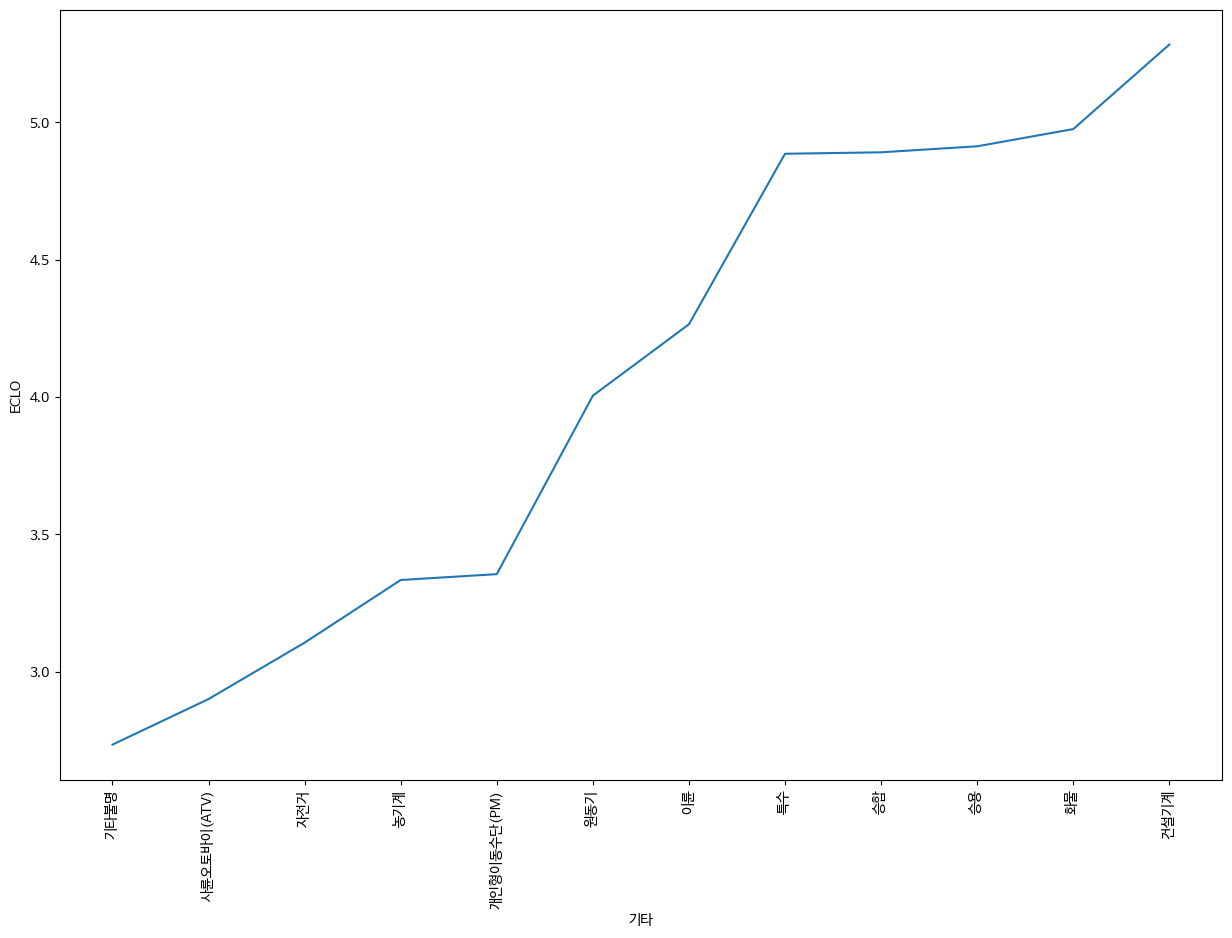

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(train_df.groupby(['가해운전자 차종'])['ECLO'].mean().sort_values(ascending=True))
plt.xticks(rotation=90)
plt.xlabel('기타')
plt.ylabel('ECLO')
plt.show()

In [ ]:
train_df['가해운전자 차종'].value_counts().sum()

승용             26705
이륜              4091
화물              4040
승합              1376
자전거             1234
기타불명             978
원동기              462
건설기계             425
개인형이동수단(PM)      172
특수               113
사륜오토바이(ATV)       10
농기계                3
Name: 가해운전자 차종, dtype: int64

In [ ]:
train_df[train_df['가해운전자 차종']=='화물']['동'].value_counts().iloc[:30]

대명동      131
다사읍      113
비산동      111
산격동      109
화원읍      102
평리동      100
상인동       76
침산동       73
용산동       71
내당동       70
노원동3가     69
이곡동       68
송현동       67
범어동       66
만촌동       65
신암동       64
신당동       64
감삼동       63
월성동       61
태전동       59
이현동       59
두류동       55
봉덕동       55
논공읍       53
효목동       52
읍내동       52
상리동       49
대천동       48
장기동       48
복현동       47
Name: 동, dtype: int64

In [ ]:
# 동별 가해운전자 차종별 합계 계산
total_by_vehicle_type = train_df.groupby(['동', '가해운전자 차종']).size().reset_index(name='count')

# 전체 차종의 합계 계산
total_all_vehicles = total_by_vehicle_type.groupby('동')['count'].sum().reset_index(name='total_all_vehicles')

# 건설기계, 승합, 화물, 특수에 해당하는 데이터만 필터링
filtered_df = total_by_vehicle_type[total_by_vehicle_type['가해운전자 차종'].isin(['건설기계', '승합', '화물', '특수'])]

# 건설기계, 승합, 화물, 특수에 해당하는 합계 계산
total_filtered_vehicles = filtered_df.groupby('동')['count'].sum().reset_index(name='total_filtered_vehicles')

# 전체 차종 대비 비율 계산
eng_vehi = pd.merge(total_all_vehicles, total_filtered_vehicles, on='동', how='left')
eng_vehi['건승화특_백분율'] = (eng_vehi['total_filtered_vehicles'] / eng_vehi['total_all_vehicles']) * 100

# 필요한 열만 선택하여 최종 데이터프레임 생성
eng_vehi = eng_vehi[['동', '건승화특_백분율']].copy()


In [ ]:
train_df = pd.merge(train_df, eng_vehi, on='동', how='left')
print(train_df.shape)
train_df = train_df.fillna(0)
train_df.drop(columns=['법규위반','사고유형 - 세부분류','가해운전자 차종'], inplace=True)
test_df = pd.merge(test_df, eng_vehi, on='동', how='left')
train_df

(39609, 19)


,ID,요일,기상상태,노면상태,사고유형,ECLO,연,월,일,시간,도시,구,동,도로형태1,도로형태2,건승화특_백분율
0,ACCIDENT_00000,화요일,맑음,건조,차대사람,5,2019,1,1,0,대구광역시,중구,대신동,단일로,기타,13.740458
1,ACCIDENT_00001,화요일,흐림,건조,차대사람,3,2019,1,1,0,대구광역시,달서구,감삼동,단일로,기타,14.159292
2,ACCIDENT_00002,화요일,맑음,건조,차대사람,3,2019,1,1,1,대구광역시,수성구,두산동,단일로,기타,8.112583
3,ACCIDENT_00003,화요일,맑음,건조,차대차,5,2019,1,1,2,대구광역시,북구,복현동,단일로,기타,14.553991
4,ACCIDENT_00004,화요일,맑음,건조,차대차,3,2019,1,1,4,대구광역시,동구,신암동,단일로,기타,14.787879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,ACCIDENT_39604,금요일,맑음,건조,차대차,3,2021,12,31,19,대구광역시,수성구,수성동3가,교차로,교차로안,8.653846
39605,ACCIDENT_39605,금요일,맑음,건조,차대차,3,2021,12,31,19,대구광역시,달서구,상인동,단일로,기타,10.323710
39606,ACCIDENT_39606,금요일,맑음,건조,차대차,10,2021,12,31,21,대구광역시,달서구,월성동,교차로,교차로안,14.563107
39607,ACCIDENT_39607,금요일,맑음,건조,차대차,3,2021,12,31,22,대구광역시,달서구,장동,기타,기타,31.200000


트레인 테스트에 cctv정보추가

In [ ]:
child_df = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/external_open/대구_어린이_보호_구역_정보.csv', encoding='cp949')
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

child_df[['도시', '구', '동','번지']] = child_df['소재지지번주소'].str.extract(location_pattern)
child_df = child_df.drop(columns=['소재지지번주소'])
child_df

,시설종류,대상시설명,소재지도로명주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자,도시,구,동,번지
0,초등학교,남도초등학교,대구광역시 남구 현충동길 74(대명동),35.845027,128.581402,대구광역시,남부경찰서,Y,7.0,6~8,2020-03-23,대구광역시,남구,대명동,1709
1,초등학교,영선초등학교,대구광역시 남구 영선길96(이천동),35.852901,128.596014,대구광역시,남부경찰서,Y,8.0,6~10,2020-03-23,대구광역시,남구,이천동,477
2,초등학교,성명초등학교,대구광역시 남구 성당로 30길 55(대명동),35.845152,128.570825,대구광역시,남부경찰서,Y,14.0,8~12,2020-03-23,대구광역시,남구,대명동,3050
3,초등학교,남덕초등학교,대구광역시 남구 앞산순환로 93길 33,35.833042,128.573949,대구광역시,남부경찰서,Y,6.0,6~8,2020-03-23,대구광역시,남구,대명동,531-1
4,초등학교,대명초등학교,대구광역시 남구 대명로 110,35.838869,128.568889,대구광역시,남부경찰서,Y,5.0,6~10,2020-03-23,대구광역시,남구,대명동,960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,어린이집,남산교회어린이집,대구광역시 중구 관덕정길 16,35.865040,128.590565,대구광역시 중구청,대구광역시 중부경찰서,Y,5.0,6~10,2019-06-01,대구광역시,중구,남산동,941-1
636,초등학교,대구초등학교,대구광역시 중구 명륜로23길 80,35.864037,128.595370,대구광역시 중구청,대구광역시 중부경찰서,Y,12.0,3~12,2019-06-01,대구광역시,중구,봉산동,57
637,어린이집,대구삼성어린이집,대구광역시 중구 달구벌대로 2016-40,35.864469,128.584301,대구광역시 중구청,대구광역시 중부경찰서,Y,2.0,7~8,2019-06-01,대구광역시,중구,남산동,153-2
638,어린이집,동화나라어린이집,대구광역시 중구 남산로3안길 20,35.860371,128.577492,대구광역시 중구청,대구광역시 중부경찰서,Y,5.0,6~8,2019-06-01,대구광역시,중구,남산동,2623-6


In [ ]:
print(child_df['CCTV설치대수'].unique()) #4는 주차카메라
print(child_df['동'].unique())
print(train_df['동'].unique())

[ 7.  8. 14.  6.  5.  9. 10.  4.  2.  3.  1.  0. 11. nan 12.]
['대명동' '이천동' '봉덕동' '가창면' '구지면' '옥포면' '논공읍' '화원읍' '다사읍' '하빈면' '유가읍' '현풍면'
 nan '태전동' '구암동' '복현동' '관음동' '읍내동' '산격동' '국우동' '침산동' '매천동' '동천동' '사수동'
 '동변동' '서변동' '학정동' '대현동' '검단동' '노원동1가' '도남동' '고성동2가' '칠성동2가' '조야동' '팔달동'
 '고성동1가' '내당동' '중리동' '원대동1가' '비산동' '평리동' '이현동' '수성동4가' '노변동' '황금동' '만촌동'
 '범어동' '수성동1가' '두산동' '신매동' '파동' '상동' '매호동' '욱수동' '지산동' '중동' '시지동' '범물동'
 '수성동3가' '사월동' '수성동2가' '수창동' '남산동' '서문로1가' '삼덕동3가' '동인동4가' '봉산동' '대신동'
 '삼덕동2가' '남일동' '덕산동' '동산동']
['대신동' '감삼동' '두산동' '복현동' '신암동' '지산동' '상인동' '태전동' '지묘동' '평리동' '신기동' '상리동'
 '월성동' '황금동' '구암동' '신천동' '만촌동' '남산동' '비산동' '침산동' '두류동' '신매동' '대곡동' '유가읍'
 '논공읍' '율하동' '시지동' '봉무동' '다사읍' '동산동' '이현동' '이천동' '수성동4가' '노원동3가' '서변동'
 '관음동' '학정동' '파동' '상동' '이곡동' '효목동' '읍내동' '남성로' '죽전동' '대명동' '동천동' '지저동'
 '사수동' '덕산동' '본리동' '용계동' '범어동' '신당동' '성당동' '용산동' '태평로3가' '도학동' '욱수동' '불로동'
 '칠성동1가' '장기동' '매호동' '대천동' '삼덕동1가' '수성동2가' '팔달동' '삼덕동' '진천동' '수성동3가' '가창면'
 '방촌동' '산격동' '월암동' '현풍읍' '구지면' '매천동' '송

In [ ]:
child_cctv_df = {'동':[],
                 '어린이CCTV설치대수':[]}
child_cctv_df = pd.DataFrame(child_cctv_df)

#동마다 CCTV 갯수 넣을꺼
temp_list = []
for i in child_df['동'].unique() :
  temp_list.append(len(child_df[child_df['동']==i].loc[:,'CCTV설치대수']))

child_cctv_df['동'] = child_df['동'].unique()
child_cctv_df['어린이CCTV설치대수'] = temp_list
child_cctv_df = child_cctv_df.dropna(axis=0) #nan값이 하나 있어서

#train, test 어린이cctv여부 추가

train_df = pd.merge(train_df, child_cctv_df, on='동', how='left')
print(train_df.shape)
train_df = train_df.fillna(0)

test_df = pd.merge(test_df, child_cctv_df, on='동', how='left')
print(test_df.shape)
test_df = test_df.fillna(0)

(39609, 17)
(10963, 16)


In [ ]:
cctv_df = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/external_open/대구_CCTV_정보.csv', encoding='cp949')
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

cctv_df[['도시', '구', '동','번지']] = cctv_df['소재지지번주소'].str.extract(location_pattern)
cctv_df = cctv_df.drop(columns=['소재지지번주소'])
cctv_df

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,위도,경도,...,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도,도시,구,동,번지
0,주차12,대구광역시,남구,시도,NaN,대명로,3,대구광역시 남구 대명로 162,35.838857,128.575418,...,4,0,NaN,NaN,99.0,2010.0,대구광역시,남구,대명동,903-13
1,주차13,대구광역시,남구,시도,NaN,봉덕로,3,대구광역시 남구 봉덕로 135,35.844653,128.604619,...,4,0,NaN,NaN,99.0,2013.0,대구광역시,남구,봉덕동,853-8
2,주차14,대구광역시,남구,시도,NaN,대봉로,3,대구광역시 남구 봉덕로 134,35.844183,128.604815,...,4,0,NaN,NaN,99.0,2013.0,대구광역시,남구,봉덕동,866-46
3,주차15,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 200,35.834798,128.585284,...,4,0,NaN,NaN,99.0,2014.0,대구광역시,남구,대명동,2680-17
4,주차16,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 243,35.832728,128.588324,...,4,0,NaN,NaN,99.0,2014.0,대구광역시,남구,봉덕동,1616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,H2418,대구광역시,북구,특별시도,NaN,태암남로,1,대구광역시 북구 태암남로 41,35.925294,128.552023,...,2,40,NaN,NaN,99.0,2021.0,대구광역시,북구,구암동,671-8
1061,H2419,대구광역시,북구,특별시도,NaN,내곡로,1,대구광역시 북구 내곡로 90,35.900977,128.513825,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,사수동,812
1062,H4145,대구광역시,북구,특별시도,NaN,대현로,2,대구광역시 북구 대현로 100,35.882191,128.609791,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,대현동,270-8
1063,H4146,대구광역시,북구,특별시도,NaN,대현로,1,대구광역시 북구 대현로 118,35.881737,128.611651,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,대현동,270-3


In [ ]:
print(cctv_df['단속구분'].unique()) #4는 주차카메라

[ 4  1  2 99]


In [ ]:
cctv_list = {'동':[],
             'CCTV개수':[]}
cctv_list = pd.DataFrame(cctv_list)
#동마다 CCTV 갯수 넣을꺼
temp_list = []
for i in cctv_df['동'].unique() :
  temp_list.append(len(cctv_df[(cctv_df['동']==i)&((cctv_df['단속구분']==2)|(cctv_df['단속구분']==1)|(cctv_df['단속구분']==99))]))

cctv_list['동'] = cctv_df['동'].unique()
cctv_list['CCTV개수'] = temp_list
cctv_list = cctv_list.dropna(axis=0) #nan값이 하나 있어서

#train, test cctv_list 추가

train_df = pd.merge(train_df, cctv_list, on='동', how='left')
print(train_df.shape)
train_df = train_df.fillna(0)

test_df = pd.merge(test_df, cctv_list, on='동', how='left')
print(test_df.shape)
test_df = test_df.fillna(0)

(39609, 18)
(10963, 17)


In [ ]:
#동마다 CCTV 제한속도 평균
speed_df = {'동':[],
             '평균속도':[]}
speed_df = pd.DataFrame(speed_df)
speed_list = []
for i in cctv_df['동'].unique() :
  temp_list = []
  count_list = []
  temp = 0
  sum_list = []
  for j in [30,50,60,70,80,100] :
    temp_list.append(len(cctv_df[(cctv_df['제한속도']==j)&(cctv_df['동']== i)])*j)
    temp += (len(cctv_df[(cctv_df['제한속도']==j)&(cctv_df['동']== i)]))
    #print(temp_list)
    #print(temp)

  sum_list = sum(temp_list)
  if temp != 0 :
    speed_list.append(sum_list/temp)
  else:
    speed_list.append(38)
  #print(speed_list)
#len(speed_list)

speed_df['동'] = cctv_df['동'].unique()
speed_df['평균속도'] = speed_list
speed_df = speed_df.dropna(axis=0) #nan값이 하나 있어서

#train, test cctv_list 추가

train_df = pd.merge(train_df, speed_df, on='동', how='left')
print(train_df.shape)
train_df = train_df.fillna(0)
print(train_df.isnull().sum())

test_df = pd.merge(test_df, speed_df, on='동', how='left')
print(test_df.shape)
test_df = test_df.fillna(0)
print(test_df.isnull().sum())


(39609, 19)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
ECLO           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
건승화특_백분율       0
어린이CCTV설치대수    0
CCTV개수         0
평균속도           0
dtype: int64
(10963, 18)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
건승화특_백분율       0
어린이CCTV설치대수    0
CCTV개수         0
평균속도           0
dtype: int64


In [ ]:
print(train_df['기상상태'].unique())
print(train_df['노면상태'].unique())
print(train_df['사고유형'].unique())
print(train_df['ECLO'].unique())
print(train_df['도로형태1'].unique())
print(train_df['도로형태2'].unique())
print(train_df['기상상태'].value_counts())
print(train_df['노면상태'].value_counts())
print(train_df['사고유형'].value_counts())
print(train_df['도로형태1'].value_counts())
print(train_df['도로형태2'].value_counts())

['맑음' '흐림' '기타' '비' '안개' '눈']
['건조' '젖음/습기' '서리/결빙' '기타' '침수' '적설']
['차대사람' '차대차' '차량단독']
[ 5  3  6 18  9  8 15  2  1  7  4 12 13 10 11 16 40 22 21 17 25 14 20 27
 19 24 26 23 28 31 30 47 36 33 34 35 37 65 56 32 57 45 52 74 39 66]
['단일로' '교차로' '기타' '주차장' '미분류']
['기타' '교차로안' '터널' '지하차도(도로)내' '교량' '교차로횡단보도내' '주차장' '교차로부근' '고가도로위' '미분류']
맑음    36184
비      2635
흐림      738
기타       34
안개       10
눈         8
Name: 기상상태, dtype: int64
건조       36423
젖음/습기     3104
기타          51
서리/결빙       25
침수           3
적설           3
Name: 노면상태, dtype: int64
차대차     31785
차대사람     6833
차량단독      991
Name: 사고유형, dtype: int64
단일로    20233
교차로    17153
기타      1986
주차장      236
미분류        1
Name: 도로형태1, dtype: int64
기타           21478
교차로안          9931
교차로부근         5746
교차로횡단보도내      1474
지하차도(도로)내      309
주차장            236
교량             232
고가도로위          138
터널              64
미분류              1
Name: 도로형태2, dtype: int64


기상상태 비이고 노면상태 기타 경우 젖음/습기로 변경<br>
미분류 도로 가장 많은 도로형태로 수정

In [ ]:
train_df.loc[4185,'노면상태'] = '젖음/습기'
train_df.loc[5135,'노면상태'] = '젖음/습기'
train_df.loc[6892,'노면상태'] = '젖음/습기'
train_df.loc[33750,'노면상태'] = '젖음/습기'
train_df.loc[35213,'노면상태'] = '젖음/습기'
train_df.loc[36407,'노면상태'] = '젖음/습기'

In [ ]:
train_df[train_df['동'] == '내당동']['도로형태1'].value_counts()
train_df[train_df['동'] == '다사읍']['도로형태1'].value_counts()


#내당동 관음동 신매동 파동 노원동3가 단일로, 율하동, 다사읍 교차로

교차로    395
단일로    299
기타      81
주차장     16
미분류      1
Name: 도로형태1, dtype: int64

In [ ]:
#만총동만 test로 미분류 임

train_df.loc[983,'도로형태1'] = '단일로'
train_df.loc[1084,'도로형태1'] = '단일로'
train_df.loc[12779,'도로형태1'] = '교차로'
train_df.loc[15742,'도로형태1'] = '단일로'
train_df.loc[16924,'도로형태1'] = '단일로'
train_df.loc[21393,'도로형태1'] = '단일로'
train_df.loc[26090,'도로형태1'] = '교차로'

In [ ]:
train_df[(train_df['동'] == '다사읍') & (train_df['도로형태1'] == '단일로')]['도로형태2'].value_counts()

기타       293
교량         4
고가도로위      1
터널         1
Name: 도로형태2, dtype: int64

In [ ]:
train_df.loc[983,'도로형태2'] = '기타'
train_df.loc[1084,'도로형태2'] = '기타'
train_df.loc[12779,'도로형태2'] = '기타'
train_df.loc[15742,'도로형태2'] = '기타'
train_df.loc[16924,'도로형태2'] = '기타'
train_df.loc[21393,'도로형태2'] = '기타'
train_df.loc[26090,'도로형태2'] = '기타'

In [ ]:
train_df['동'].value_counts()

대명동      1749
범어동      1173
상인동      1143
비산동       968
내당동       938
         ... 
완전동         2
신용동         2
동성로1가       2
도남동         2
평광동         1
Name: 동, Length: 196, dtype: int64

In [ ]:
train_df[train_df['사고유형 - 세부분류'] == '추돌'].groupby(['도로형태2'])['ECLO'].mean().sort_values(ascending=True)

도로형태2
미분류          3.000000
주차장          4.437500
교차로횡단보도내     4.916667
교차로안         5.193431
교차로부근        5.327234
기타           5.691887
지하차도(도로)내    5.833333
고가도로위        6.025000
교량           6.185714
터널           8.923077
Name: ECLO, dtype: float64

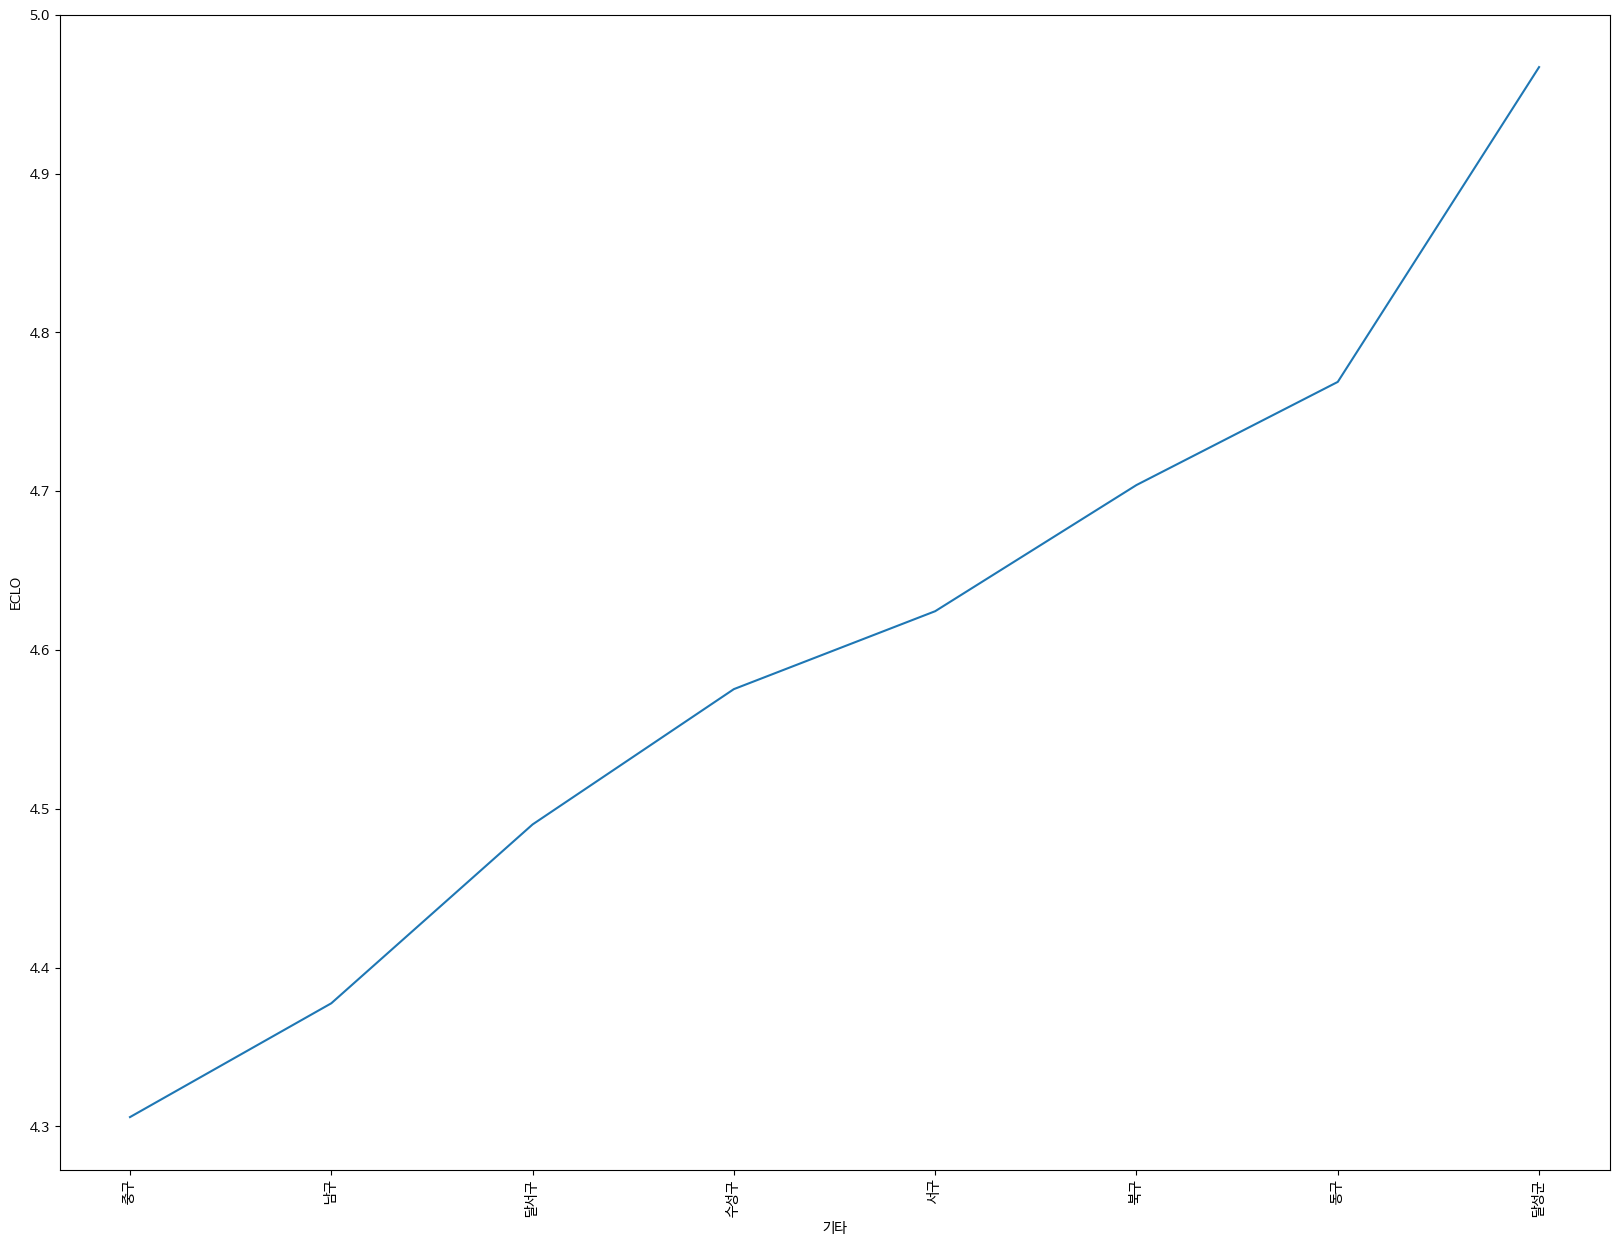

In [ ]:
plt.figure(figsize=(20,15))
plt.plot(train_df[train_df['도로형태2'] == '기타'].groupby(['구'])['ECLO'].mean().sort_values(ascending=True))
plt.xticks(rotation=90)
plt.xlabel('기타')
plt.ylabel('ECLO')
plt.show()

In [ ]:
train_df['사고유형 - 세부분류'].value_counts()

측면충돌          17104
기타            10630
추돌             5885
횡단중            2443
정면충돌            837
차도통행중           616
후진중충돌           613
보도통행중           524
길가장자리구역통행중      467
공작물충돌           324
전도전복 - 전도       144
전도전복 - 전복        10
도로외이탈 - 추락        8
도로외이탈 - 기타        4
Name: 사고유형 - 세부분류, dtype: int64

In [ ]:
train_df['사고유형'].value_counts()

차대차     31785
차대사람     6833
차량단독      991
Name: 사고유형, dtype: int64

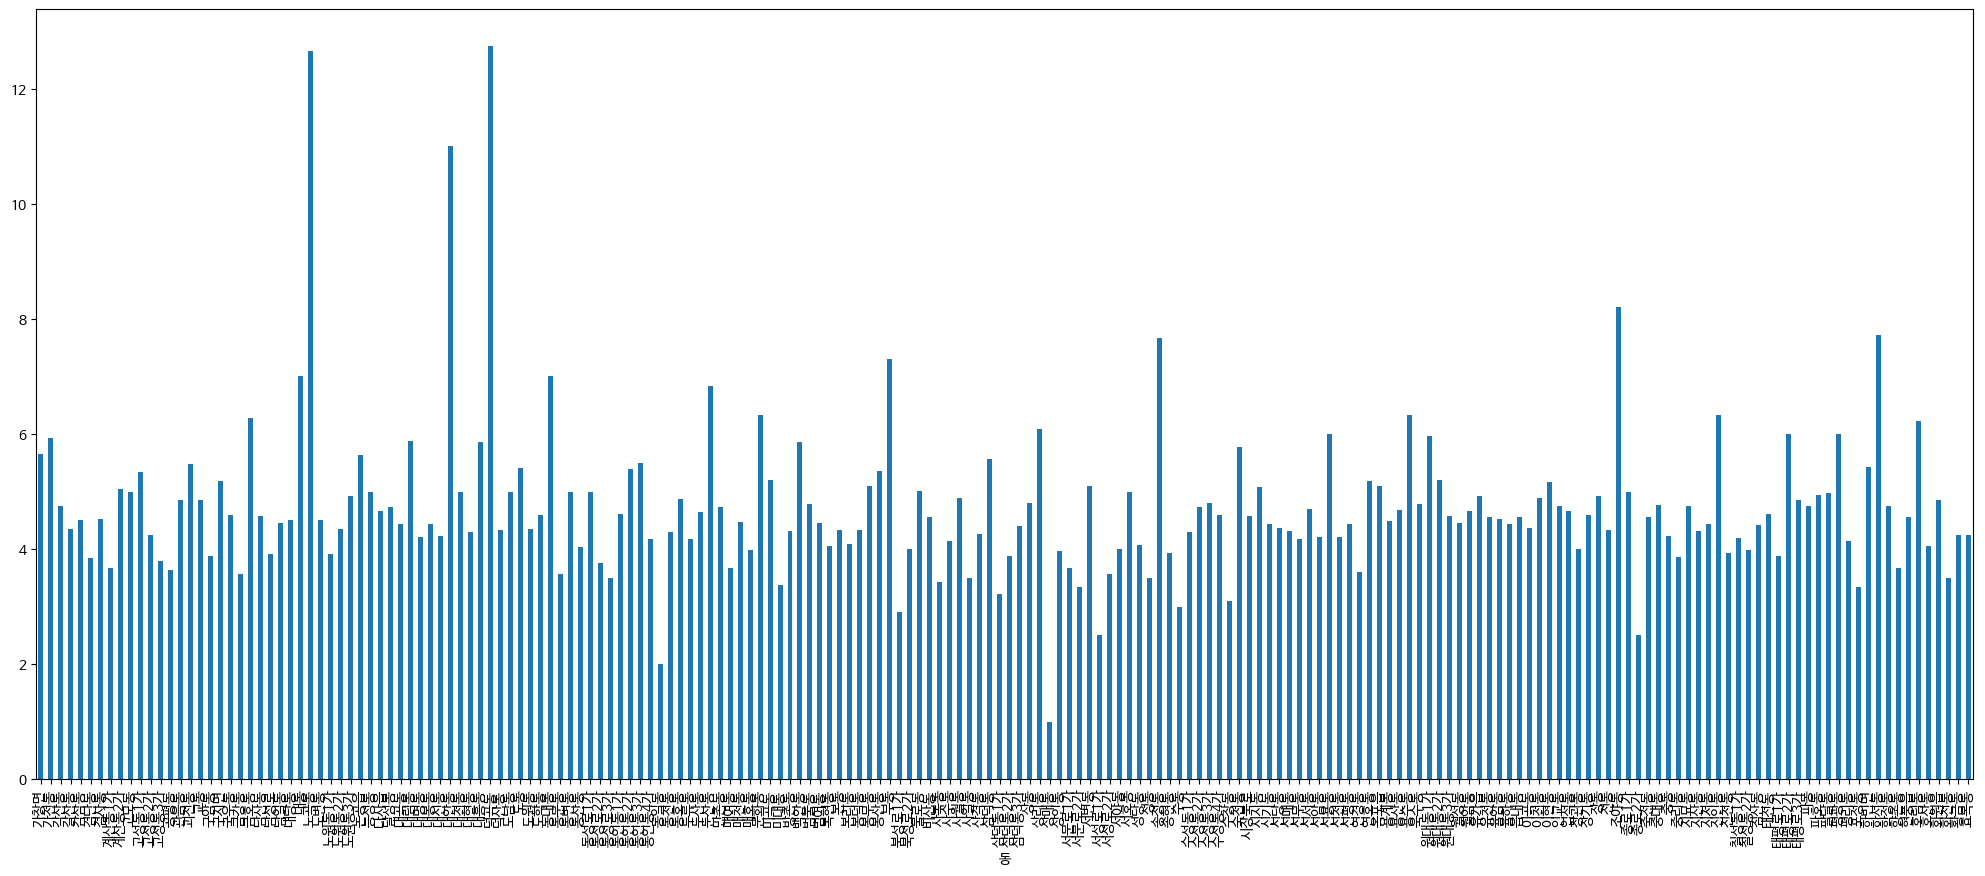

In [ ]:
filtered_df = train_df[train_df['법규위반'] == '안전운전불이행'].groupby(['동'])['ECLO'].mean()
plt.figure(figsize=(25,10))
filtered_df.plot(kind='bar')
plt.show()


<Axes: xlabel='시간'>

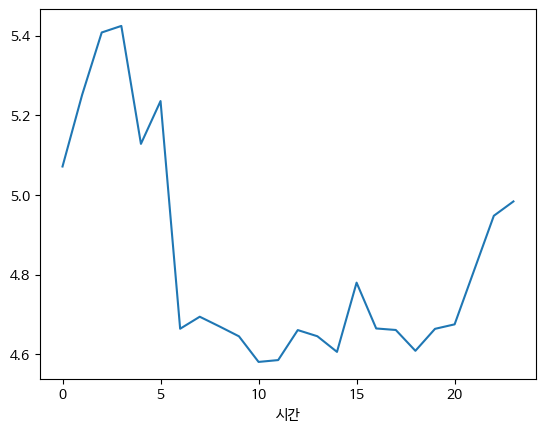

In [ ]:
train_df.groupby(['시간'])['ECLO'].mean().plot()

In [ ]:
# 여러 조건에 따라 값을 설정하는 함수 정의 2분류법이 옳다 / ECLO와 상관관계를 가지는게 무엇보다 중
def assign_category(value):
    if value in [1,2,3,4]:
        return '새벽'
    elif value in [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,0,6,5]:
        return '주간'
    else:
        return 'Unknown'

def weekday_category(value):
    if value in ['화요일','수요일','목요일','금요일','월요일']:
        return '주간'
    elif value in ['토요일','일요일']:
        return '주말'
    else:
        return 'Unknown'



# 'Value' 열에 대해 새로운 열 생성
train_df['통합시간'] = train_df['시간'].apply(assign_category)
train_df['통합요일'] = train_df['요일'].apply(weekday_category)
test_df['통합시간'] = test_df['시간'].apply(assign_category)
test_df['통합요일'] = test_df['요일'].apply(weekday_category)

피처, 타겟 분리 라벨인코딩

In [ ]:
train_df = pd.get_dummies(train_df, columns=['통합시간'])
train_df = pd.get_dummies(train_df, columns=['통합요일'])
test_df = pd.get_dummies(test_df, columns=['통합시간'])
test_df = pd.get_dummies(test_df, columns=['통합요일'])

In [ ]:
#X = train_df.drop(columns=['ECLO','부상자수','경상자수','중상자수','사망자수','피해운전자 상해정도','피해운전자 연령','피해운전자 차종','가해운전자 상해정도',
                           #'가해운전자 연령','가해운전자 성별','가해운전자 차종','법규위반','사고유형 - 세부분류','피해운전자 성별','도시'])
X = train_df.drop(columns=['ID','도시','ECLO'])
y = train_df['ECLO']
test_df = test_df.drop(columns=['ID','도시'])
print(X.shape, y.shape, test_df.shape)

(39609, 20) (39609,) (10963, 20)


In [ ]:
X

,요일,기상상태,노면상태,사고유형,연,월,일,시간,구,동,도로형태1,도로형태2,건승화특_백분율,어린이CCTV설치대수,평균속도,통합시간_새벽,통합시간_주간,통합요일_주간,통합요일_주말
0,화요일,맑음,건조,차대사람,2019,1,1,0,중구,대신동,단일로,기타,13.740458,2.0,38.000000,0,1,1,0
1,화요일,흐림,건조,차대사람,2019,1,1,0,달서구,감삼동,단일로,기타,14.159292,0.0,52.500000,0,1,1,0
2,화요일,맑음,건조,차대사람,2019,1,1,1,수성구,두산동,단일로,기타,8.112583,5.0,55.000000,1,0,1,0
3,화요일,맑음,건조,차대차,2019,1,1,2,북구,복현동,단일로,기타,14.553991,11.0,37.500000,1,0,1,0
4,화요일,맑음,건조,차대차,2019,1,1,4,동구,신암동,단일로,기타,14.787879,0.0,40.000000,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,금요일,맑음,건조,차대차,2021,12,31,19,수성구,수성동3가,교차로,교차로안,8.653846,1.0,38.000000,0,1,1,0
39605,금요일,맑음,건조,차대차,2021,12,31,19,달서구,상인동,단일로,기타,10.323710,0.0,45.000000,0,1,1,0
39606,금요일,맑음,건조,차대차,2021,12,31,21,달서구,월성동,교차로,교차로안,14.563107,0.0,41.111111,0,1,1,0
39607,금요일,맑음,건조,차대차,2021,12,31,22,달서구,장동,기타,기타,31.200000,0.0,60.000000,0,1,1,0


In [ ]:
from sklearn.preprocessing import MinMaxScaler

X_num = X[['어린이CCTV설치대수','CCTV개수','평균속도','건승화특_백분율']]
scaler = MinMaxScaler()
scaler.fit(X_num)
transform_X_num = scaler.transform(X_num)
transform_X_num = pd.DataFrame(transform_X_num)
transform_test_num = scaler.transform(test_df[['어린이CCTV설치대수','CCTV개수','평균속도','건승화특_백분율']])
transform_test_num = pd.DataFrame(transform_test_num)
X_scaled = pd.concat([X, transform_X_num], axis=1)
test_scaled = pd.concat([test_df, transform_test_num], axis=1)
X_scaled.drop(columns=['어린이CCTV설치대수','CCTV개수','평균속도','건승화특_백분율'], inplace=True)
test_scaled.drop(columns=['어린이CCTV설치대수','CCTV개수','평균속도','건승화특_백분율'], inplace=True)
X_scaled

,요일,기상상태,노면상태,사고유형,연,월,일,시간,구,동,도로형태1,도로형태2,통합시간_새벽,통합시간_주간,통합요일_주간,통합요일_주말,0,1,2,3
0,화요일,맑음,건조,차대사람,2019,1,1,0,중구,대신동,단일로,기타,0,1,1,0,0.033333,0.019231,0.380000,0.240458
1,화요일,흐림,건조,차대사람,2019,1,1,0,달서구,감삼동,단일로,기타,0,1,1,0,0.000000,0.076923,0.525000,0.247788
2,화요일,맑음,건조,차대사람,2019,1,1,1,수성구,두산동,단일로,기타,1,0,1,0,0.083333,0.076923,0.550000,0.141970
3,화요일,맑음,건조,차대차,2019,1,1,2,북구,복현동,단일로,기타,1,0,1,0,0.183333,0.192308,0.375000,0.254695
4,화요일,맑음,건조,차대차,2019,1,1,4,동구,신암동,단일로,기타,1,0,1,0,0.000000,0.230769,0.400000,0.258788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,금요일,맑음,건조,차대차,2021,12,31,19,수성구,수성동3가,교차로,교차로안,0,1,1,0,0.016667,0.019231,0.380000,0.151442
39605,금요일,맑음,건조,차대차,2021,12,31,19,달서구,상인동,단일로,기타,0,1,1,0,0.000000,0.346154,0.450000,0.180665
39606,금요일,맑음,건조,차대차,2021,12,31,21,달서구,월성동,교차로,교차로안,0,1,1,0,0.000000,0.173077,0.411111,0.254854
39607,금요일,맑음,건조,차대차,2021,12,31,22,달서구,장동,기타,기타,0,1,1,0,0.000000,0.019231,0.600000,0.546000


In [ ]:
from sklearn.preprocessing import LabelEncoder

FEATURE = ['기상상태','노면상태','구','동','도로형태1','도로형태2','사고유형','요일']
for i in FEATURE:
    le = LabelEncoder()
    X_scaled[i]= le.fit_transform(X_scaled[i])
    test_scaled[i]= le.transform(test_scaled[i])

X_scaled

,요일,기상상태,노면상태,사고유형,연,월,일,시간,구,동,도로형태1,도로형태2,통합시간_새벽,통합시간_주간,통합요일_주간,통합요일_주말,0,1,2,3
0,6,2,0,0,2019,1,1,0,7,40,2,5,0,1,1,0,0.033333,0.019231,0.380000,0.240458
1,6,5,0,0,2019,1,1,0,1,4,2,5,0,1,1,0,0.000000,0.076923,0.525000,0.247788
2,6,2,0,0,2019,1,1,1,6,66,2,5,1,0,1,0,0.083333,0.076923,0.550000,0.141970
3,6,2,0,1,2019,1,1,2,4,79,2,5,1,0,1,0,0.183333,0.192308,0.375000,0.254695
4,6,2,0,1,2019,1,1,4,3,129,2,5,1,0,1,0,0.000000,0.230769,0.400000,0.258788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,0,2,0,1,2021,12,31,19,6,118,0,3,0,1,1,0,0.016667,0.019231,0.380000,0.151442
39605,0,2,0,1,2021,12,31,19,1,103,2,5,0,1,1,0,0.000000,0.346154,0.450000,0.180665
39606,0,2,0,1,2021,12,31,21,1,144,0,3,0,1,1,0,0.000000,0.173077,0.411111,0.254854
39607,0,2,0,1,2021,12,31,22,1,158,1,5,0,1,1,0,0.000000,0.019231,0.600000,0.546000


In [ ]:
test_scaled

,요일,기상상태,노면상태,사고유형,연,월,일,시간,구,동,도로형태1,도로형태2,통합시간_새벽,통합시간_주간,통합요일_주간,통합요일_주말,0,1,2,3
0,5,2,0,0,2022,1,1,1,6,99,0,3,1,0,0,1,0.083333,0.076923,0.525000,0.248521
1,5,2,0,0,2022,1,1,1,6,168,2,5,1,0,0,1,0.166667,0.134615,0.471429,0.170732
2,5,2,0,1,2022,1,1,4,6,117,0,3,1,0,0,1,0.016667,0.019231,0.380000,0.238095
3,5,2,0,1,2022,1,1,4,6,126,2,5,1,0,0,1,0.116667,0.211538,0.427273,0.197581
4,5,2,0,1,2022,1,1,6,1,4,0,3,0,1,0,1,0.000000,0.076923,0.525000,0.247788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,5,2,0,1,2022,12,31,18,0,38,2,9,0,1,0,1,0.433333,0.519231,0.486364,0.192110
10959,5,2,0,1,2022,12,31,18,6,123,2,5,0,1,0,1,0.083333,0.076923,0.525000,0.272455
10960,5,2,0,1,2022,12,31,20,6,134,2,5,0,1,0,1,0.000000,0.000000,0.000000,0.245327
10961,5,2,0,1,2022,12,31,20,6,77,0,2,0,1,0,1,0.116667,0.134615,0.442857,0.212343


모델 훈련 및 예측

In [ ]:
#xgboost22.csv
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

def objective(trial):
    # XGBoost의 하이퍼파라미터를 설정합니다.
    param = {
        'objective': 'reg:squaredlogerror',
        'eval_metric': 'rmsle',
        'lambda': trial.suggest_float('lambda', 1e-3, 0.1),
        'alpha': trial.suggest_float('alpha', 1e-3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1),
        'subsample': trial.suggest_float('subsample', 0.4, 1),
        'learning_rate': trial.suggest_float('learning_rate',1e-3, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 4,8),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 50),
    }

    # XGBoost 모델을 생성합니다.
    model = xgb.XGBRegressor(**param)

    # 모델을 훈련합니다.
    model.fit(X_train, y_train, eval_set=[(X_train,y_train)],early_stopping_rounds=100)

    # 검증 데이터에 대한 예측을 수행합니다.
    y_pred = model.predict(X_val)

    # RMSE를 계산하여 반환합니다.
    rmsle = np.sqrt(mean_squared_log_error(y_val, y_pred))
    return rmsle

# Optuna를 사용하여 하이퍼파라미터 튜닝을 수행합니다.
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# 최적의 하이퍼파라미터를 출력합니다.
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_params = trial.params
final_model = xgb.XGBRegressor(
    objective='reg:squaredlogerror',
    eval_metric='rmsle',
    verbosity=0,
    n_jobs=-1,
    tree_method='hist',
    **best_params
)

final_model.fit(X_scaled, y, verbose=False)
y_pred = final_model.predict(test_scaled)

[I 2023-11-26 03:22:45,562] A new study created in memory with name: no-name-a90754a5-f3f9-44ac-b884-7b026dfc4dfd


[0]	validation_0-rmsle:1.21188
[1]	validation_0-rmsle:1.18649
[2]	validation_0-rmsle:1.16147
[3]	validation_0-rmsle:1.13682
[4]	validation_0-rmsle:1.11256
[5]	validation_0-rmsle:1.08873
[6]	validation_0-rmsle:1.06528
[7]	validation_0-rmsle:1.04227
[8]	validation_0-rmsle:1.01964
[9]	validation_0-rmsle:0.99747
[10]	validation_0-rmsle:0.97572
[11]	validation_0-rmsle:0.95442
[12]	validation_0-rmsle:0.93362
[13]	validation_0-rmsle:0.91324
[14]	validation_0-rmsle:0.89336
[15]	validation_0-rmsle:0.87385
[16]	validation_0-rmsle:0.85486
[17]	validation_0-rmsle:0.83636
[18]	validation_0-rmsle:0.81831
[19]	validation_0-rmsle:0.80081
[20]	validation_0-rmsle:0.78381
[21]	validation_0-rmsle:0.76728
[22]	validation_0-rmsle:0.75128
[23]	validation_0-rmsle:0.73572
[24]	validation_0-rmsle:0.72064
[25]	validation_0-rmsle:0.70608
[26]	validation_0-rmsle:0.69207
[27]	validation_0-rmsle:0.67854
[28]	validation_0-rmsle:0.66536
[29]	validation_0-rmsle:0.65276
[30]	validation_0-rmsle:0.64066
[31]	validation_0-

[I 2023-11-26 03:22:48,873] Trial 0 finished with value: 0.44532840317629485 and parameters: {'lambda': 0.04664101549573391, 'alpha': 0.650881490129166, 'colsample_bytree': 0.6407264016198748, 'subsample': 0.6605825146445166, 'learning_rate': 0.052593377176186375, 'n_estimators': 181, 'max_depth': 4, 'min_child_weight': 34}. Best is trial 0 with value: 0.44532840317629485.


[0]	validation_0-rmsle:1.18972
[1]	validation_0-rmsle:1.14314
[2]	validation_0-rmsle:1.09788
[3]	validation_0-rmsle:1.05399
[4]	validation_0-rmsle:1.01150
[5]	validation_0-rmsle:0.97069
[6]	validation_0-rmsle:0.93128
[7]	validation_0-rmsle:0.89350
[8]	validation_0-rmsle:0.85732
[9]	validation_0-rmsle:0.82281
[10]	validation_0-rmsle:0.79003
[11]	validation_0-rmsle:0.75904
[12]	validation_0-rmsle:0.72986
[13]	validation_0-rmsle:0.70233
[14]	validation_0-rmsle:0.67668
[15]	validation_0-rmsle:0.65267
[16]	validation_0-rmsle:0.63033
[17]	validation_0-rmsle:0.60986
[18]	validation_0-rmsle:0.59114
[19]	validation_0-rmsle:0.57409
[20]	validation_0-rmsle:0.55870
[21]	validation_0-rmsle:0.54473
[22]	validation_0-rmsle:0.53223
[23]	validation_0-rmsle:0.52094
[24]	validation_0-rmsle:0.51108
[25]	validation_0-rmsle:0.50224
[26]	validation_0-rmsle:0.49455
[27]	validation_0-rmsle:0.48768
[28]	validation_0-rmsle:0.48144
[29]	validation_0-rmsle:0.47616
[30]	validation_0-rmsle:0.47187
[31]	validation_0-

[I 2023-11-26 03:23:03,212] Trial 1 finished with value: 0.4479449632507768 and parameters: {'lambda': 0.07901705289975762, 'alpha': 0.6829308577369301, 'colsample_bytree': 0.4794946189465498, 'subsample': 0.5704351673296877, 'learning_rate': 0.09908992700728929, 'n_estimators': 746, 'max_depth': 7, 'min_child_weight': 46}. Best is trial 0 with value: 0.44532840317629485.


[0]	validation_0-rmsle:1.20761
[1]	validation_0-rmsle:1.17811
[2]	validation_0-rmsle:1.14911
[3]	validation_0-rmsle:1.12063
[4]	validation_0-rmsle:1.09268
[5]	validation_0-rmsle:1.06531
[6]	validation_0-rmsle:1.03848
[7]	validation_0-rmsle:1.01225
[8]	validation_0-rmsle:0.98655
[9]	validation_0-rmsle:0.96146
[10]	validation_0-rmsle:0.93698
[11]	validation_0-rmsle:0.91313
[12]	validation_0-rmsle:0.88997
[13]	validation_0-rmsle:0.86741
[14]	validation_0-rmsle:0.84550
[15]	validation_0-rmsle:0.82418
[16]	validation_0-rmsle:0.80353
[17]	validation_0-rmsle:0.78360
[18]	validation_0-rmsle:0.76429
[19]	validation_0-rmsle:0.74575
[20]	validation_0-rmsle:0.72792
[21]	validation_0-rmsle:0.71074
[22]	validation_0-rmsle:0.69428
[23]	validation_0-rmsle:0.67844
[24]	validation_0-rmsle:0.66322
[25]	validation_0-rmsle:0.64872
[26]	validation_0-rmsle:0.63496
[27]	validation_0-rmsle:0.62181
[28]	validation_0-rmsle:0.60915
[29]	validation_0-rmsle:0.59724
[30]	validation_0-rmsle:0.58598
[31]	validation_0-

[I 2023-11-26 03:23:12,339] Trial 2 finished with value: 0.4458899699121585 and parameters: {'lambda': 0.04757354779090121, 'alpha': 0.971827482440219, 'colsample_bytree': 0.6547392122241835, 'subsample': 0.679209713487779, 'learning_rate': 0.061427934944442285, 'n_estimators': 288, 'max_depth': 7, 'min_child_weight': 9}. Best is trial 0 with value: 0.44532840317629485.


[0]	validation_0-rmsle:1.20473
[1]	validation_0-rmsle:1.17243
[2]	validation_0-rmsle:1.14075
[3]	validation_0-rmsle:1.10970
[4]	validation_0-rmsle:1.07929
[5]	validation_0-rmsle:1.04957
[6]	validation_0-rmsle:1.02054
[7]	validation_0-rmsle:0.99217
[8]	validation_0-rmsle:0.96452
[9]	validation_0-rmsle:0.93763
[10]	validation_0-rmsle:0.91144
[11]	validation_0-rmsle:0.88599
[12]	validation_0-rmsle:0.86136
[13]	validation_0-rmsle:0.83753
[14]	validation_0-rmsle:0.81451
[15]	validation_0-rmsle:0.79226
[16]	validation_0-rmsle:0.77075
[17]	validation_0-rmsle:0.75012
[18]	validation_0-rmsle:0.73024
[19]	validation_0-rmsle:0.71126
[20]	validation_0-rmsle:0.69313
[21]	validation_0-rmsle:0.67582
[22]	validation_0-rmsle:0.65929
[23]	validation_0-rmsle:0.64359
[24]	validation_0-rmsle:0.62859
[25]	validation_0-rmsle:0.61451
[26]	validation_0-rmsle:0.60123
[27]	validation_0-rmsle:0.58858
[28]	validation_0-rmsle:0.57671
[29]	validation_0-rmsle:0.56557
[30]	validation_0-rmsle:0.55513
[31]	validation_0-

[I 2023-11-26 03:23:25,970] Trial 3 finished with value: 0.4471354754343134 and parameters: {'lambda': 0.011848254257298373, 'alpha': 0.134659037007618, 'colsample_bytree': 0.5591359496858775, 'subsample': 0.9597628794377129, 'learning_rate': 0.06740816431737473, 'n_estimators': 820, 'max_depth': 5, 'min_child_weight': 19}. Best is trial 0 with value: 0.44532840317629485.


[0]	validation_0-rmsle:1.21619
[1]	validation_0-rmsle:1.19499
[2]	validation_0-rmsle:1.17403
[3]	validation_0-rmsle:1.15334
[4]	validation_0-rmsle:1.13292
[5]	validation_0-rmsle:1.11277
[6]	validation_0-rmsle:1.09287
[7]	validation_0-rmsle:1.07329
[8]	validation_0-rmsle:1.05397
[9]	validation_0-rmsle:1.03494
[10]	validation_0-rmsle:1.01621
[11]	validation_0-rmsle:0.99779
[12]	validation_0-rmsle:0.97967
[13]	validation_0-rmsle:0.96184
[14]	validation_0-rmsle:0.94435
[15]	validation_0-rmsle:0.92713
[16]	validation_0-rmsle:0.91023
[17]	validation_0-rmsle:0.89365
[18]	validation_0-rmsle:0.87739
[19]	validation_0-rmsle:0.86148
[20]	validation_0-rmsle:0.84591
[21]	validation_0-rmsle:0.83069
[22]	validation_0-rmsle:0.81582
[23]	validation_0-rmsle:0.80126
[24]	validation_0-rmsle:0.78700
[25]	validation_0-rmsle:0.77303
[26]	validation_0-rmsle:0.75945
[27]	validation_0-rmsle:0.74625
[28]	validation_0-rmsle:0.73328
[29]	validation_0-rmsle:0.72072
[30]	validation_0-rmsle:0.70850
[31]	validation_0-

[I 2023-11-26 03:23:33,310] Trial 4 finished with value: 0.4450088807321784 and parameters: {'lambda': 0.09224314807708542, 'alpha': 0.17447573337036548, 'colsample_bytree': 0.9147585017551758, 'subsample': 0.6836980255499165, 'learning_rate': 0.04366734058561861, 'n_estimators': 251, 'max_depth': 7, 'min_child_weight': 20}. Best is trial 4 with value: 0.4450088807321784.


[0]	validation_0-rmsle:1.20125
[1]	validation_0-rmsle:1.16562
[2]	validation_0-rmsle:1.13077
[3]	validation_0-rmsle:1.09668
[4]	validation_0-rmsle:1.06337
[5]	validation_0-rmsle:1.03102
[6]	validation_0-rmsle:0.99934
[7]	validation_0-rmsle:0.96862
[8]	validation_0-rmsle:0.93871
[9]	validation_0-rmsle:0.90971
[10]	validation_0-rmsle:0.88178
[11]	validation_0-rmsle:0.85476
[12]	validation_0-rmsle:0.82878
[13]	validation_0-rmsle:0.80367
[14]	validation_0-rmsle:0.77952
[15]	validation_0-rmsle:0.75628
[16]	validation_0-rmsle:0.73408
[17]	validation_0-rmsle:0.71296
[18]	validation_0-rmsle:0.69288
[19]	validation_0-rmsle:0.67383
[20]	validation_0-rmsle:0.65579
[21]	validation_0-rmsle:0.63872
[22]	validation_0-rmsle:0.62267
[23]	validation_0-rmsle:0.60748
[24]	validation_0-rmsle:0.59327
[25]	validation_0-rmsle:0.58004
[26]	validation_0-rmsle:0.56776
[27]	validation_0-rmsle:0.55641
[28]	validation_0-rmsle:0.54570
[29]	validation_0-rmsle:0.53592
[30]	validation_0-rmsle:0.52692
[31]	validation_0-

[I 2023-11-26 03:23:53,813] Trial 5 finished with value: 0.4470999059244803 and parameters: {'lambda': 0.07269823844558318, 'alpha': 0.8815529214575376, 'colsample_bytree': 0.7368636205504425, 'subsample': 0.4888339922986974, 'learning_rate': 0.0746832097687971, 'n_estimators': 745, 'max_depth': 6, 'min_child_weight': 43}. Best is trial 4 with value: 0.4450088807321784.


[0]	validation_0-rmsle:1.23481
[1]	validation_0-rmsle:1.23196
[2]	validation_0-rmsle:1.22911
[3]	validation_0-rmsle:1.22626
[4]	validation_0-rmsle:1.22341
[5]	validation_0-rmsle:1.22058
[6]	validation_0-rmsle:1.21774
[7]	validation_0-rmsle:1.21491
[8]	validation_0-rmsle:1.21209
[9]	validation_0-rmsle:1.20927
[10]	validation_0-rmsle:1.20645
[11]	validation_0-rmsle:1.20364
[12]	validation_0-rmsle:1.20084
[13]	validation_0-rmsle:1.19804
[14]	validation_0-rmsle:1.19524
[15]	validation_0-rmsle:1.19245
[16]	validation_0-rmsle:1.18966
[17]	validation_0-rmsle:1.18688
[18]	validation_0-rmsle:1.18410
[19]	validation_0-rmsle:1.18133
[20]	validation_0-rmsle:1.17857
[21]	validation_0-rmsle:1.17581
[22]	validation_0-rmsle:1.17305
[23]	validation_0-rmsle:1.17029
[24]	validation_0-rmsle:1.16754
[25]	validation_0-rmsle:1.16479
[26]	validation_0-rmsle:1.16205
[27]	validation_0-rmsle:1.15932
[28]	validation_0-rmsle:1.15658
[29]	validation_0-rmsle:1.15385
[30]	validation_0-rmsle:1.15113
[31]	validation_0-

[I 2023-11-26 03:23:57,325] Trial 6 finished with value: 0.7395469679304756 and parameters: {'lambda': 0.07385622319162452, 'alpha': 0.12501027248201163, 'colsample_bytree': 0.8919860350596808, 'subsample': 0.5973578747648963, 'learning_rate': 0.005749641145540136, 'n_estimators': 214, 'max_depth': 7, 'min_child_weight': 8}. Best is trial 4 with value: 0.4450088807321784.


[0]	validation_0-rmsle:1.19548
[1]	validation_0-rmsle:1.15432
[2]	validation_0-rmsle:1.11420
[3]	validation_0-rmsle:1.07515
[4]	validation_0-rmsle:1.03717
[5]	validation_0-rmsle:1.00038
[6]	validation_0-rmsle:0.96468
[7]	validation_0-rmsle:0.93021
[8]	validation_0-rmsle:0.89696
[9]	validation_0-rmsle:0.86494
[10]	validation_0-rmsle:0.83419
[11]	validation_0-rmsle:0.80478
[12]	validation_0-rmsle:0.77676
[13]	validation_0-rmsle:0.75008
[14]	validation_0-rmsle:0.72469
[15]	validation_0-rmsle:0.70062
[16]	validation_0-rmsle:0.67794
[17]	validation_0-rmsle:0.65672
[18]	validation_0-rmsle:0.63675
[19]	validation_0-rmsle:0.61821
[20]	validation_0-rmsle:0.60102
[21]	validation_0-rmsle:0.58513
[22]	validation_0-rmsle:0.57047
[23]	validation_0-rmsle:0.55701
[24]	validation_0-rmsle:0.54455
[25]	validation_0-rmsle:0.53337
[26]	validation_0-rmsle:0.52326
[27]	validation_0-rmsle:0.51395
[28]	validation_0-rmsle:0.50558
[29]	validation_0-rmsle:0.49808
[30]	validation_0-rmsle:0.49137
[31]	validation_0-

[I 2023-11-26 03:24:05,790] Trial 7 finished with value: 0.44659877931264524 and parameters: {'lambda': 0.09817645947739818, 'alpha': 0.9517863614119492, 'colsample_bytree': 0.7203109016441402, 'subsample': 0.9334301886210633, 'learning_rate': 0.08685998037914902, 'n_estimators': 460, 'max_depth': 7, 'min_child_weight': 42}. Best is trial 4 with value: 0.4450088807321784.


[0]	validation_0-rmsle:1.23410
[1]	validation_0-rmsle:1.23055
[2]	validation_0-rmsle:1.22699
[3]	validation_0-rmsle:1.22345
[4]	validation_0-rmsle:1.21991
[5]	validation_0-rmsle:1.21637
[6]	validation_0-rmsle:1.21284
[7]	validation_0-rmsle:1.20933
[8]	validation_0-rmsle:1.20581
[9]	validation_0-rmsle:1.20231
[10]	validation_0-rmsle:1.19881
[11]	validation_0-rmsle:1.19532
[12]	validation_0-rmsle:1.19184
[13]	validation_0-rmsle:1.18836
[14]	validation_0-rmsle:1.18490
[15]	validation_0-rmsle:1.18143
[16]	validation_0-rmsle:1.17798
[17]	validation_0-rmsle:1.17453
[18]	validation_0-rmsle:1.17109
[19]	validation_0-rmsle:1.16767
[20]	validation_0-rmsle:1.16425
[21]	validation_0-rmsle:1.16083
[22]	validation_0-rmsle:1.15743
[23]	validation_0-rmsle:1.15402
[24]	validation_0-rmsle:1.15063
[25]	validation_0-rmsle:1.14724
[26]	validation_0-rmsle:1.14386
[27]	validation_0-rmsle:1.14049
[28]	validation_0-rmsle:1.13712
[29]	validation_0-rmsle:1.13376
[30]	validation_0-rmsle:1.13041
[31]	validation_0-

[I 2023-11-26 03:24:18,565] Trial 8 finished with value: 0.44922561491743057 and parameters: {'lambda': 0.04373356674165918, 'alpha': 0.29885536417934433, 'colsample_bytree': 0.761804962716432, 'subsample': 0.7718489600319923, 'learning_rate': 0.007175605338198092, 'n_estimators': 565, 'max_depth': 7, 'min_child_weight': 32}. Best is trial 4 with value: 0.4450088807321784.


[0]	validation_0-rmsle:1.22524
[1]	validation_0-rmsle:1.21291
[2]	validation_0-rmsle:1.20065
[3]	validation_0-rmsle:1.18849
[4]	validation_0-rmsle:1.17641
[5]	validation_0-rmsle:1.16442
[6]	validation_0-rmsle:1.15251
[7]	validation_0-rmsle:1.14071
[8]	validation_0-rmsle:1.12899
[9]	validation_0-rmsle:1.11735
[10]	validation_0-rmsle:1.10582
[11]	validation_0-rmsle:1.09439
[12]	validation_0-rmsle:1.08305
[13]	validation_0-rmsle:1.07179
[14]	validation_0-rmsle:1.06064
[15]	validation_0-rmsle:1.04958
[16]	validation_0-rmsle:1.03862
[17]	validation_0-rmsle:1.02776
[18]	validation_0-rmsle:1.01699
[19]	validation_0-rmsle:1.00633
[20]	validation_0-rmsle:0.99578
[21]	validation_0-rmsle:0.98533
[22]	validation_0-rmsle:0.97499
[23]	validation_0-rmsle:0.96474
[24]	validation_0-rmsle:0.95459
[25]	validation_0-rmsle:0.94452
[26]	validation_0-rmsle:0.93457
[27]	validation_0-rmsle:0.92474
[28]	validation_0-rmsle:0.91497
[29]	validation_0-rmsle:0.90533
[30]	validation_0-rmsle:0.89580
[31]	validation_0-

[I 2023-11-26 03:24:24,125] Trial 9 finished with value: 0.44497674435375584 and parameters: {'lambda': 0.07154027278847587, 'alpha': 0.932228992392915, 'colsample_bytree': 0.9069459924680544, 'subsample': 0.7310628038544387, 'learning_rate': 0.025132521685344012, 'n_estimators': 338, 'max_depth': 5, 'min_child_weight': 26}. Best is trial 9 with value: 0.44497674435375584.


[0]	validation_0-rmsle:1.22316
[1]	validation_0-rmsle:1.20878
[2]	validation_0-rmsle:1.19451
[3]	validation_0-rmsle:1.18035
[4]	validation_0-rmsle:1.16631
[5]	validation_0-rmsle:1.15243
[6]	validation_0-rmsle:1.13863
[7]	validation_0-rmsle:1.12496
[8]	validation_0-rmsle:1.11142
[9]	validation_0-rmsle:1.09799
[10]	validation_0-rmsle:1.08473
[11]	validation_0-rmsle:1.07161
[12]	validation_0-rmsle:1.05862
[13]	validation_0-rmsle:1.04572
[14]	validation_0-rmsle:1.03297
[15]	validation_0-rmsle:1.02033
[16]	validation_0-rmsle:1.00784
[17]	validation_0-rmsle:0.99550
[18]	validation_0-rmsle:0.98332
[19]	validation_0-rmsle:0.97124
[20]	validation_0-rmsle:0.95929
[21]	validation_0-rmsle:0.94749
[22]	validation_0-rmsle:0.93588
[23]	validation_0-rmsle:0.92438
[24]	validation_0-rmsle:0.91302
[25]	validation_0-rmsle:0.90178
[26]	validation_0-rmsle:0.89069
[27]	validation_0-rmsle:0.87978
[28]	validation_0-rmsle:0.86895
[29]	validation_0-rmsle:0.85832
[30]	validation_0-rmsle:0.84785
[31]	validation_0-

[I 2023-11-26 03:24:44,980] Trial 10 finished with value: 0.44583870115887936 and parameters: {'lambda': 0.027555908622116237, 'alpha': 0.43427026989965456, 'colsample_bytree': 0.996724135007822, 'subsample': 0.42284556248488414, 'learning_rate': 0.029377366678153362, 'n_estimators': 968, 'max_depth': 4, 'min_child_weight': 24}. Best is trial 9 with value: 0.44497674435375584.


[0]	validation_0-rmsle:1.21964
[1]	validation_0-rmsle:1.20181
[2]	validation_0-rmsle:1.18416
[3]	validation_0-rmsle:1.16669
[4]	validation_0-rmsle:1.14940
[5]	validation_0-rmsle:1.13231
[6]	validation_0-rmsle:1.11540
[7]	validation_0-rmsle:1.09869
[8]	validation_0-rmsle:1.08218
[9]	validation_0-rmsle:1.06585
[10]	validation_0-rmsle:1.04975
[11]	validation_0-rmsle:1.03384
[12]	validation_0-rmsle:1.01818
[13]	validation_0-rmsle:1.00267
[14]	validation_0-rmsle:0.98740
[15]	validation_0-rmsle:0.97233
[16]	validation_0-rmsle:0.95748
[17]	validation_0-rmsle:0.94286
[18]	validation_0-rmsle:0.92844
[19]	validation_0-rmsle:0.91426
[20]	validation_0-rmsle:0.90030
[21]	validation_0-rmsle:0.88658
[22]	validation_0-rmsle:0.87310
[23]	validation_0-rmsle:0.85984
[24]	validation_0-rmsle:0.84678
[25]	validation_0-rmsle:0.83392
[26]	validation_0-rmsle:0.82132
[27]	validation_0-rmsle:0.80898
[28]	validation_0-rmsle:0.79682
[29]	validation_0-rmsle:0.78493
[30]	validation_0-rmsle:0.77326
[31]	validation_0-

[I 2023-11-26 03:24:55,211] Trial 11 finished with value: 0.445138523383427 and parameters: {'lambda': 0.09692680951296409, 'alpha': 0.00605696814753337, 'colsample_bytree': 0.8692143701814439, 'subsample': 0.7558752219200778, 'learning_rate': 0.03655818670885609, 'n_estimators': 370, 'max_depth': 5, 'min_child_weight': 16}. Best is trial 9 with value: 0.44497674435375584.


[0]	validation_0-rmsle:1.21962
[1]	validation_0-rmsle:1.20176
[2]	validation_0-rmsle:1.18408
[3]	validation_0-rmsle:1.16659
[4]	validation_0-rmsle:1.14929
[5]	validation_0-rmsle:1.13218
[6]	validation_0-rmsle:1.11525
[7]	validation_0-rmsle:1.09853
[8]	validation_0-rmsle:1.08201
[9]	validation_0-rmsle:1.06567
[10]	validation_0-rmsle:1.04956
[11]	validation_0-rmsle:1.03364
[12]	validation_0-rmsle:1.01793
[13]	validation_0-rmsle:1.00242
[14]	validation_0-rmsle:0.98714
[15]	validation_0-rmsle:0.97206
[16]	validation_0-rmsle:0.95720
[17]	validation_0-rmsle:0.94256
[18]	validation_0-rmsle:0.92813
[19]	validation_0-rmsle:0.91394
[20]	validation_0-rmsle:0.89998
[21]	validation_0-rmsle:0.88624
[22]	validation_0-rmsle:0.87277
[23]	validation_0-rmsle:0.85947
[24]	validation_0-rmsle:0.84641
[25]	validation_0-rmsle:0.83355
[26]	validation_0-rmsle:0.82095
[27]	validation_0-rmsle:0.80861
[28]	validation_0-rmsle:0.79647
[29]	validation_0-rmsle:0.78460
[30]	validation_0-rmsle:0.77294
[31]	validation_0-

[I 2023-11-26 03:25:05,418] Trial 12 finished with value: 0.44558656828437887 and parameters: {'lambda': 0.06542845739298342, 'alpha': 0.4076850286406848, 'colsample_bytree': 0.9777156851474498, 'subsample': 0.7991596182433114, 'learning_rate': 0.03660366767855465, 'n_estimators': 507, 'max_depth': 8, 'min_child_weight': 28}. Best is trial 9 with value: 0.44497674435375584.


[0]	validation_0-rmsle:1.22698
[1]	validation_0-rmsle:1.21637
[2]	validation_0-rmsle:1.20581
[3]	validation_0-rmsle:1.19531
[4]	validation_0-rmsle:1.18488
[5]	validation_0-rmsle:1.17452
[6]	validation_0-rmsle:1.16422
[7]	validation_0-rmsle:1.15399
[8]	validation_0-rmsle:1.14382
[9]	validation_0-rmsle:1.13372
[10]	validation_0-rmsle:1.12369
[11]	validation_0-rmsle:1.11374
[12]	validation_0-rmsle:1.10385
[13]	validation_0-rmsle:1.09402
[14]	validation_0-rmsle:1.08428
[15]	validation_0-rmsle:1.07460
[16]	validation_0-rmsle:1.06498
[17]	validation_0-rmsle:1.05545
[18]	validation_0-rmsle:1.04598
[19]	validation_0-rmsle:1.03660
[20]	validation_0-rmsle:1.02729
[21]	validation_0-rmsle:1.01806
[22]	validation_0-rmsle:1.00890
[23]	validation_0-rmsle:0.99980
[24]	validation_0-rmsle:0.99077
[25]	validation_0-rmsle:0.98182
[26]	validation_0-rmsle:0.97294
[27]	validation_0-rmsle:0.96414
[28]	validation_0-rmsle:0.95540
[29]	validation_0-rmsle:0.94675
[30]	validation_0-rmsle:0.93816
[31]	validation_0-

[I 2023-11-26 03:25:08,286] Trial 13 finished with value: 0.5241443352279964 and parameters: {'lambda': 0.08879764755698345, 'alpha': 0.6136926732771868, 'colsample_bytree': 0.8493700454722354, 'subsample': 0.8406754569096723, 'learning_rate': 0.021582455055502377, 'n_estimators': 107, 'max_depth': 5, 'min_child_weight': 17}. Best is trial 9 with value: 0.44497674435375584.


[0]	validation_0-rmsle:1.21366
[1]	validation_0-rmsle:1.18999
[2]	validation_0-rmsle:1.16664
[3]	validation_0-rmsle:1.14362
[4]	validation_0-rmsle:1.12094
[5]	validation_0-rmsle:1.09860
[6]	validation_0-rmsle:1.07660
[7]	validation_0-rmsle:1.05498
[8]	validation_0-rmsle:1.03371
[9]	validation_0-rmsle:1.01279
[10]	validation_0-rmsle:0.99227
[11]	validation_0-rmsle:0.97213
[12]	validation_0-rmsle:0.95241
[13]	validation_0-rmsle:0.93302
[14]	validation_0-rmsle:0.91406
[15]	validation_0-rmsle:0.89545
[16]	validation_0-rmsle:0.87727
[17]	validation_0-rmsle:0.85952
[18]	validation_0-rmsle:0.84216
[19]	validation_0-rmsle:0.82527
[20]	validation_0-rmsle:0.80881
[21]	validation_0-rmsle:0.79276
[22]	validation_0-rmsle:0.77715
[23]	validation_0-rmsle:0.76194
[24]	validation_0-rmsle:0.74712
[25]	validation_0-rmsle:0.73275
[26]	validation_0-rmsle:0.71878
[27]	validation_0-rmsle:0.70529
[28]	validation_0-rmsle:0.69212
[29]	validation_0-rmsle:0.67945
[30]	validation_0-rmsle:0.66722
[31]	validation_0-

[I 2023-11-26 03:25:18,976] Trial 14 finished with value: 0.4462196532986661 and parameters: {'lambda': 0.0848852598415044, 'alpha': 0.800448168680153, 'colsample_bytree': 0.8095894001461149, 'subsample': 0.7043207965474152, 'learning_rate': 0.04889495227742958, 'n_estimators': 375, 'max_depth': 6, 'min_child_weight': 2}. Best is trial 9 with value: 0.44497674435375584.


[0]	validation_0-rmsle:1.21455
[1]	validation_0-rmsle:1.19175
[2]	validation_0-rmsle:1.16924
[3]	validation_0-rmsle:1.14704
[4]	validation_0-rmsle:1.12515
[5]	validation_0-rmsle:1.10358
[6]	validation_0-rmsle:1.08233
[7]	validation_0-rmsle:1.06141
[8]	validation_0-rmsle:1.04083
[9]	validation_0-rmsle:1.02058
[10]	validation_0-rmsle:1.00068
[11]	validation_0-rmsle:0.98114
[12]	validation_0-rmsle:0.96194
[13]	validation_0-rmsle:0.94308
[14]	validation_0-rmsle:0.92462
[15]	validation_0-rmsle:0.90651
[16]	validation_0-rmsle:0.88877
[17]	validation_0-rmsle:0.87141
[18]	validation_0-rmsle:0.85442
[19]	validation_0-rmsle:0.83783
[20]	validation_0-rmsle:0.82163
[21]	validation_0-rmsle:0.80586
[22]	validation_0-rmsle:0.79048
[23]	validation_0-rmsle:0.77549
[24]	validation_0-rmsle:0.76085
[25]	validation_0-rmsle:0.74656
[26]	validation_0-rmsle:0.73272
[27]	validation_0-rmsle:0.71928
[28]	validation_0-rmsle:0.70622
[29]	validation_0-rmsle:0.69358
[30]	validation_0-rmsle:0.68132
[31]	validation_0-

[I 2023-11-26 03:25:24,960] Trial 15 finished with value: 0.4452737697340652 and parameters: {'lambda': 0.0642930767330335, 'alpha': 0.7899851994965322, 'colsample_bytree': 0.9226116007698504, 'subsample': 0.8597270092180385, 'learning_rate': 0.04703852803837733, 'n_estimators': 308, 'max_depth': 8, 'min_child_weight': 24}. Best is trial 9 with value: 0.44497674435375584.


[0]	validation_0-rmsle:1.22797
[1]	validation_0-rmsle:1.21834
[2]	validation_0-rmsle:1.20874
[3]	validation_0-rmsle:1.19920
[4]	validation_0-rmsle:1.18971
[5]	validation_0-rmsle:1.18029
[6]	validation_0-rmsle:1.17090
[7]	validation_0-rmsle:1.16158
[8]	validation_0-rmsle:1.15231
[9]	validation_0-rmsle:1.14309
[10]	validation_0-rmsle:1.13393
[11]	validation_0-rmsle:1.12484
[12]	validation_0-rmsle:1.11582
[13]	validation_0-rmsle:1.10682
[14]	validation_0-rmsle:1.09790
[15]	validation_0-rmsle:1.08902
[16]	validation_0-rmsle:1.08020
[17]	validation_0-rmsle:1.07146
[18]	validation_0-rmsle:1.06276
[19]	validation_0-rmsle:1.05413
[20]	validation_0-rmsle:1.04557
[21]	validation_0-rmsle:1.03706
[22]	validation_0-rmsle:1.02861
[23]	validation_0-rmsle:1.02021
[24]	validation_0-rmsle:1.01186
[25]	validation_0-rmsle:1.00358
[26]	validation_0-rmsle:0.99535
[27]	validation_0-rmsle:0.98721
[28]	validation_0-rmsle:0.97907
[29]	validation_0-rmsle:0.97102
[30]	validation_0-rmsle:0.96305
[31]	validation_0-

[I 2023-11-26 03:25:40,755] Trial 16 finished with value: 0.4452323763083848 and parameters: {'lambda': 0.06186074358522482, 'alpha': 0.5171815681666141, 'colsample_bytree': 0.8011256188904406, 'subsample': 0.6097795390905812, 'learning_rate': 0.019572975649969918, 'n_estimators': 616, 'max_depth': 6, 'min_child_weight': 34}. Best is trial 9 with value: 0.44497674435375584.


[0]	validation_0-rmsle:1.22837
[1]	validation_0-rmsle:1.21912
[2]	validation_0-rmsle:1.20991
[3]	validation_0-rmsle:1.20075
[4]	validation_0-rmsle:1.19165
[5]	validation_0-rmsle:1.18259
[6]	validation_0-rmsle:1.17357
[7]	validation_0-rmsle:1.16461
[8]	validation_0-rmsle:1.15570
[9]	validation_0-rmsle:1.14683
[10]	validation_0-rmsle:1.13802
[11]	validation_0-rmsle:1.12926
[12]	validation_0-rmsle:1.12056
[13]	validation_0-rmsle:1.11190
[14]	validation_0-rmsle:1.10330
[15]	validation_0-rmsle:1.09475
[16]	validation_0-rmsle:1.08625
[17]	validation_0-rmsle:1.07780
[18]	validation_0-rmsle:1.06940
[19]	validation_0-rmsle:1.06107
[20]	validation_0-rmsle:1.05279
[21]	validation_0-rmsle:1.04457
[22]	validation_0-rmsle:1.03641
[23]	validation_0-rmsle:1.02830
[24]	validation_0-rmsle:1.02023
[25]	validation_0-rmsle:1.01221
[26]	validation_0-rmsle:1.00426
[27]	validation_0-rmsle:0.99636
[28]	validation_0-rmsle:0.98850
[29]	validation_0-rmsle:0.98071
[30]	validation_0-rmsle:0.97297
[31]	validation_0-

[I 2023-11-26 03:25:49,755] Trial 17 finished with value: 0.4447311598021651 and parameters: {'lambda': 0.08783978948852873, 'alpha': 0.3187096585501542, 'colsample_bytree': 0.9210081944978867, 'subsample': 0.7214266567124201, 'learning_rate': 0.018776292961997017, 'n_estimators': 438, 'max_depth': 5, 'min_child_weight': 13}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.23067
[1]	validation_0-rmsle:1.22370
[2]	validation_0-rmsle:1.21675
[3]	validation_0-rmsle:1.20984
[4]	validation_0-rmsle:1.20295
[5]	validation_0-rmsle:1.19608
[6]	validation_0-rmsle:1.18924
[7]	validation_0-rmsle:1.18243
[8]	validation_0-rmsle:1.17565
[9]	validation_0-rmsle:1.16889
[10]	validation_0-rmsle:1.16217
[11]	validation_0-rmsle:1.15548
[12]	validation_0-rmsle:1.14882
[13]	validation_0-rmsle:1.14218
[14]	validation_0-rmsle:1.13557
[15]	validation_0-rmsle:1.12899
[16]	validation_0-rmsle:1.12244
[17]	validation_0-rmsle:1.11591
[18]	validation_0-rmsle:1.10942
[19]	validation_0-rmsle:1.10296
[20]	validation_0-rmsle:1.09653
[21]	validation_0-rmsle:1.09013
[22]	validation_0-rmsle:1.08376
[23]	validation_0-rmsle:1.07742
[24]	validation_0-rmsle:1.07110
[25]	validation_0-rmsle:1.06481
[26]	validation_0-rmsle:1.05856
[27]	validation_0-rmsle:1.05234
[28]	validation_0-rmsle:1.04614
[29]	validation_0-rmsle:1.03997
[30]	validation_0-rmsle:1.03384
[31]	validation_0-

[I 2023-11-26 03:26:02,674] Trial 18 finished with value: 0.44503785292625553 and parameters: {'lambda': 0.08243774170397988, 'alpha': 0.5313973841689648, 'colsample_bytree': 0.9501056677188167, 'subsample': 0.7367078714302868, 'learning_rate': 0.014110635088003344, 'n_estimators': 430, 'max_depth': 5, 'min_child_weight': 10}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.23706
[1]	validation_0-rmsle:1.23644
[2]	validation_0-rmsle:1.23583
[3]	validation_0-rmsle:1.23521
[4]	validation_0-rmsle:1.23459
[5]	validation_0-rmsle:1.23398
[6]	validation_0-rmsle:1.23336
[7]	validation_0-rmsle:1.23275
[8]	validation_0-rmsle:1.23213
[9]	validation_0-rmsle:1.23152
[10]	validation_0-rmsle:1.23090
[11]	validation_0-rmsle:1.23029
[12]	validation_0-rmsle:1.22967
[13]	validation_0-rmsle:1.22906
[14]	validation_0-rmsle:1.22845
[15]	validation_0-rmsle:1.22783
[16]	validation_0-rmsle:1.22722
[17]	validation_0-rmsle:1.22661
[18]	validation_0-rmsle:1.22599
[19]	validation_0-rmsle:1.22538
[20]	validation_0-rmsle:1.22477
[21]	validation_0-rmsle:1.22415
[22]	validation_0-rmsle:1.22354
[23]	validation_0-rmsle:1.22293
[24]	validation_0-rmsle:1.22232
[25]	validation_0-rmsle:1.22171
[26]	validation_0-rmsle:1.22110
[27]	validation_0-rmsle:1.22048
[28]	validation_0-rmsle:1.21987
[29]	validation_0-rmsle:1.21926
[30]	validation_0-rmsle:1.21865
[31]	validation_0-

[I 2023-11-26 03:26:17,362] Trial 19 finished with value: 0.8889602986387086 and parameters: {'lambda': 0.08657267545396945, 'alpha': 0.2993845596935196, 'colsample_bytree': 0.9993423608061975, 'subsample': 0.9093066071447233, 'learning_rate': 0.001237780516177612, 'n_estimators': 634, 'max_depth': 4, 'min_child_weight': 2}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.22443
[1]	validation_0-rmsle:1.21129
[2]	validation_0-rmsle:1.19824
[3]	validation_0-rmsle:1.18530
[4]	validation_0-rmsle:1.17246
[5]	validation_0-rmsle:1.15972
[6]	validation_0-rmsle:1.14707
[7]	validation_0-rmsle:1.13454
[8]	validation_0-rmsle:1.12211
[9]	validation_0-rmsle:1.10977
[10]	validation_0-rmsle:1.09755
[11]	validation_0-rmsle:1.08544
[12]	validation_0-rmsle:1.07345
[13]	validation_0-rmsle:1.06155
[14]	validation_0-rmsle:1.04976
[15]	validation_0-rmsle:1.03809
[16]	validation_0-rmsle:1.02652
[17]	validation_0-rmsle:1.01507
[18]	validation_0-rmsle:1.00373
[19]	validation_0-rmsle:0.99252
[20]	validation_0-rmsle:0.98144
[21]	validation_0-rmsle:0.97047
[22]	validation_0-rmsle:0.95960
[23]	validation_0-rmsle:0.94886
[24]	validation_0-rmsle:0.93821
[25]	validation_0-rmsle:0.92769
[26]	validation_0-rmsle:0.91727
[27]	validation_0-rmsle:0.90698
[28]	validation_0-rmsle:0.89681
[29]	validation_0-rmsle:0.88677
[30]	validation_0-rmsle:0.87683
[31]	validation_0-

[I 2023-11-26 03:26:26,977] Trial 20 finished with value: 0.4448050812415595 and parameters: {'lambda': 0.09992266199453456, 'alpha': 0.7418337372288921, 'colsample_bytree': 0.8432713474435889, 'subsample': 0.8143949557021063, 'learning_rate': 0.02678406358260493, 'n_estimators': 378, 'max_depth': 5, 'min_child_weight': 12}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.22361
[1]	validation_0-rmsle:1.20966
[2]	validation_0-rmsle:1.19582
[3]	validation_0-rmsle:1.18209
[4]	validation_0-rmsle:1.16848
[5]	validation_0-rmsle:1.15499
[6]	validation_0-rmsle:1.14160
[7]	validation_0-rmsle:1.12833
[8]	validation_0-rmsle:1.11519
[9]	validation_0-rmsle:1.10215
[10]	validation_0-rmsle:1.08925
[11]	validation_0-rmsle:1.07646
[12]	validation_0-rmsle:1.06381
[13]	validation_0-rmsle:1.05127
[14]	validation_0-rmsle:1.03886
[15]	validation_0-rmsle:1.02657
[16]	validation_0-rmsle:1.01440
[17]	validation_0-rmsle:1.00238
[18]	validation_0-rmsle:0.99047
[19]	validation_0-rmsle:0.97870
[20]	validation_0-rmsle:0.96706
[21]	validation_0-rmsle:0.95557
[22]	validation_0-rmsle:0.94421
[23]	validation_0-rmsle:0.93298
[24]	validation_0-rmsle:0.92186
[25]	validation_0-rmsle:0.91086
[26]	validation_0-rmsle:0.90001
[27]	validation_0-rmsle:0.88931
[28]	validation_0-rmsle:0.87873
[29]	validation_0-rmsle:0.86830
[30]	validation_0-rmsle:0.85799
[31]	validation_0-

[I 2023-11-26 03:26:36,037] Trial 21 finished with value: 0.4448264986704776 and parameters: {'lambda': 0.09729367647371599, 'alpha': 0.7993755557994152, 'colsample_bytree': 0.850399447804787, 'subsample': 0.8194773451260401, 'learning_rate': 0.02845758005471826, 'n_estimators': 358, 'max_depth': 5, 'min_child_weight': 13}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.23057
[1]	validation_0-rmsle:1.22349
[2]	validation_0-rmsle:1.21644
[3]	validation_0-rmsle:1.20942
[4]	validation_0-rmsle:1.20243
[5]	validation_0-rmsle:1.19547
[6]	validation_0-rmsle:1.18853
[7]	validation_0-rmsle:1.18162
[8]	validation_0-rmsle:1.17475
[9]	validation_0-rmsle:1.16790
[10]	validation_0-rmsle:1.16108
[11]	validation_0-rmsle:1.15429
[12]	validation_0-rmsle:1.14753
[13]	validation_0-rmsle:1.14080
[14]	validation_0-rmsle:1.13410
[15]	validation_0-rmsle:1.12744
[16]	validation_0-rmsle:1.12080
[17]	validation_0-rmsle:1.11419
[18]	validation_0-rmsle:1.10761
[19]	validation_0-rmsle:1.10107
[20]	validation_0-rmsle:1.09457
[21]	validation_0-rmsle:1.08809
[22]	validation_0-rmsle:1.08164
[23]	validation_0-rmsle:1.07522
[24]	validation_0-rmsle:1.06883
[25]	validation_0-rmsle:1.06247
[26]	validation_0-rmsle:1.05614
[27]	validation_0-rmsle:1.04984
[28]	validation_0-rmsle:1.04357
[29]	validation_0-rmsle:1.03733
[30]	validation_0-rmsle:1.03112
[31]	validation_0-

[I 2023-11-26 03:26:45,252] Trial 22 finished with value: 0.4451086971684408 and parameters: {'lambda': 0.09910732203657158, 'alpha': 0.749917214527939, 'colsample_bytree': 0.8354760952074012, 'subsample': 0.8646964321825366, 'learning_rate': 0.01431897560477187, 'n_estimators': 429, 'max_depth': 5, 'min_child_weight': 12}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.22198
[1]	validation_0-rmsle:1.20644
[2]	validation_0-rmsle:1.19103
[3]	validation_0-rmsle:1.17576
[4]	validation_0-rmsle:1.16064
[5]	validation_0-rmsle:1.14566
[6]	validation_0-rmsle:1.13082
[7]	validation_0-rmsle:1.11613
[8]	validation_0-rmsle:1.10159
[9]	validation_0-rmsle:1.08718
[10]	validation_0-rmsle:1.07295
[11]	validation_0-rmsle:1.05886
[12]	validation_0-rmsle:1.04494
[13]	validation_0-rmsle:1.03116
[14]	validation_0-rmsle:1.01754
[15]	validation_0-rmsle:1.00408
[16]	validation_0-rmsle:0.99077
[17]	validation_0-rmsle:0.97764
[18]	validation_0-rmsle:0.96466
[19]	validation_0-rmsle:0.95186
[20]	validation_0-rmsle:0.93925
[21]	validation_0-rmsle:0.92680
[22]	validation_0-rmsle:0.91451
[23]	validation_0-rmsle:0.90239
[24]	validation_0-rmsle:0.89041
[25]	validation_0-rmsle:0.87860
[26]	validation_0-rmsle:0.86697
[27]	validation_0-rmsle:0.85552
[28]	validation_0-rmsle:0.84423
[29]	validation_0-rmsle:0.83313
[30]	validation_0-rmsle:0.82218
[31]	validation_0-

[I 2023-11-26 03:26:58,889] Trial 23 finished with value: 0.4449925684627603 and parameters: {'lambda': 0.091931520603507, 'alpha': 0.8530040544196574, 'colsample_bytree': 0.7935637589521234, 'subsample': 0.802785555963012, 'learning_rate': 0.03177781116709232, 'n_estimators': 518, 'max_depth': 4, 'min_child_weight': 14}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.22495
[1]	validation_0-rmsle:1.21232
[2]	validation_0-rmsle:1.19978
[3]	validation_0-rmsle:1.18734
[4]	validation_0-rmsle:1.17499
[5]	validation_0-rmsle:1.16273
[6]	validation_0-rmsle:1.15056
[7]	validation_0-rmsle:1.13849
[8]	validation_0-rmsle:1.12652
[9]	validation_0-rmsle:1.11463
[10]	validation_0-rmsle:1.10285
[11]	validation_0-rmsle:1.09117
[12]	validation_0-rmsle:1.07960
[13]	validation_0-rmsle:1.06811
[14]	validation_0-rmsle:1.05673
[15]	validation_0-rmsle:1.04546
[16]	validation_0-rmsle:1.03427
[17]	validation_0-rmsle:1.02321
[18]	validation_0-rmsle:1.01224
[19]	validation_0-rmsle:1.00137
[20]	validation_0-rmsle:0.99062
[21]	validation_0-rmsle:0.97999
[22]	validation_0-rmsle:0.96945
[23]	validation_0-rmsle:0.95903
[24]	validation_0-rmsle:0.94870
[25]	validation_0-rmsle:0.93845
[26]	validation_0-rmsle:0.92832
[27]	validation_0-rmsle:0.91832
[28]	validation_0-rmsle:0.90842
[29]	validation_0-rmsle:0.89863
[30]	validation_0-rmsle:0.88895
[31]	validation_0-

[I 2023-11-26 03:27:07,997] Trial 24 finished with value: 0.444848863390195 and parameters: {'lambda': 0.09812445167148878, 'alpha': 0.7183384755316093, 'colsample_bytree': 0.8667379414089683, 'subsample': 0.8187903062012519, 'learning_rate': 0.025720674367118626, 'n_estimators': 404, 'max_depth': 6, 'min_child_weight': 6}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.22934
[1]	validation_0-rmsle:1.22105
[2]	validation_0-rmsle:1.21280
[3]	validation_0-rmsle:1.20459
[4]	validation_0-rmsle:1.19641
[5]	validation_0-rmsle:1.18827
[6]	validation_0-rmsle:1.18017
[7]	validation_0-rmsle:1.17211
[8]	validation_0-rmsle:1.16409
[9]	validation_0-rmsle:1.15611
[10]	validation_0-rmsle:1.14818
[11]	validation_0-rmsle:1.14028
[12]	validation_0-rmsle:1.13243
[13]	validation_0-rmsle:1.12461
[14]	validation_0-rmsle:1.11684
[15]	validation_0-rmsle:1.10911
[16]	validation_0-rmsle:1.10142
[17]	validation_0-rmsle:1.09378
[18]	validation_0-rmsle:1.08617
[19]	validation_0-rmsle:1.07861
[20]	validation_0-rmsle:1.07109
[21]	validation_0-rmsle:1.06363
[22]	validation_0-rmsle:1.05621
[23]	validation_0-rmsle:1.04883
[24]	validation_0-rmsle:1.04148
[25]	validation_0-rmsle:1.03418
[26]	validation_0-rmsle:1.02692
[27]	validation_0-rmsle:1.01971
[28]	validation_0-rmsle:1.01255
[29]	validation_0-rmsle:1.00542
[30]	validation_0-rmsle:0.99834
[31]	validation_0-

[I 2023-11-26 03:27:12,607] Trial 25 finished with value: 0.48846030617049596 and parameters: {'lambda': 0.0810983449470516, 'alpha': 0.579949157088055, 'colsample_bytree': 0.9350241015405434, 'subsample': 0.9842701810881744, 'learning_rate': 0.016800546404922727, 'n_estimators': 161, 'max_depth': 5, 'min_child_weight': 20}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.22131
[1]	validation_0-rmsle:1.20511
[2]	validation_0-rmsle:1.18904
[3]	validation_0-rmsle:1.17313
[4]	validation_0-rmsle:1.15737
[5]	validation_0-rmsle:1.14178
[6]	validation_0-rmsle:1.12633
[7]	validation_0-rmsle:1.11104
[8]	validation_0-rmsle:1.09593
[9]	validation_0-rmsle:1.08097
[10]	validation_0-rmsle:1.06617
[11]	validation_0-rmsle:1.05156
[12]	validation_0-rmsle:1.03712
[13]	validation_0-rmsle:1.02283
[14]	validation_0-rmsle:1.00873
[15]	validation_0-rmsle:0.99479
[16]	validation_0-rmsle:0.98103
[17]	validation_0-rmsle:0.96747
[18]	validation_0-rmsle:0.95407
[19]	validation_0-rmsle:0.94086
[20]	validation_0-rmsle:0.92785
[21]	validation_0-rmsle:0.91502
[22]	validation_0-rmsle:0.90237
[23]	validation_0-rmsle:0.88990
[24]	validation_0-rmsle:0.87759
[25]	validation_0-rmsle:0.86549
[26]	validation_0-rmsle:0.85356
[27]	validation_0-rmsle:0.84183
[28]	validation_0-rmsle:0.83028
[29]	validation_0-rmsle:0.81893
[30]	validation_0-rmsle:0.80777
[31]	validation_0-

[I 2023-11-26 03:27:26,491] Trial 26 finished with value: 0.44517470846892004 and parameters: {'lambda': 0.09006951497285406, 'alpha': 0.7459843701911808, 'colsample_bytree': 0.8396838487854902, 'subsample': 0.8975270238492201, 'learning_rate': 0.03316032418283495, 'n_estimators': 576, 'max_depth': 4, 'min_child_weight': 5}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.21842
[1]	validation_0-rmsle:1.19939
[2]	validation_0-rmsle:1.18057
[3]	validation_0-rmsle:1.16196
[4]	validation_0-rmsle:1.14356
[5]	validation_0-rmsle:1.12539
[6]	validation_0-rmsle:1.10742
[7]	validation_0-rmsle:1.08969
[8]	validation_0-rmsle:1.07218
[9]	validation_0-rmsle:1.05489
[10]	validation_0-rmsle:1.03786
[11]	validation_0-rmsle:1.02104
[12]	validation_0-rmsle:1.00450
[13]	validation_0-rmsle:0.98816
[14]	validation_0-rmsle:0.97208
[15]	validation_0-rmsle:0.95623
[16]	validation_0-rmsle:0.94063
[17]	validation_0-rmsle:0.92531
[18]	validation_0-rmsle:0.91022
[19]	validation_0-rmsle:0.89542
[20]	validation_0-rmsle:0.88089
[21]	validation_0-rmsle:0.86661
[22]	validation_0-rmsle:0.85261
[23]	validation_0-rmsle:0.83885
[24]	validation_0-rmsle:0.82533
[25]	validation_0-rmsle:0.81209
[26]	validation_0-rmsle:0.79910
[27]	validation_0-rmsle:0.78641
[28]	validation_0-rmsle:0.77395
[29]	validation_0-rmsle:0.76178
[30]	validation_0-rmsle:0.74988
[31]	validation_0-

[I 2023-11-26 03:27:40,202] Trial 27 finished with value: 0.445556114944466 and parameters: {'lambda': 0.09145718116436174, 'alpha': 0.6380691314516121, 'colsample_bytree': 0.7809678650323626, 'subsample': 0.7814546826074407, 'learning_rate': 0.03907011305066313, 'n_estimators': 466, 'max_depth': 6, 'min_child_weight': 12}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.22473
[1]	validation_0-rmsle:1.21189
[2]	validation_0-rmsle:1.19914
[3]	validation_0-rmsle:1.18648
[4]	validation_0-rmsle:1.17392
[5]	validation_0-rmsle:1.16146
[6]	validation_0-rmsle:1.14909
[7]	validation_0-rmsle:1.13683
[8]	validation_0-rmsle:1.12466
[9]	validation_0-rmsle:1.11258
[10]	validation_0-rmsle:1.10062
[11]	validation_0-rmsle:1.08876
[12]	validation_0-rmsle:1.07701
[13]	validation_0-rmsle:1.06534
[14]	validation_0-rmsle:1.05380
[15]	validation_0-rmsle:1.04235
[16]	validation_0-rmsle:1.03101
[17]	validation_0-rmsle:1.01979
[18]	validation_0-rmsle:1.00866
[19]	validation_0-rmsle:0.99764
[20]	validation_0-rmsle:0.98675
[21]	validation_0-rmsle:0.97597
[22]	validation_0-rmsle:0.96529
[23]	validation_0-rmsle:0.95473
[24]	validation_0-rmsle:0.94426
[25]	validation_0-rmsle:0.93389
[26]	validation_0-rmsle:0.92365
[27]	validation_0-rmsle:0.91353
[28]	validation_0-rmsle:0.90351
[29]	validation_0-rmsle:0.89362
[30]	validation_0-rmsle:0.88383
[31]	validation_0-

[I 2023-11-26 03:27:46,633] Trial 28 finished with value: 0.4449227789198086 and parameters: {'lambda': 0.07997811139825947, 'alpha': 0.815221831055712, 'colsample_bytree': 0.8780194804781641, 'subsample': 0.8375427660915346, 'learning_rate': 0.02616878073114519, 'n_estimators': 270, 'max_depth': 5, 'min_child_weight': 13}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.21138
[1]	validation_0-rmsle:1.18551
[2]	validation_0-rmsle:1.16004
[3]	validation_0-rmsle:1.13495
[4]	validation_0-rmsle:1.11027
[5]	validation_0-rmsle:1.08602
[6]	validation_0-rmsle:1.06219
[7]	validation_0-rmsle:1.03878
[8]	validation_0-rmsle:1.01581
[9]	validation_0-rmsle:0.99325
[10]	validation_0-rmsle:0.97119
[11]	validation_0-rmsle:0.94958
[12]	validation_0-rmsle:0.92850
[13]	validation_0-rmsle:0.90784
[14]	validation_0-rmsle:0.88766
[15]	validation_0-rmsle:0.86794
[16]	validation_0-rmsle:0.84872
[17]	validation_0-rmsle:0.83004
[18]	validation_0-rmsle:0.81179
[19]	validation_0-rmsle:0.79415
[20]	validation_0-rmsle:0.77702
[21]	validation_0-rmsle:0.76039
[22]	validation_0-rmsle:0.74429
[23]	validation_0-rmsle:0.72868
[24]	validation_0-rmsle:0.71355
[25]	validation_0-rmsle:0.69897
[26]	validation_0-rmsle:0.68495
[27]	validation_0-rmsle:0.67140
[28]	validation_0-rmsle:0.65827
[29]	validation_0-rmsle:0.64572
[30]	validation_0-rmsle:0.63365
[31]	validation_0-

[I 2023-11-26 03:27:50,425] Trial 29 finished with value: 0.44480647402733514 and parameters: {'lambda': 0.0947346555502141, 'alpha': 0.6502112860844123, 'colsample_bytree': 0.690993198787283, 'subsample': 0.7369024470716635, 'learning_rate': 0.05359564411735251, 'n_estimators': 177, 'max_depth': 4, 'min_child_weight': 16}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.20964
[1]	validation_0-rmsle:1.18211
[2]	validation_0-rmsle:1.15501
[3]	validation_0-rmsle:1.12835
[4]	validation_0-rmsle:1.10214
[5]	validation_0-rmsle:1.07646
[6]	validation_0-rmsle:1.05123
[7]	validation_0-rmsle:1.02652
[8]	validation_0-rmsle:1.00227
[9]	validation_0-rmsle:0.97853
[10]	validation_0-rmsle:0.95532
[11]	validation_0-rmsle:0.93266
[12]	validation_0-rmsle:0.91060
[13]	validation_0-rmsle:0.88905
[14]	validation_0-rmsle:0.86803
[15]	validation_0-rmsle:0.84753
[16]	validation_0-rmsle:0.82762
[17]	validation_0-rmsle:0.80832
[18]	validation_0-rmsle:0.78956
[19]	validation_0-rmsle:0.77145
[20]	validation_0-rmsle:0.75393
[21]	validation_0-rmsle:0.73699
[22]	validation_0-rmsle:0.72065
[23]	validation_0-rmsle:0.70485
[24]	validation_0-rmsle:0.68961
[25]	validation_0-rmsle:0.67500
[26]	validation_0-rmsle:0.66102
[27]	validation_0-rmsle:0.64761
[28]	validation_0-rmsle:0.63461
[29]	validation_0-rmsle:0.62228
[30]	validation_0-rmsle:0.61056
[31]	validation_0-

[I 2023-11-26 03:27:53,666] Trial 30 finished with value: 0.44516022894024865 and parameters: {'lambda': 0.0566372864239068, 'alpha': 0.6763821670328324, 'colsample_bytree': 0.6828229117956369, 'subsample': 0.6457697198518835, 'learning_rate': 0.05719031631626106, 'n_estimators': 134, 'max_depth': 4, 'min_child_weight': 23}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.21857
[1]	validation_0-rmsle:1.19970
[2]	validation_0-rmsle:1.18103
[3]	validation_0-rmsle:1.16256
[4]	validation_0-rmsle:1.14431
[5]	validation_0-rmsle:1.12628
[6]	validation_0-rmsle:1.10843
[7]	validation_0-rmsle:1.09083
[8]	validation_0-rmsle:1.07345
[9]	validation_0-rmsle:1.05627
[10]	validation_0-rmsle:1.03935
[11]	validation_0-rmsle:1.02266
[12]	validation_0-rmsle:1.00623
[13]	validation_0-rmsle:0.99001
[14]	validation_0-rmsle:0.97404
[15]	validation_0-rmsle:0.95829
[16]	validation_0-rmsle:0.94279
[17]	validation_0-rmsle:0.92755
[18]	validation_0-rmsle:0.91253
[19]	validation_0-rmsle:0.89782
[20]	validation_0-rmsle:0.88336
[21]	validation_0-rmsle:0.86915
[22]	validation_0-rmsle:0.85521
[23]	validation_0-rmsle:0.84151
[24]	validation_0-rmsle:0.82805
[25]	validation_0-rmsle:0.81486
[26]	validation_0-rmsle:0.80197
[27]	validation_0-rmsle:0.78932
[28]	validation_0-rmsle:0.77687
[29]	validation_0-rmsle:0.76474
[30]	validation_0-rmsle:0.75286
[31]	validation_0-

[I 2023-11-26 03:27:59,460] Trial 31 finished with value: 0.44508803572763145 and parameters: {'lambda': 0.09976738019904145, 'alpha': 0.6819977218823565, 'colsample_bytree': 0.7432395583299928, 'subsample': 0.7293350338976505, 'learning_rate': 0.03876640500797812, 'n_estimators': 199, 'max_depth': 4, 'min_child_weight': 15}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.21182
[1]	validation_0-rmsle:1.18638
[2]	validation_0-rmsle:1.16132
[3]	validation_0-rmsle:1.13664
[4]	validation_0-rmsle:1.11235
[5]	validation_0-rmsle:1.08850
[6]	validation_0-rmsle:1.06503
[7]	validation_0-rmsle:1.04196
[8]	validation_0-rmsle:1.01932
[9]	validation_0-rmsle:0.99709
[10]	validation_0-rmsle:0.97532
[11]	validation_0-rmsle:0.95398
[12]	validation_0-rmsle:0.93314
[13]	validation_0-rmsle:0.91273
[14]	validation_0-rmsle:0.89279
[15]	validation_0-rmsle:0.87327
[16]	validation_0-rmsle:0.85424
[17]	validation_0-rmsle:0.83572
[18]	validation_0-rmsle:0.81764
[19]	validation_0-rmsle:0.80012
[20]	validation_0-rmsle:0.78311
[21]	validation_0-rmsle:0.76659
[22]	validation_0-rmsle:0.75057
[23]	validation_0-rmsle:0.73502
[24]	validation_0-rmsle:0.71993
[25]	validation_0-rmsle:0.70536
[26]	validation_0-rmsle:0.69135
[27]	validation_0-rmsle:0.67778
[28]	validation_0-rmsle:0.66466
[29]	validation_0-rmsle:0.65207
[30]	validation_0-rmsle:0.63995
[31]	validation_0-

[I 2023-11-26 03:28:06,875] Trial 32 finished with value: 0.44496724057854586 and parameters: {'lambda': 0.08511466775390239, 'alpha': 0.5859983507006963, 'colsample_bytree': 0.677599842908166, 'subsample': 0.7837714241015081, 'learning_rate': 0.052662973042254674, 'n_estimators': 237, 'max_depth': 5, 'min_child_weight': 6}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.21689
[1]	validation_0-rmsle:1.19638
[2]	validation_0-rmsle:1.17611
[3]	validation_0-rmsle:1.15608
[4]	validation_0-rmsle:1.13629
[5]	validation_0-rmsle:1.11677
[6]	validation_0-rmsle:1.09750
[7]	validation_0-rmsle:1.07851
[8]	validation_0-rmsle:1.05976
[9]	validation_0-rmsle:1.04129
[10]	validation_0-rmsle:1.02310
[11]	validation_0-rmsle:1.00518
[12]	validation_0-rmsle:0.98758
[13]	validation_0-rmsle:0.97024
[14]	validation_0-rmsle:0.95322
[15]	validation_0-rmsle:0.93642
[16]	validation_0-rmsle:0.91994
[17]	validation_0-rmsle:0.90377
[18]	validation_0-rmsle:0.88788
[19]	validation_0-rmsle:0.87234
[20]	validation_0-rmsle:0.85712
[21]	validation_0-rmsle:0.84218
[22]	validation_0-rmsle:0.82757
[23]	validation_0-rmsle:0.81326
[24]	validation_0-rmsle:0.79924
[25]	validation_0-rmsle:0.78553
[26]	validation_0-rmsle:0.77217
[27]	validation_0-rmsle:0.75912
[28]	validation_0-rmsle:0.74630
[29]	validation_0-rmsle:0.73386
[30]	validation_0-rmsle:0.72173
[31]	validation_0-

[I 2023-11-26 03:28:16,839] Trial 33 finished with value: 0.44488463469390627 and parameters: {'lambda': 0.09285037196888157, 'alpha': 0.7197502759980456, 'colsample_bytree': 0.610092760141207, 'subsample': 0.7002245515744575, 'learning_rate': 0.04222644919787284, 'n_estimators': 323, 'max_depth': 4, 'min_child_weight': 18}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.22284
[1]	validation_0-rmsle:1.20814
[2]	validation_0-rmsle:1.19356
[3]	validation_0-rmsle:1.17910
[4]	validation_0-rmsle:1.16477
[5]	validation_0-rmsle:1.15057
[6]	validation_0-rmsle:1.13648
[7]	validation_0-rmsle:1.12254
[8]	validation_0-rmsle:1.10873
[9]	validation_0-rmsle:1.09504
[10]	validation_0-rmsle:1.08150
[11]	validation_0-rmsle:1.06809
[12]	validation_0-rmsle:1.05484
[13]	validation_0-rmsle:1.04169
[14]	validation_0-rmsle:1.02871
[15]	validation_0-rmsle:1.01585
[16]	validation_0-rmsle:1.00313
[17]	validation_0-rmsle:0.99058
[18]	validation_0-rmsle:0.97814
[19]	validation_0-rmsle:0.96589
[20]	validation_0-rmsle:0.95379
[21]	validation_0-rmsle:0.94182
[22]	validation_0-rmsle:0.93001
[23]	validation_0-rmsle:0.91834
[24]	validation_0-rmsle:0.90681
[25]	validation_0-rmsle:0.89543
[26]	validation_0-rmsle:0.88419
[27]	validation_0-rmsle:0.87313
[28]	validation_0-rmsle:0.86218
[29]	validation_0-rmsle:0.85141
[30]	validation_0-rmsle:0.84078
[31]	validation_0-

[I 2023-11-26 03:28:27,658] Trial 34 finished with value: 0.4448347815391943 and parameters: {'lambda': 0.07507310611312737, 'alpha': 0.8768486592506658, 'colsample_bytree': 0.8186694796572319, 'subsample': 0.7415146778833853, 'learning_rate': 0.030036716658660575, 'n_estimators': 347, 'max_depth': 6, 'min_child_weight': 9}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.22768
[1]	validation_0-rmsle:1.21775
[2]	validation_0-rmsle:1.20787
[3]	validation_0-rmsle:1.19805
[4]	validation_0-rmsle:1.18828
[5]	validation_0-rmsle:1.17857
[6]	validation_0-rmsle:1.16890
[7]	validation_0-rmsle:1.15931
[8]	validation_0-rmsle:1.14977
[9]	validation_0-rmsle:1.14028
[10]	validation_0-rmsle:1.13086
[11]	validation_0-rmsle:1.12150
[12]	validation_0-rmsle:1.11221
[13]	validation_0-rmsle:1.10297
[14]	validation_0-rmsle:1.09380
[15]	validation_0-rmsle:1.08467
[16]	validation_0-rmsle:1.07561
[17]	validation_0-rmsle:1.06662
[18]	validation_0-rmsle:1.05769
[19]	validation_0-rmsle:1.04883
[20]	validation_0-rmsle:1.04003
[21]	validation_0-rmsle:1.03129
[22]	validation_0-rmsle:1.02263
[23]	validation_0-rmsle:1.01401
[24]	validation_0-rmsle:1.00546
[25]	validation_0-rmsle:0.99697
[26]	validation_0-rmsle:0.98854
[27]	validation_0-rmsle:0.98019
[28]	validation_0-rmsle:0.97187
[29]	validation_0-rmsle:0.96364
[30]	validation_0-rmsle:0.95547
[31]	validation_0-

[I 2023-11-26 03:28:35,948] Trial 35 finished with value: 0.4454348263448496 and parameters: {'lambda': 0.09314353017062209, 'alpha': 0.6232566681241405, 'colsample_bytree': 0.7692771073432436, 'subsample': 0.6591179278745378, 'learning_rate': 0.020180276164226036, 'n_estimators': 283, 'max_depth': 5, 'min_child_weight': 21}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.21565
[1]	validation_0-rmsle:1.19393
[2]	validation_0-rmsle:1.17249
[3]	validation_0-rmsle:1.15131
[4]	validation_0-rmsle:1.13042
[5]	validation_0-rmsle:1.10983
[6]	validation_0-rmsle:1.08950
[7]	validation_0-rmsle:1.06948
[8]	validation_0-rmsle:1.04977
[9]	validation_0-rmsle:1.03033
[10]	validation_0-rmsle:1.01124
[11]	validation_0-rmsle:0.99245
[12]	validation_0-rmsle:0.97402
[13]	validation_0-rmsle:0.95587
[14]	validation_0-rmsle:0.93807
[15]	validation_0-rmsle:0.92056
[16]	validation_0-rmsle:0.90340
[17]	validation_0-rmsle:0.88660
[18]	validation_0-rmsle:0.87011
[19]	validation_0-rmsle:0.85401
[20]	validation_0-rmsle:0.83827
[21]	validation_0-rmsle:0.82286
[22]	validation_0-rmsle:0.80782
[23]	validation_0-rmsle:0.79312
[24]	validation_0-rmsle:0.77873
[25]	validation_0-rmsle:0.76473
[26]	validation_0-rmsle:0.75112
[27]	validation_0-rmsle:0.73784
[28]	validation_0-rmsle:0.72487
[29]	validation_0-rmsle:0.71229
[30]	validation_0-rmsle:0.70005
[31]	validation_0-

[I 2023-11-26 03:28:47,792] Trial 36 finished with value: 0.44512368653207884 and parameters: {'lambda': 0.08123459115005269, 'alpha': 0.6694748768026122, 'colsample_bytree': 0.7044473137528979, 'subsample': 0.7676204042020128, 'learning_rate': 0.044764176122734194, 'n_estimators': 485, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.21146
[1]	validation_0-rmsle:1.18566
[2]	validation_0-rmsle:1.16025
[3]	validation_0-rmsle:1.13523
[4]	validation_0-rmsle:1.11063
[5]	validation_0-rmsle:1.08644
[6]	validation_0-rmsle:1.06265
[7]	validation_0-rmsle:1.03931
[8]	validation_0-rmsle:1.01641
[9]	validation_0-rmsle:0.99392
[10]	validation_0-rmsle:0.97192
[11]	validation_0-rmsle:0.95036
[12]	validation_0-rmsle:0.92931
[13]	validation_0-rmsle:0.90868
[14]	validation_0-rmsle:0.88855
[15]	validation_0-rmsle:0.86889
[16]	validation_0-rmsle:0.84970
[17]	validation_0-rmsle:0.83105
[18]	validation_0-rmsle:0.81286
[19]	validation_0-rmsle:0.79519
[20]	validation_0-rmsle:0.77804
[21]	validation_0-rmsle:0.76145
[22]	validation_0-rmsle:0.74535
[23]	validation_0-rmsle:0.72977
[24]	validation_0-rmsle:0.71463
[25]	validation_0-rmsle:0.69997
[26]	validation_0-rmsle:0.68586
[27]	validation_0-rmsle:0.67229
[28]	validation_0-rmsle:0.65921
[29]	validation_0-rmsle:0.64668
[30]	validation_0-rmsle:0.63460
[31]	validation_0-

[I 2023-11-26 03:29:07,113] Trial 37 finished with value: 0.44652499928467737 and parameters: {'lambda': 0.0869117414842734, 'alpha': 0.8162245848669569, 'colsample_bytree': 0.8958235288506621, 'subsample': 0.8124169982500771, 'learning_rate': 0.05340734370982135, 'n_estimators': 695, 'max_depth': 5, 'min_child_weight': 16}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.20791
[1]	validation_0-rmsle:1.17868
[2]	validation_0-rmsle:1.14994
[3]	validation_0-rmsle:1.12173
[4]	validation_0-rmsle:1.09403
[5]	validation_0-rmsle:1.06688
[6]	validation_0-rmsle:1.04025
[7]	validation_0-rmsle:1.01422
[8]	validation_0-rmsle:0.98875
[9]	validation_0-rmsle:0.96385
[10]	validation_0-rmsle:0.93957
[11]	validation_0-rmsle:0.91590
[12]	validation_0-rmsle:0.89285
[13]	validation_0-rmsle:0.87037
[14]	validation_0-rmsle:0.84859
[15]	validation_0-rmsle:0.82738
[16]	validation_0-rmsle:0.80684
[17]	validation_0-rmsle:0.78693
[18]	validation_0-rmsle:0.76770
[19]	validation_0-rmsle:0.74915
[20]	validation_0-rmsle:0.73128
[21]	validation_0-rmsle:0.71405
[22]	validation_0-rmsle:0.69758
[23]	validation_0-rmsle:0.68167
[24]	validation_0-rmsle:0.66645
[25]	validation_0-rmsle:0.65183
[26]	validation_0-rmsle:0.63792
[27]	validation_0-rmsle:0.62472
[28]	validation_0-rmsle:0.61203
[29]	validation_0-rmsle:0.60008
[30]	validation_0-rmsle:0.58874
[31]	validation_0-

[I 2023-11-26 03:29:20,517] Trial 38 finished with value: 0.4467716912780117 and parameters: {'lambda': 0.09534272781823712, 'alpha': 0.9917692217325028, 'colsample_bytree': 0.9509692582392556, 'subsample': 0.7115265595332445, 'learning_rate': 0.060793091910603864, 'n_estimators': 400, 'max_depth': 6, 'min_child_weight': 8}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.23281
[1]	validation_0-rmsle:1.22797
[2]	validation_0-rmsle:1.22314
[3]	validation_0-rmsle:1.21832
[4]	validation_0-rmsle:1.21351
[5]	validation_0-rmsle:1.20872
[6]	validation_0-rmsle:1.20394
[7]	validation_0-rmsle:1.19917
[8]	validation_0-rmsle:1.19441
[9]	validation_0-rmsle:1.18967
[10]	validation_0-rmsle:1.18494
[11]	validation_0-rmsle:1.18023
[12]	validation_0-rmsle:1.17553
[13]	validation_0-rmsle:1.17085
[14]	validation_0-rmsle:1.16618
[15]	validation_0-rmsle:1.16152
[16]	validation_0-rmsle:1.15687
[17]	validation_0-rmsle:1.15224
[18]	validation_0-rmsle:1.14762
[19]	validation_0-rmsle:1.14302
[20]	validation_0-rmsle:1.13843
[21]	validation_0-rmsle:1.13386
[22]	validation_0-rmsle:1.12931
[23]	validation_0-rmsle:1.12476
[24]	validation_0-rmsle:1.12022
[25]	validation_0-rmsle:1.11570
[26]	validation_0-rmsle:1.11120
[27]	validation_0-rmsle:1.10671
[28]	validation_0-rmsle:1.10222
[29]	validation_0-rmsle:1.09775
[30]	validation_0-rmsle:1.09330
[31]	validation_0-

[I 2023-11-26 03:29:24,516] Trial 39 finished with value: 0.6212333083900018 and parameters: {'lambda': 0.07630156195673664, 'alpha': 0.8987803822065882, 'colsample_bytree': 0.6408339466325611, 'subsample': 0.676930210984698, 'learning_rate': 0.009785874346358565, 'n_estimators': 174, 'max_depth': 4, 'min_child_weight': 49}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.23223
[1]	validation_0-rmsle:1.22681
[2]	validation_0-rmsle:1.22140
[3]	validation_0-rmsle:1.21601
[4]	validation_0-rmsle:1.21063
[5]	validation_0-rmsle:1.20527
[6]	validation_0-rmsle:1.19993
[7]	validation_0-rmsle:1.19460
[8]	validation_0-rmsle:1.18929
[9]	validation_0-rmsle:1.18400
[10]	validation_0-rmsle:1.17872
[11]	validation_0-rmsle:1.17346
[12]	validation_0-rmsle:1.16823
[13]	validation_0-rmsle:1.16300
[14]	validation_0-rmsle:1.15780
[15]	validation_0-rmsle:1.15261
[16]	validation_0-rmsle:1.14744
[17]	validation_0-rmsle:1.14228
[18]	validation_0-rmsle:1.13715
[19]	validation_0-rmsle:1.13203
[20]	validation_0-rmsle:1.12694
[21]	validation_0-rmsle:1.12186
[22]	validation_0-rmsle:1.11680
[23]	validation_0-rmsle:1.11175
[24]	validation_0-rmsle:1.10672
[25]	validation_0-rmsle:1.10171
[26]	validation_0-rmsle:1.09671
[27]	validation_0-rmsle:1.09174
[28]	validation_0-rmsle:1.08677
[29]	validation_0-rmsle:1.08183
[30]	validation_0-rmsle:1.07690
[31]	validation_0-

[I 2023-11-26 03:29:47,975] Trial 40 finished with value: 0.44482888499688905 and parameters: {'lambda': 0.09967514754058344, 'alpha': 0.9443989569013754, 'colsample_bytree': 0.7522421658030221, 'subsample': 0.7594396581740503, 'learning_rate': 0.010958911318317416, 'n_estimators': 839, 'max_depth': 5, 'min_child_weight': 19}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.23228
[1]	validation_0-rmsle:1.22690
[2]	validation_0-rmsle:1.22154
[3]	validation_0-rmsle:1.21620
[4]	validation_0-rmsle:1.21087
[5]	validation_0-rmsle:1.20556
[6]	validation_0-rmsle:1.20026
[7]	validation_0-rmsle:1.19497
[8]	validation_0-rmsle:1.18971
[9]	validation_0-rmsle:1.18446
[10]	validation_0-rmsle:1.17923
[11]	validation_0-rmsle:1.17401
[12]	validation_0-rmsle:1.16882
[13]	validation_0-rmsle:1.16364
[14]	validation_0-rmsle:1.15848
[15]	validation_0-rmsle:1.15333
[16]	validation_0-rmsle:1.14820
[17]	validation_0-rmsle:1.14309
[18]	validation_0-rmsle:1.13799
[19]	validation_0-rmsle:1.13292
[20]	validation_0-rmsle:1.12786
[21]	validation_0-rmsle:1.12282
[22]	validation_0-rmsle:1.11780
[23]	validation_0-rmsle:1.11280
[24]	validation_0-rmsle:1.10781
[25]	validation_0-rmsle:1.10283
[26]	validation_0-rmsle:1.09788
[27]	validation_0-rmsle:1.09294
[28]	validation_0-rmsle:1.08802
[29]	validation_0-rmsle:1.08311
[30]	validation_0-rmsle:1.07822
[31]	validation_0-

[I 2023-11-26 03:30:14,010] Trial 41 finished with value: 0.4448649880076464 and parameters: {'lambda': 0.09627651985730631, 'alpha': 0.9280369626626895, 'colsample_bytree': 0.7365638036168548, 'subsample': 0.7659660463792362, 'learning_rate': 0.010864886839148345, 'n_estimators': 912, 'max_depth': 5, 'min_child_weight': 19}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.22979
[1]	validation_0-rmsle:1.22195
[2]	validation_0-rmsle:1.21414
[3]	validation_0-rmsle:1.20637
[4]	validation_0-rmsle:1.19863
[5]	validation_0-rmsle:1.19092
[6]	validation_0-rmsle:1.18325
[7]	validation_0-rmsle:1.17561
[8]	validation_0-rmsle:1.16801
[9]	validation_0-rmsle:1.16044
[10]	validation_0-rmsle:1.15292
[11]	validation_0-rmsle:1.14543
[12]	validation_0-rmsle:1.13799
[13]	validation_0-rmsle:1.13056
[14]	validation_0-rmsle:1.12319
[15]	validation_0-rmsle:1.11584
[16]	validation_0-rmsle:1.10854
[17]	validation_0-rmsle:1.10128
[18]	validation_0-rmsle:1.09404
[19]	validation_0-rmsle:1.08686
[20]	validation_0-rmsle:1.07972
[21]	validation_0-rmsle:1.07261
[22]	validation_0-rmsle:1.06554
[23]	validation_0-rmsle:1.05851
[24]	validation_0-rmsle:1.05151
[25]	validation_0-rmsle:1.04455
[26]	validation_0-rmsle:1.03762
[27]	validation_0-rmsle:1.03075
[28]	validation_0-rmsle:1.02389
[29]	validation_0-rmsle:1.01708
[30]	validation_0-rmsle:1.01031
[31]	validation_0-

[I 2023-11-26 03:30:38,975] Trial 42 finished with value: 0.444900020908895 and parameters: {'lambda': 0.09993882825874069, 'alpha': 0.9970684940865109, 'colsample_bytree': 0.8301714558359381, 'subsample': 0.7518459173361669, 'learning_rate': 0.015892435427379177, 'n_estimators': 841, 'max_depth': 5, 'min_child_weight': 14}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.22587
[1]	validation_0-rmsle:1.21415
[2]	validation_0-rmsle:1.20250
[3]	validation_0-rmsle:1.19094
[4]	validation_0-rmsle:1.17945
[5]	validation_0-rmsle:1.16805
[6]	validation_0-rmsle:1.15671
[7]	validation_0-rmsle:1.14547
[8]	validation_0-rmsle:1.13430
[9]	validation_0-rmsle:1.12321
[10]	validation_0-rmsle:1.11222
[11]	validation_0-rmsle:1.10131
[12]	validation_0-rmsle:1.09049
[13]	validation_0-rmsle:1.07974
[14]	validation_0-rmsle:1.06910
[15]	validation_0-rmsle:1.05852
[16]	validation_0-rmsle:1.04803
[17]	validation_0-rmsle:1.03764
[18]	validation_0-rmsle:1.02733
[19]	validation_0-rmsle:1.01713
[20]	validation_0-rmsle:1.00702
[21]	validation_0-rmsle:0.99699
[22]	validation_0-rmsle:0.98707
[23]	validation_0-rmsle:0.97722
[24]	validation_0-rmsle:0.96746
[25]	validation_0-rmsle:0.95779
[26]	validation_0-rmsle:0.94820
[27]	validation_0-rmsle:0.93873
[28]	validation_0-rmsle:0.92931
[29]	validation_0-rmsle:0.92001
[30]	validation_0-rmsle:0.91080
[31]	validation_0-

[I 2023-11-26 03:31:04,101] Trial 43 finished with value: 0.445223946262737 and parameters: {'lambda': 0.08977218003762297, 'alpha': 0.8570379920318885, 'colsample_bytree': 0.7581266821506515, 'subsample': 0.720421753612149, 'learning_rate': 0.02385906716413396, 'n_estimators': 827, 'max_depth': 5, 'min_child_weight': 28}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.23559
[1]	validation_0-rmsle:1.23350
[2]	validation_0-rmsle:1.23142
[3]	validation_0-rmsle:1.22935
[4]	validation_0-rmsle:1.22727
[5]	validation_0-rmsle:1.22520
[6]	validation_0-rmsle:1.22312
[7]	validation_0-rmsle:1.22106
[8]	validation_0-rmsle:1.21899
[9]	validation_0-rmsle:1.21692
[10]	validation_0-rmsle:1.21486
[11]	validation_0-rmsle:1.21280
[12]	validation_0-rmsle:1.21075
[13]	validation_0-rmsle:1.20869
[14]	validation_0-rmsle:1.20664
[15]	validation_0-rmsle:1.20459
[16]	validation_0-rmsle:1.20254
[17]	validation_0-rmsle:1.20050
[18]	validation_0-rmsle:1.19846
[19]	validation_0-rmsle:1.19642
[20]	validation_0-rmsle:1.19439
[21]	validation_0-rmsle:1.19235
[22]	validation_0-rmsle:1.19032
[23]	validation_0-rmsle:1.18829
[24]	validation_0-rmsle:1.18627
[25]	validation_0-rmsle:1.18424
[26]	validation_0-rmsle:1.18222
[27]	validation_0-rmsle:1.18020
[28]	validation_0-rmsle:1.17818
[29]	validation_0-rmsle:1.17616
[30]	validation_0-rmsle:1.17415
[31]	validation_0-

[I 2023-11-26 03:31:31,297] Trial 44 finished with value: 0.4740508224146541 and parameters: {'lambda': 0.09462889833953472, 'alpha': 0.7735692774171112, 'colsample_bytree': 0.710992054746964, 'subsample': 0.8211097720975418, 'learning_rate': 0.004191654359880316, 'n_estimators': 708, 'max_depth': 6, 'min_child_weight': 17}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.23284
[1]	validation_0-rmsle:1.22802
[2]	validation_0-rmsle:1.22322
[3]	validation_0-rmsle:1.21843
[4]	validation_0-rmsle:1.21365
[5]	validation_0-rmsle:1.20888
[6]	validation_0-rmsle:1.20412
[7]	validation_0-rmsle:1.19938
[8]	validation_0-rmsle:1.19466
[9]	validation_0-rmsle:1.18994
[10]	validation_0-rmsle:1.18524
[11]	validation_0-rmsle:1.18055
[12]	validation_0-rmsle:1.17589
[13]	validation_0-rmsle:1.17122
[14]	validation_0-rmsle:1.16658
[15]	validation_0-rmsle:1.16194
[16]	validation_0-rmsle:1.15732
[17]	validation_0-rmsle:1.15272
[18]	validation_0-rmsle:1.14812
[19]	validation_0-rmsle:1.14355
[20]	validation_0-rmsle:1.13898
[21]	validation_0-rmsle:1.13444
[22]	validation_0-rmsle:1.12990
[23]	validation_0-rmsle:1.12538
[24]	validation_0-rmsle:1.12087
[25]	validation_0-rmsle:1.11637
[26]	validation_0-rmsle:1.11189
[27]	validation_0-rmsle:1.10742
[28]	validation_0-rmsle:1.10297
[29]	validation_0-rmsle:1.09852
[30]	validation_0-rmsle:1.09409
[31]	validation_0-

[I 2023-11-26 03:31:48,494] Trial 45 finished with value: 0.4458847530837781 and parameters: {'lambda': 0.08771610729558685, 'alpha': 0.9583690965030957, 'colsample_bytree': 0.8997047707468073, 'subsample': 0.7775015802819408, 'learning_rate': 0.009725792084672938, 'n_estimators': 532, 'max_depth': 5, 'min_child_weight': 22}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.22827
[1]	validation_0-rmsle:1.21892
[2]	validation_0-rmsle:1.20962
[3]	validation_0-rmsle:1.20037
[4]	validation_0-rmsle:1.19117
[5]	validation_0-rmsle:1.18201
[6]	validation_0-rmsle:1.17290
[7]	validation_0-rmsle:1.16385
[8]	validation_0-rmsle:1.15485
[9]	validation_0-rmsle:1.14589
[10]	validation_0-rmsle:1.13700
[11]	validation_0-rmsle:1.12816
[12]	validation_0-rmsle:1.11938
[13]	validation_0-rmsle:1.11063
[14]	validation_0-rmsle:1.10196
[15]	validation_0-rmsle:1.09332
[16]	validation_0-rmsle:1.08474
[17]	validation_0-rmsle:1.07622
[18]	validation_0-rmsle:1.06775
[19]	validation_0-rmsle:1.05934
[20]	validation_0-rmsle:1.05099
[21]	validation_0-rmsle:1.04270
[22]	validation_0-rmsle:1.03447
[23]	validation_0-rmsle:1.02628
[24]	validation_0-rmsle:1.01815
[25]	validation_0-rmsle:1.01006
[26]	validation_0-rmsle:1.00204
[27]	validation_0-rmsle:0.99409
[28]	validation_0-rmsle:0.98615
[29]	validation_0-rmsle:0.97830
[30]	validation_0-rmsle:0.97050
[31]	validation_0-

[I 2023-11-26 03:32:19,418] Trial 46 finished with value: 0.4454495105471845 and parameters: {'lambda': 0.09412037892561065, 'alpha': 0.893160709514202, 'colsample_bytree': 0.8634204691614467, 'subsample': 0.6883509645348629, 'learning_rate': 0.018981157559860996, 'n_estimators': 991, 'max_depth': 4, 'min_child_weight': 39}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.22452
[1]	validation_0-rmsle:1.21147
[2]	validation_0-rmsle:1.19852
[3]	validation_0-rmsle:1.18567
[4]	validation_0-rmsle:1.17292
[5]	validation_0-rmsle:1.16027
[6]	validation_0-rmsle:1.14770
[7]	validation_0-rmsle:1.13525
[8]	validation_0-rmsle:1.12290
[9]	validation_0-rmsle:1.11064
[10]	validation_0-rmsle:1.09851
[11]	validation_0-rmsle:1.08647
[12]	validation_0-rmsle:1.07455
[13]	validation_0-rmsle:1.06272
[14]	validation_0-rmsle:1.05101
[15]	validation_0-rmsle:1.03940
[16]	validation_0-rmsle:1.02790
[17]	validation_0-rmsle:1.01652
[18]	validation_0-rmsle:1.00524
[19]	validation_0-rmsle:0.99409
[20]	validation_0-rmsle:0.98306
[21]	validation_0-rmsle:0.97215
[22]	validation_0-rmsle:0.96135
[23]	validation_0-rmsle:0.95065
[24]	validation_0-rmsle:0.94006
[25]	validation_0-rmsle:0.92959
[26]	validation_0-rmsle:0.91923
[27]	validation_0-rmsle:0.90900
[28]	validation_0-rmsle:0.89887
[29]	validation_0-rmsle:0.88887
[30]	validation_0-rmsle:0.87898
[31]	validation_0-

[I 2023-11-26 03:32:26,808] Trial 47 finished with value: 0.4450709942343102 and parameters: {'lambda': 0.08363988992695172, 'alpha': 0.7330363778320907, 'colsample_bytree': 0.7932624918878397, 'subsample': 0.7917493370026256, 'learning_rate': 0.026595294297594028, 'n_estimators': 245, 'max_depth': 5, 'min_child_weight': 26}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.22660
[1]	validation_0-rmsle:1.21561
[2]	validation_0-rmsle:1.20468
[3]	validation_0-rmsle:1.19382
[4]	validation_0-rmsle:1.18303
[5]	validation_0-rmsle:1.17231
[6]	validation_0-rmsle:1.16166
[7]	validation_0-rmsle:1.15108
[8]	validation_0-rmsle:1.14057
[9]	validation_0-rmsle:1.13013
[10]	validation_0-rmsle:1.11978
[11]	validation_0-rmsle:1.10949
[12]	validation_0-rmsle:1.09929
[13]	validation_0-rmsle:1.08914
[14]	validation_0-rmsle:1.07908
[15]	validation_0-rmsle:1.06909
[16]	validation_0-rmsle:1.05918
[17]	validation_0-rmsle:1.04935
[18]	validation_0-rmsle:1.03959
[19]	validation_0-rmsle:1.02993
[20]	validation_0-rmsle:1.02034
[21]	validation_0-rmsle:1.01083
[22]	validation_0-rmsle:1.00140
[23]	validation_0-rmsle:0.99205
[24]	validation_0-rmsle:0.98276
[25]	validation_0-rmsle:0.97356
[26]	validation_0-rmsle:0.96443
[27]	validation_0-rmsle:0.95540
[28]	validation_0-rmsle:0.94642
[29]	validation_0-rmsle:0.93754
[30]	validation_0-rmsle:0.92874
[31]	validation_0-

[I 2023-11-26 03:32:48,422] Trial 48 finished with value: 0.4450322879066806 and parameters: {'lambda': 0.07700859174616197, 'alpha': 0.8234086263720561, 'colsample_bytree': 0.8498245657776344, 'subsample': 0.7545482729161724, 'learning_rate': 0.0223616240626065, 'n_estimators': 779, 'max_depth': 4, 'min_child_weight': 18}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.22101
[1]	validation_0-rmsle:1.20451
[2]	validation_0-rmsle:1.18816
[3]	validation_0-rmsle:1.17197
[4]	validation_0-rmsle:1.15594
[5]	validation_0-rmsle:1.14008
[6]	validation_0-rmsle:1.12437
[7]	validation_0-rmsle:1.10883
[8]	validation_0-rmsle:1.09347
[9]	validation_0-rmsle:1.07826
[10]	validation_0-rmsle:1.06323
[11]	validation_0-rmsle:1.04838
[12]	validation_0-rmsle:1.03372
[13]	validation_0-rmsle:1.01921
[14]	validation_0-rmsle:1.00489
[15]	validation_0-rmsle:0.99076
[16]	validation_0-rmsle:0.97680
[17]	validation_0-rmsle:0.96304
[18]	validation_0-rmsle:0.94946
[19]	validation_0-rmsle:0.93608
[20]	validation_0-rmsle:0.92291
[21]	validation_0-rmsle:0.90992
[22]	validation_0-rmsle:0.89712
[23]	validation_0-rmsle:0.88451
[24]	validation_0-rmsle:0.87207
[25]	validation_0-rmsle:0.85983
[26]	validation_0-rmsle:0.84778
[27]	validation_0-rmsle:0.83594
[28]	validation_0-rmsle:0.82428
[29]	validation_0-rmsle:0.81283
[30]	validation_0-rmsle:0.80157
[31]	validation_0-

[I 2023-11-26 03:33:12,471] Trial 49 finished with value: 0.44586272541873323 and parameters: {'lambda': 0.08967095851329461, 'alpha': 0.9377739895532141, 'colsample_bytree': 0.8092008615771245, 'subsample': 0.8626106179592437, 'learning_rate': 0.033771906623207684, 'n_estimators': 596, 'max_depth': 6, 'min_child_weight': 8}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.20492
[1]	validation_0-rmsle:1.17281
[2]	validation_0-rmsle:1.14130
[3]	validation_0-rmsle:1.11042
[4]	validation_0-rmsle:1.08020
[5]	validation_0-rmsle:1.05063
[6]	validation_0-rmsle:1.02171
[7]	validation_0-rmsle:0.99351
[8]	validation_0-rmsle:0.96601
[9]	validation_0-rmsle:0.93919
[10]	validation_0-rmsle:0.91315
[11]	validation_0-rmsle:0.88784
[12]	validation_0-rmsle:0.86337
[13]	validation_0-rmsle:0.83956
[14]	validation_0-rmsle:0.81656
[15]	validation_0-rmsle:0.79431
[16]	validation_0-rmsle:0.77289
[17]	validation_0-rmsle:0.75230
[18]	validation_0-rmsle:0.73245
[19]	validation_0-rmsle:0.71347
[20]	validation_0-rmsle:0.69530
[21]	validation_0-rmsle:0.67799
[22]	validation_0-rmsle:0.66152
[23]	validation_0-rmsle:0.64582
[24]	validation_0-rmsle:0.63085
[25]	validation_0-rmsle:0.61661
[26]	validation_0-rmsle:0.60320
[27]	validation_0-rmsle:0.59061
[28]	validation_0-rmsle:0.57863
[29]	validation_0-rmsle:0.56748
[30]	validation_0-rmsle:0.55703
[31]	validation_0-

[I 2023-11-26 03:33:36,487] Trial 50 finished with value: 0.44718344047484554 and parameters: {'lambda': 0.07140437780289148, 'alpha': 0.7829376032332034, 'colsample_bytree': 0.8868260649802253, 'subsample': 0.7307169658044406, 'learning_rate': 0.06702115789847944, 'n_estimators': 445, 'max_depth': 7, 'min_child_weight': 15}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.22299
[1]	validation_0-rmsle:1.20845
[2]	validation_0-rmsle:1.19403
[3]	validation_0-rmsle:1.17973
[4]	validation_0-rmsle:1.16555
[5]	validation_0-rmsle:1.15149
[6]	validation_0-rmsle:1.13755
[7]	validation_0-rmsle:1.12375
[8]	validation_0-rmsle:1.11008
[9]	validation_0-rmsle:1.09651
[10]	validation_0-rmsle:1.08311
[11]	validation_0-rmsle:1.06982
[12]	validation_0-rmsle:1.05670
[13]	validation_0-rmsle:1.04369
[14]	validation_0-rmsle:1.03082
[15]	validation_0-rmsle:1.01807
[16]	validation_0-rmsle:1.00548
[17]	validation_0-rmsle:0.99302
[18]	validation_0-rmsle:0.98069
[19]	validation_0-rmsle:0.96855
[20]	validation_0-rmsle:0.95654
[21]	validation_0-rmsle:0.94467
[22]	validation_0-rmsle:0.93295
[23]	validation_0-rmsle:0.92137
[24]	validation_0-rmsle:0.90992
[25]	validation_0-rmsle:0.89862
[26]	validation_0-rmsle:0.88749
[27]	validation_0-rmsle:0.87650
[28]	validation_0-rmsle:0.86562
[29]	validation_0-rmsle:0.85492
[30]	validation_0-rmsle:0.84436
[31]	validation_0-

[I 2023-11-26 03:33:47,127] Trial 51 finished with value: 0.44481463183867553 and parameters: {'lambda': 0.09532324664271485, 'alpha': 0.8586155863296969, 'colsample_bytree': 0.7343125700110157, 'subsample': 0.7406469960987806, 'learning_rate': 0.029713627779945857, 'n_estimators': 360, 'max_depth': 6, 'min_child_weight': 10}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.22238
[1]	validation_0-rmsle:1.20724
[2]	validation_0-rmsle:1.19224
[3]	validation_0-rmsle:1.17735
[4]	validation_0-rmsle:1.16259
[5]	validation_0-rmsle:1.14798
[6]	validation_0-rmsle:1.13349
[7]	validation_0-rmsle:1.11916
[8]	validation_0-rmsle:1.10495
[9]	validation_0-rmsle:1.09088
[10]	validation_0-rmsle:1.07697
[11]	validation_0-rmsle:1.06320
[12]	validation_0-rmsle:1.04959
[13]	validation_0-rmsle:1.03612
[14]	validation_0-rmsle:1.02280
[15]	validation_0-rmsle:1.00961
[16]	validation_0-rmsle:0.99658
[17]	validation_0-rmsle:0.98371
[18]	validation_0-rmsle:0.97099
[19]	validation_0-rmsle:0.95845
[20]	validation_0-rmsle:0.94607
[21]	validation_0-rmsle:0.93383
[22]	validation_0-rmsle:0.92177
[23]	validation_0-rmsle:0.90986
[24]	validation_0-rmsle:0.89809
[25]	validation_0-rmsle:0.88648
[26]	validation_0-rmsle:0.87506
[27]	validation_0-rmsle:0.86379
[28]	validation_0-rmsle:0.85263
[29]	validation_0-rmsle:0.84168
[30]	validation_0-rmsle:0.83089
[31]	validation_0-

[I 2023-11-26 03:34:00,716] Trial 52 finished with value: 0.4449008787286418 and parameters: {'lambda': 0.0958905049357986, 'alpha': 0.915674738923046, 'colsample_bytree': 0.7333070842700684, 'subsample': 0.7027395764235516, 'learning_rate': 0.030964915092300635, 'n_estimators': 358, 'max_depth': 7, 'min_child_weight': 11}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.22364
[1]	validation_0-rmsle:1.20972
[2]	validation_0-rmsle:1.19592
[3]	validation_0-rmsle:1.18222
[4]	validation_0-rmsle:1.16864
[5]	validation_0-rmsle:1.15518
[6]	validation_0-rmsle:1.14181
[7]	validation_0-rmsle:1.12858
[8]	validation_0-rmsle:1.11546
[9]	validation_0-rmsle:1.10245
[10]	validation_0-rmsle:1.08957
[11]	validation_0-rmsle:1.07681
[12]	validation_0-rmsle:1.06419
[13]	validation_0-rmsle:1.05167
[14]	validation_0-rmsle:1.03929
[15]	validation_0-rmsle:1.02701
[16]	validation_0-rmsle:1.01487
[17]	validation_0-rmsle:1.00286
[18]	validation_0-rmsle:0.99097
[19]	validation_0-rmsle:0.97923
[20]	validation_0-rmsle:0.96763
[21]	validation_0-rmsle:0.95616
[22]	validation_0-rmsle:0.94482
[23]	validation_0-rmsle:0.93361
[24]	validation_0-rmsle:0.92251
[25]	validation_0-rmsle:0.91155
[26]	validation_0-rmsle:0.90072
[27]	validation_0-rmsle:0.89003
[28]	validation_0-rmsle:0.87947
[29]	validation_0-rmsle:0.86906
[30]	validation_0-rmsle:0.85876
[31]	validation_0-

[I 2023-11-26 03:34:12,370] Trial 53 finished with value: 0.44475005166063475 and parameters: {'lambda': 0.09531515522207415, 'alpha': 0.8447948758106265, 'colsample_bytree': 0.7696102073831734, 'subsample': 0.7932495032442083, 'learning_rate': 0.028394769709565743, 'n_estimators': 308, 'max_depth': 5, 'min_child_weight': 5}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.21738
[1]	validation_0-rmsle:1.19734
[2]	validation_0-rmsle:1.17753
[3]	validation_0-rmsle:1.15796
[4]	validation_0-rmsle:1.13862
[5]	validation_0-rmsle:1.11954
[6]	validation_0-rmsle:1.10068
[7]	validation_0-rmsle:1.08209
[8]	validation_0-rmsle:1.06375
[9]	validation_0-rmsle:1.04565
[10]	validation_0-rmsle:1.02783
[11]	validation_0-rmsle:1.01027
[12]	validation_0-rmsle:0.99300
[13]	validation_0-rmsle:0.97597
[14]	validation_0-rmsle:0.95923
[15]	validation_0-rmsle:0.94275
[16]	validation_0-rmsle:0.92655
[17]	validation_0-rmsle:0.91065
[18]	validation_0-rmsle:0.89501
[19]	validation_0-rmsle:0.87970
[20]	validation_0-rmsle:0.86470
[21]	validation_0-rmsle:0.84998
[22]	validation_0-rmsle:0.83556
[23]	validation_0-rmsle:0.82142
[24]	validation_0-rmsle:0.80754
[25]	validation_0-rmsle:0.79398
[26]	validation_0-rmsle:0.78070
[27]	validation_0-rmsle:0.76774
[28]	validation_0-rmsle:0.75506
[29]	validation_0-rmsle:0.74272
[30]	validation_0-rmsle:0.73064
[31]	validation_0-

[I 2023-11-26 03:34:22,187] Trial 54 finished with value: 0.4454297522782779 and parameters: {'lambda': 0.08565544255979167, 'alpha': 0.8470149365651105, 'colsample_bytree': 0.779251470488841, 'subsample': 0.802037394620954, 'learning_rate': 0.041197161168466834, 'n_estimators': 311, 'max_depth': 7, 'min_child_weight': 7}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.22006
[1]	validation_0-rmsle:1.20264
[2]	validation_0-rmsle:1.18538
[3]	validation_0-rmsle:1.16830
[4]	validation_0-rmsle:1.15141
[5]	validation_0-rmsle:1.13469
[6]	validation_0-rmsle:1.11815
[7]	validation_0-rmsle:1.10181
[8]	validation_0-rmsle:1.08565
[9]	validation_0-rmsle:1.06967
[10]	validation_0-rmsle:1.05390
[11]	validation_0-rmsle:1.03832
[12]	validation_0-rmsle:1.02296
[13]	validation_0-rmsle:1.00776
[14]	validation_0-rmsle:0.99279
[15]	validation_0-rmsle:0.97802
[16]	validation_0-rmsle:0.96344
[17]	validation_0-rmsle:0.94909
[18]	validation_0-rmsle:0.93493
[19]	validation_0-rmsle:0.92101
[20]	validation_0-rmsle:0.90732
[21]	validation_0-rmsle:0.89384
[22]	validation_0-rmsle:0.88057
[23]	validation_0-rmsle:0.86751
[24]	validation_0-rmsle:0.85464
[25]	validation_0-rmsle:0.84200
[26]	validation_0-rmsle:0.82957
[27]	validation_0-rmsle:0.81738
[28]	validation_0-rmsle:0.80539
[29]	validation_0-rmsle:0.79364
[30]	validation_0-rmsle:0.78210
[31]	validation_0-

[I 2023-11-26 03:34:37,148] Trial 55 finished with value: 0.4453184546897342 and parameters: {'lambda': 0.09514040619195227, 'alpha': 0.7114692028991612, 'colsample_bytree': 0.825346472346523, 'subsample': 0.8308108766915204, 'learning_rate': 0.035706211569442856, 'n_estimators': 391, 'max_depth': 6, 'min_child_weight': 3}. Best is trial 17 with value: 0.4447311598021651.


[0]	validation_0-rmsle:1.22369
[1]	validation_0-rmsle:1.20982
[2]	validation_0-rmsle:1.19606
[3]	validation_0-rmsle:1.18240
[4]	validation_0-rmsle:1.16886
[5]	validation_0-rmsle:1.15544
[6]	validation_0-rmsle:1.14212
[7]	validation_0-rmsle:1.12892
[8]	validation_0-rmsle:1.11584
[9]	validation_0-rmsle:1.10287
[10]	validation_0-rmsle:1.09003
[11]	validation_0-rmsle:1.07731
[12]	validation_0-rmsle:1.06470
[13]	validation_0-rmsle:1.05222
[14]	validation_0-rmsle:1.03987
[15]	validation_0-rmsle:1.02763
[16]	validation_0-rmsle:1.01552
[17]	validation_0-rmsle:1.00354
[18]	validation_0-rmsle:0.99168
[19]	validation_0-rmsle:0.97996
[20]	validation_0-rmsle:0.96837
[21]	validation_0-rmsle:0.95693
[22]	validation_0-rmsle:0.94561
[23]	validation_0-rmsle:0.93443
[24]	validation_0-rmsle:0.92335
[25]	validation_0-rmsle:0.91239
[26]	validation_0-rmsle:0.90158
[27]	validation_0-rmsle:0.89092
[28]	validation_0-rmsle:0.88038
[29]	validation_0-rmsle:0.86998
[30]	validation_0-rmsle:0.85971
[31]	validation_0-

[I 2023-11-26 03:34:48,039] Trial 56 finished with value: 0.44470414930572155 and parameters: {'lambda': 0.09096808894944255, 'alpha': 0.7858918722670387, 'colsample_bytree': 0.9201038145756737, 'subsample': 0.8435798411579611, 'learning_rate': 0.028299271350493514, 'n_estimators': 299, 'max_depth': 6, 'min_child_weight': 4}. Best is trial 56 with value: 0.44470414930572155.


[0]	validation_0-rmsle:1.22611
[1]	validation_0-rmsle:1.21463
[2]	validation_0-rmsle:1.20322
[3]	validation_0-rmsle:1.19188
[4]	validation_0-rmsle:1.18062
[5]	validation_0-rmsle:1.16944
[6]	validation_0-rmsle:1.15833
[7]	validation_0-rmsle:1.14731
[8]	validation_0-rmsle:1.13636
[9]	validation_0-rmsle:1.12548
[10]	validation_0-rmsle:1.11470
[11]	validation_0-rmsle:1.10399
[12]	validation_0-rmsle:1.09337
[13]	validation_0-rmsle:1.08281
[14]	validation_0-rmsle:1.07236
[15]	validation_0-rmsle:1.06198
[16]	validation_0-rmsle:1.05168
[17]	validation_0-rmsle:1.04147
[18]	validation_0-rmsle:1.03134
[19]	validation_0-rmsle:1.02130
[20]	validation_0-rmsle:1.01135
[21]	validation_0-rmsle:1.00150
[22]	validation_0-rmsle:0.99173
[23]	validation_0-rmsle:0.98205
[24]	validation_0-rmsle:0.97244
[25]	validation_0-rmsle:0.96291
[26]	validation_0-rmsle:0.95347
[27]	validation_0-rmsle:0.94413
[28]	validation_0-rmsle:0.93487
[29]	validation_0-rmsle:0.92572
[30]	validation_0-rmsle:0.91663
[31]	validation_0-

[I 2023-11-26 03:34:54,923] Trial 57 finished with value: 0.4457714630552143 and parameters: {'lambda': 0.08877870418524243, 'alpha': 0.7708799606808194, 'colsample_bytree': 0.9113263528294032, 'subsample': 0.8423476454783394, 'learning_rate': 0.023361526276440853, 'n_estimators': 210, 'max_depth': 6, 'min_child_weight': 5}. Best is trial 56 with value: 0.44470414930572155.


[0]	validation_0-rmsle:1.22328
[1]	validation_0-rmsle:1.20902
[2]	validation_0-rmsle:1.19488
[3]	validation_0-rmsle:1.18085
[4]	validation_0-rmsle:1.16694
[5]	validation_0-rmsle:1.15316
[6]	validation_0-rmsle:1.13947
[7]	validation_0-rmsle:1.12592
[8]	validation_0-rmsle:1.11250
[9]	validation_0-rmsle:1.09918
[10]	validation_0-rmsle:1.08601
[11]	validation_0-rmsle:1.07296
[12]	validation_0-rmsle:1.06006
[13]	validation_0-rmsle:1.04727
[14]	validation_0-rmsle:1.03463
[15]	validation_0-rmsle:1.02209
[16]	validation_0-rmsle:1.00969
[17]	validation_0-rmsle:0.99743
[18]	validation_0-rmsle:0.98530
[19]	validation_0-rmsle:0.97333
[20]	validation_0-rmsle:0.96150
[21]	validation_0-rmsle:0.94981
[22]	validation_0-rmsle:0.93826
[23]	validation_0-rmsle:0.92684
[24]	validation_0-rmsle:0.91554
[25]	validation_0-rmsle:0.90439
[26]	validation_0-rmsle:0.89340
[27]	validation_0-rmsle:0.88254
[28]	validation_0-rmsle:0.87181
[29]	validation_0-rmsle:0.86124
[30]	validation_0-rmsle:0.85080
[31]	validation_0-

[I 2023-11-26 03:35:05,487] Trial 58 finished with value: 0.4445771858005035 and parameters: {'lambda': 0.08376523114715602, 'alpha': 0.6970833328958616, 'colsample_bytree': 0.7204352225061179, 'subsample': 0.7892775977311742, 'learning_rate': 0.029118633057536876, 'n_estimators': 294, 'max_depth': 8, 'min_child_weight': 4}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22871
[1]	validation_0-rmsle:1.21980
[2]	validation_0-rmsle:1.21093
[3]	validation_0-rmsle:1.20210
[4]	validation_0-rmsle:1.19332
[5]	validation_0-rmsle:1.18458
[6]	validation_0-rmsle:1.17589
[7]	validation_0-rmsle:1.16725
[8]	validation_0-rmsle:1.15865
[9]	validation_0-rmsle:1.15010
[10]	validation_0-rmsle:1.14159
[11]	validation_0-rmsle:1.13314
[12]	validation_0-rmsle:1.12473
[13]	validation_0-rmsle:1.11637
[14]	validation_0-rmsle:1.10806
[15]	validation_0-rmsle:1.09980
[16]	validation_0-rmsle:1.09159
[17]	validation_0-rmsle:1.08343
[18]	validation_0-rmsle:1.07531
[19]	validation_0-rmsle:1.06725
[20]	validation_0-rmsle:1.05924
[21]	validation_0-rmsle:1.05129
[22]	validation_0-rmsle:1.04338
[23]	validation_0-rmsle:1.03553
[24]	validation_0-rmsle:1.02772
[25]	validation_0-rmsle:1.01995
[26]	validation_0-rmsle:1.01224
[27]	validation_0-rmsle:1.00458
[28]	validation_0-rmsle:0.99697
[29]	validation_0-rmsle:0.98942
[30]	validation_0-rmsle:0.98191
[31]	validation_0-

[I 2023-11-26 03:35:09,927] Trial 59 finished with value: 0.5797741794616207 and parameters: {'lambda': 0.08018843911631096, 'alpha': 0.6491915453367131, 'colsample_bytree': 0.9285597530604369, 'subsample': 0.875101035086636, 'learning_rate': 0.018078865042939506, 'n_estimators': 106, 'max_depth': 8, 'min_child_weight': 3}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.21452
[1]	validation_0-rmsle:1.19167
[2]	validation_0-rmsle:1.16914
[3]	validation_0-rmsle:1.14691
[4]	validation_0-rmsle:1.12501
[5]	validation_0-rmsle:1.10343
[6]	validation_0-rmsle:1.08214
[7]	validation_0-rmsle:1.06121
[8]	validation_0-rmsle:1.04061
[9]	validation_0-rmsle:1.02033
[10]	validation_0-rmsle:1.00042
[11]	validation_0-rmsle:0.98085
[12]	validation_0-rmsle:0.96164
[13]	validation_0-rmsle:0.94277
[14]	validation_0-rmsle:0.92430
[15]	validation_0-rmsle:0.90616
[16]	validation_0-rmsle:0.88841
[17]	validation_0-rmsle:0.87101
[18]	validation_0-rmsle:0.85401
[19]	validation_0-rmsle:0.83740
[20]	validation_0-rmsle:0.82118
[21]	validation_0-rmsle:0.80536
[22]	validation_0-rmsle:0.78998
[23]	validation_0-rmsle:0.77491
[24]	validation_0-rmsle:0.76026
[25]	validation_0-rmsle:0.74596
[26]	validation_0-rmsle:0.73210
[27]	validation_0-rmsle:0.71867
[28]	validation_0-rmsle:0.70560
[29]	validation_0-rmsle:0.69295
[30]	validation_0-rmsle:0.68069
[31]	validation_0-

[I 2023-11-26 03:35:26,775] Trial 60 finished with value: 0.44649798273483293 and parameters: {'lambda': 0.08233563288022436, 'alpha': 0.6988690142291473, 'colsample_bytree': 0.9579350488969767, 'subsample': 0.786575055701286, 'learning_rate': 0.0470979295333055, 'n_estimators': 285, 'max_depth': 8, 'min_child_weight': 4}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22095
[1]	validation_0-rmsle:1.20441
[2]	validation_0-rmsle:1.18802
[3]	validation_0-rmsle:1.17179
[4]	validation_0-rmsle:1.15571
[5]	validation_0-rmsle:1.13981
[6]	validation_0-rmsle:1.12405
[7]	validation_0-rmsle:1.10847
[8]	validation_0-rmsle:1.09306
[9]	validation_0-rmsle:1.07780
[10]	validation_0-rmsle:1.06274
[11]	validation_0-rmsle:1.04785
[12]	validation_0-rmsle:1.03316
[13]	validation_0-rmsle:1.01863
[14]	validation_0-rmsle:1.00428
[15]	validation_0-rmsle:0.99009
[16]	validation_0-rmsle:0.97610
[17]	validation_0-rmsle:0.96230
[18]	validation_0-rmsle:0.94867
[19]	validation_0-rmsle:0.93527
[20]	validation_0-rmsle:0.92206
[21]	validation_0-rmsle:0.90903
[22]	validation_0-rmsle:0.89620
[23]	validation_0-rmsle:0.88355
[24]	validation_0-rmsle:0.87108
[25]	validation_0-rmsle:0.85882
[26]	validation_0-rmsle:0.84678
[27]	validation_0-rmsle:0.83492
[28]	validation_0-rmsle:0.82320
[29]	validation_0-rmsle:0.81172
[30]	validation_0-rmsle:0.80044
[31]	validation_0-

[I 2023-11-26 03:35:35,190] Trial 61 finished with value: 0.4447147970814152 and parameters: {'lambda': 0.09138040055153612, 'alpha': 0.7536220119029063, 'colsample_bytree': 0.7324887833230423, 'subsample': 0.7426864588842452, 'learning_rate': 0.033885813647527574, 'n_estimators': 256, 'max_depth': 6, 'min_child_weight': 10}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22406
[1]	validation_0-rmsle:1.21056
[2]	validation_0-rmsle:1.19717
[3]	validation_0-rmsle:1.18387
[4]	validation_0-rmsle:1.17069
[5]	validation_0-rmsle:1.15762
[6]	validation_0-rmsle:1.14464
[7]	validation_0-rmsle:1.13178
[8]	validation_0-rmsle:1.11902
[9]	validation_0-rmsle:1.10637
[10]	validation_0-rmsle:1.09385
[11]	validation_0-rmsle:1.08143
[12]	validation_0-rmsle:1.06914
[13]	validation_0-rmsle:1.05696
[14]	validation_0-rmsle:1.04490
[15]	validation_0-rmsle:1.03294
[16]	validation_0-rmsle:1.02110
[17]	validation_0-rmsle:1.00939
[18]	validation_0-rmsle:0.99779
[19]	validation_0-rmsle:0.98633
[20]	validation_0-rmsle:0.97500
[21]	validation_0-rmsle:0.96379
[22]	validation_0-rmsle:0.95271
[23]	validation_0-rmsle:0.94174
[24]	validation_0-rmsle:0.93088
[25]	validation_0-rmsle:0.92015
[26]	validation_0-rmsle:0.90956
[27]	validation_0-rmsle:0.89909
[28]	validation_0-rmsle:0.88873
[29]	validation_0-rmsle:0.87851
[30]	validation_0-rmsle:0.86840
[31]	validation_0-

[I 2023-11-26 03:35:43,915] Trial 62 finished with value: 0.44489116756212876 and parameters: {'lambda': 0.0916461226226751, 'alpha': 0.7519194949429592, 'colsample_bytree': 0.7170113264433047, 'subsample': 0.7978551218331726, 'learning_rate': 0.027535110502823604, 'n_estimators': 239, 'max_depth': 7, 'min_child_weight': 7}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22042
[1]	validation_0-rmsle:1.20335
[2]	validation_0-rmsle:1.18645
[3]	validation_0-rmsle:1.16972
[4]	validation_0-rmsle:1.15315
[5]	validation_0-rmsle:1.13677
[6]	validation_0-rmsle:1.12055
[7]	validation_0-rmsle:1.10452
[8]	validation_0-rmsle:1.08866
[9]	validation_0-rmsle:1.07296
[10]	validation_0-rmsle:1.05748
[11]	validation_0-rmsle:1.04217
[12]	validation_0-rmsle:1.02708
[13]	validation_0-rmsle:1.01216
[14]	validation_0-rmsle:0.99744
[15]	validation_0-rmsle:0.98289
[16]	validation_0-rmsle:0.96855
[17]	validation_0-rmsle:0.95441
[18]	validation_0-rmsle:0.94045
[19]	validation_0-rmsle:0.92674
[20]	validation_0-rmsle:0.91323
[21]	validation_0-rmsle:0.89992
[22]	validation_0-rmsle:0.88683
[23]	validation_0-rmsle:0.87393
[24]	validation_0-rmsle:0.86122
[25]	validation_0-rmsle:0.84873
[26]	validation_0-rmsle:0.83647
[27]	validation_0-rmsle:0.82441
[28]	validation_0-rmsle:0.81251
[29]	validation_0-rmsle:0.80086
[30]	validation_0-rmsle:0.78942
[31]	validation_0-

[I 2023-11-26 03:35:55,608] Trial 63 finished with value: 0.44481367106474207 and parameters: {'lambda': 0.08649475570660442, 'alpha': 0.6672017206024398, 'colsample_bytree': 0.6971874984996288, 'subsample': 0.7208376948443969, 'learning_rate': 0.03497933659157276, 'n_estimators': 319, 'max_depth': 6, 'min_child_weight': 2}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22614
[1]	validation_0-rmsle:1.21469
[2]	validation_0-rmsle:1.20332
[3]	validation_0-rmsle:1.19202
[4]	validation_0-rmsle:1.18078
[5]	validation_0-rmsle:1.16964
[6]	validation_0-rmsle:1.15857
[7]	validation_0-rmsle:1.14757
[8]	validation_0-rmsle:1.13665
[9]	validation_0-rmsle:1.12580
[10]	validation_0-rmsle:1.11504
[11]	validation_0-rmsle:1.10436
[12]	validation_0-rmsle:1.09377
[13]	validation_0-rmsle:1.08326
[14]	validation_0-rmsle:1.07283
[15]	validation_0-rmsle:1.06247
[16]	validation_0-rmsle:1.05220
[17]	validation_0-rmsle:1.04202
[18]	validation_0-rmsle:1.03192
[19]	validation_0-rmsle:1.02191
[20]	validation_0-rmsle:1.01200
[21]	validation_0-rmsle:1.00217
[22]	validation_0-rmsle:0.99242
[23]	validation_0-rmsle:0.98276
[24]	validation_0-rmsle:0.97317
[25]	validation_0-rmsle:0.96367
[26]	validation_0-rmsle:0.95427
[27]	validation_0-rmsle:0.94496
[28]	validation_0-rmsle:0.93571
[29]	validation_0-rmsle:0.92657
[30]	validation_0-rmsle:0.91751
[31]	validation_0-

[I 2023-11-26 03:36:03,860] Trial 64 finished with value: 0.4449313987094564 and parameters: {'lambda': 0.0912654108932148, 'alpha': 0.7353776747429395, 'colsample_bytree': 0.6621478935361759, 'subsample': 0.8426595024667513, 'learning_rate': 0.02329902150659998, 'n_estimators': 261, 'max_depth': 6, 'min_child_weight': 9}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22197
[1]	validation_0-rmsle:1.20641
[2]	validation_0-rmsle:1.19099
[3]	validation_0-rmsle:1.17571
[4]	validation_0-rmsle:1.16058
[5]	validation_0-rmsle:1.14558
[6]	validation_0-rmsle:1.13072
[7]	validation_0-rmsle:1.11602
[8]	validation_0-rmsle:1.10147
[9]	validation_0-rmsle:1.08706
[10]	validation_0-rmsle:1.07281
[11]	validation_0-rmsle:1.05871
[12]	validation_0-rmsle:1.04478
[13]	validation_0-rmsle:1.03099
[14]	validation_0-rmsle:1.01736
[15]	validation_0-rmsle:1.00389
[16]	validation_0-rmsle:0.99057
[17]	validation_0-rmsle:0.97743
[18]	validation_0-rmsle:0.96444
[19]	validation_0-rmsle:0.95164
[20]	validation_0-rmsle:0.93902
[21]	validation_0-rmsle:0.92656
[22]	validation_0-rmsle:0.91426
[23]	validation_0-rmsle:0.90213
[24]	validation_0-rmsle:0.89014
[25]	validation_0-rmsle:0.87833
[26]	validation_0-rmsle:0.86669
[27]	validation_0-rmsle:0.85523
[28]	validation_0-rmsle:0.84393
[29]	validation_0-rmsle:0.83282
[30]	validation_0-rmsle:0.82187
[31]	validation_0-

[I 2023-11-26 03:36:21,797] Trial 65 finished with value: 0.4450008876441277 and parameters: {'lambda': 0.08381769718257928, 'alpha': 0.7042557757257499, 'colsample_bytree': 0.7946424718975865, 'subsample': 0.8087246684762003, 'learning_rate': 0.03180338582102644, 'n_estimators': 415, 'max_depth': 6, 'min_child_weight': 5}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22413
[1]	validation_0-rmsle:1.21070
[2]	validation_0-rmsle:1.19738
[3]	validation_0-rmsle:1.18415
[4]	validation_0-rmsle:1.17103
[5]	validation_0-rmsle:1.15802
[6]	validation_0-rmsle:1.14509
[7]	validation_0-rmsle:1.13229
[8]	validation_0-rmsle:1.11960
[9]	validation_0-rmsle:1.10701
[10]	validation_0-rmsle:1.09454
[11]	validation_0-rmsle:1.08218
[12]	validation_0-rmsle:1.06995
[13]	validation_0-rmsle:1.05781
[14]	validation_0-rmsle:1.04580
[15]	validation_0-rmsle:1.03389
[16]	validation_0-rmsle:1.02210
[17]	validation_0-rmsle:1.01044
[18]	validation_0-rmsle:0.99889
[19]	validation_0-rmsle:0.98747
[20]	validation_0-rmsle:0.97619
[21]	validation_0-rmsle:0.96502
[22]	validation_0-rmsle:0.95397
[23]	validation_0-rmsle:0.94304
[24]	validation_0-rmsle:0.93222
[25]	validation_0-rmsle:0.92153
[26]	validation_0-rmsle:0.91096
[27]	validation_0-rmsle:0.90052
[28]	validation_0-rmsle:0.89019
[29]	validation_0-rmsle:0.88000
[30]	validation_0-rmsle:0.86993
[31]	validation_0-

[I 2023-11-26 03:36:26,898] Trial 66 finished with value: 0.4485503763634127 and parameters: {'lambda': 0.0888833835511919, 'alpha': 0.6002017328762375, 'colsample_bytree': 0.7769707768635173, 'subsample': 0.7700331835044166, 'learning_rate': 0.027392117733139272, 'n_estimators': 152, 'max_depth': 7, 'min_child_weight': 10}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.21866
[1]	validation_0-rmsle:1.19987
[2]	validation_0-rmsle:1.18128
[3]	validation_0-rmsle:1.16289
[4]	validation_0-rmsle:1.14471
[5]	validation_0-rmsle:1.12674
[6]	validation_0-rmsle:1.10898
[7]	validation_0-rmsle:1.09145
[8]	validation_0-rmsle:1.07414
[9]	validation_0-rmsle:1.05703
[10]	validation_0-rmsle:1.04018
[11]	validation_0-rmsle:1.02354
[12]	validation_0-rmsle:1.00717
[13]	validation_0-rmsle:0.99099
[14]	validation_0-rmsle:0.97507
[15]	validation_0-rmsle:0.95938
[16]	validation_0-rmsle:0.94393
[17]	validation_0-rmsle:0.92874
[18]	validation_0-rmsle:0.91377
[19]	validation_0-rmsle:0.89910
[20]	validation_0-rmsle:0.88469
[21]	validation_0-rmsle:0.87051
[22]	validation_0-rmsle:0.85661
[23]	validation_0-rmsle:0.84295
[24]	validation_0-rmsle:0.82952
[25]	validation_0-rmsle:0.81636
[26]	validation_0-rmsle:0.80344
[27]	validation_0-rmsle:0.79082
[28]	validation_0-rmsle:0.77839
[29]	validation_0-rmsle:0.76628
[30]	validation_0-rmsle:0.75441
[31]	validation_0-

[I 2023-11-26 03:36:35,721] Trial 67 finished with value: 0.44476544191405143 and parameters: {'lambda': 0.09756227870148691, 'alpha': 0.5643989043402311, 'colsample_bytree': 0.7653017541041334, 'subsample': 0.7527521028017107, 'learning_rate': 0.038583155542288916, 'n_estimators': 199, 'max_depth': 8, 'min_child_weight': 12}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.21870
[1]	validation_0-rmsle:1.19996
[2]	validation_0-rmsle:1.18141
[3]	validation_0-rmsle:1.16307
[4]	validation_0-rmsle:1.14494
[5]	validation_0-rmsle:1.12703
[6]	validation_0-rmsle:1.10931
[7]	validation_0-rmsle:1.09182
[8]	validation_0-rmsle:1.07455
[9]	validation_0-rmsle:1.05748
[10]	validation_0-rmsle:1.04066
[11]	validation_0-rmsle:1.02406
[12]	validation_0-rmsle:1.00772
[13]	validation_0-rmsle:0.99158
[14]	validation_0-rmsle:0.97569
[15]	validation_0-rmsle:0.96002
[16]	validation_0-rmsle:0.94460
[17]	validation_0-rmsle:0.92943
[18]	validation_0-rmsle:0.91450
[19]	validation_0-rmsle:0.89985
[20]	validation_0-rmsle:0.88546
[21]	validation_0-rmsle:0.87131
[22]	validation_0-rmsle:0.85743
[23]	validation_0-rmsle:0.84379
[24]	validation_0-rmsle:0.83037
[25]	validation_0-rmsle:0.81723
[26]	validation_0-rmsle:0.80433
[27]	validation_0-rmsle:0.79171
[28]	validation_0-rmsle:0.77932
[29]	validation_0-rmsle:0.76722
[30]	validation_0-rmsle:0.75537
[31]	validation_0-

[I 2023-11-26 03:36:44,095] Trial 68 finished with value: 0.4449381007973155 and parameters: {'lambda': 0.07868253599705827, 'alpha': 0.5733655031785384, 'colsample_bytree': 0.7542154934948473, 'subsample': 0.7839328817222764, 'learning_rate': 0.03847632124869424, 'n_estimators': 218, 'max_depth': 8, 'min_child_weight': 12}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22063
[1]	validation_0-rmsle:1.20377
[2]	validation_0-rmsle:1.18707
[3]	validation_0-rmsle:1.17053
[4]	validation_0-rmsle:1.15416
[5]	validation_0-rmsle:1.13796
[6]	validation_0-rmsle:1.12193
[7]	validation_0-rmsle:1.10608
[8]	validation_0-rmsle:1.09040
[9]	validation_0-rmsle:1.07488
[10]	validation_0-rmsle:1.05956
[11]	validation_0-rmsle:1.04442
[12]	validation_0-rmsle:1.02949
[13]	validation_0-rmsle:1.01470
[14]	validation_0-rmsle:1.00013
[15]	validation_0-rmsle:0.98573
[16]	validation_0-rmsle:0.97152
[17]	validation_0-rmsle:0.95753
[18]	validation_0-rmsle:0.94371
[19]	validation_0-rmsle:0.93012
[20]	validation_0-rmsle:0.91674
[21]	validation_0-rmsle:0.90354
[22]	validation_0-rmsle:0.89055
[23]	validation_0-rmsle:0.87776
[24]	validation_0-rmsle:0.86514
[25]	validation_0-rmsle:0.85273
[26]	validation_0-rmsle:0.84051
[27]	validation_0-rmsle:0.82852
[28]	validation_0-rmsle:0.81672
[29]	validation_0-rmsle:0.80514
[30]	validation_0-rmsle:0.79375
[31]	validation_0-

[I 2023-11-26 03:36:56,293] Trial 69 finished with value: 0.44528651895882726 and parameters: {'lambda': 0.09782829277746802, 'alpha': 0.43764504271150667, 'colsample_bytree': 0.8151032594244021, 'subsample': 0.8211792010715034, 'learning_rate': 0.03452439719003131, 'n_estimators': 293, 'max_depth': 8, 'min_child_weight': 6}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22748
[1]	validation_0-rmsle:1.21735
[2]	validation_0-rmsle:1.20727
[3]	validation_0-rmsle:1.19725
[4]	validation_0-rmsle:1.18729
[5]	validation_0-rmsle:1.17739
[6]	validation_0-rmsle:1.16755
[7]	validation_0-rmsle:1.15777
[8]	validation_0-rmsle:1.14805
[9]	validation_0-rmsle:1.13838
[10]	validation_0-rmsle:1.12879
[11]	validation_0-rmsle:1.11925
[12]	validation_0-rmsle:1.10979
[13]	validation_0-rmsle:1.10038
[14]	validation_0-rmsle:1.09103
[15]	validation_0-rmsle:1.08175
[16]	validation_0-rmsle:1.07254
[17]	validation_0-rmsle:1.06339
[18]	validation_0-rmsle:1.05431
[19]	validation_0-rmsle:1.04528
[20]	validation_0-rmsle:1.03633
[21]	validation_0-rmsle:1.02745
[22]	validation_0-rmsle:1.01864
[23]	validation_0-rmsle:1.00989
[24]	validation_0-rmsle:1.00120
[25]	validation_0-rmsle:0.99257
[26]	validation_0-rmsle:0.98401
[27]	validation_0-rmsle:0.97552
[28]	validation_0-rmsle:0.96710
[29]	validation_0-rmsle:0.95875
[30]	validation_0-rmsle:0.95046
[31]	validation_0-

[I 2023-11-26 03:37:07,733] Trial 70 finished with value: 0.4448275787357086 and parameters: {'lambda': 0.08412824063115597, 'alpha': 0.756804506708486, 'colsample_bytree': 0.8658067649886801, 'subsample': 0.8869710520269922, 'learning_rate': 0.02058005406444771, 'n_estimators': 332, 'max_depth': 8, 'min_child_weight': 4}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22298
[1]	validation_0-rmsle:1.20843
[2]	validation_0-rmsle:1.19401
[3]	validation_0-rmsle:1.17969
[4]	validation_0-rmsle:1.16550
[5]	validation_0-rmsle:1.15145
[6]	validation_0-rmsle:1.13751
[7]	validation_0-rmsle:1.12370
[8]	validation_0-rmsle:1.11001
[9]	validation_0-rmsle:1.09644
[10]	validation_0-rmsle:1.08302
[11]	validation_0-rmsle:1.06973
[12]	validation_0-rmsle:1.05660
[13]	validation_0-rmsle:1.04358
[14]	validation_0-rmsle:1.03070
[15]	validation_0-rmsle:1.01795
[16]	validation_0-rmsle:1.00534
[17]	validation_0-rmsle:0.99288
[18]	validation_0-rmsle:0.98055
[19]	validation_0-rmsle:0.96839
[20]	validation_0-rmsle:0.95638
[21]	validation_0-rmsle:0.94450
[22]	validation_0-rmsle:0.93278
[23]	validation_0-rmsle:0.92119
[24]	validation_0-rmsle:0.90973
[25]	validation_0-rmsle:0.89843
[26]	validation_0-rmsle:0.88729
[27]	validation_0-rmsle:0.87630
[28]	validation_0-rmsle:0.86541
[29]	validation_0-rmsle:0.85471
[30]	validation_0-rmsle:0.84414
[31]	validation_0-

[I 2023-11-26 03:37:14,199] Trial 71 finished with value: 0.4450360591440149 and parameters: {'lambda': 0.09324504922065185, 'alpha': 0.5346817347861447, 'colsample_bytree': 0.6929262025427563, 'subsample': 0.7615159496064805, 'learning_rate': 0.029728952020423915, 'n_estimators': 193, 'max_depth': 8, 'min_child_weight': 13}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22521
[1]	validation_0-rmsle:1.21284
[2]	validation_0-rmsle:1.20057
[3]	validation_0-rmsle:1.18838
[4]	validation_0-rmsle:1.17627
[5]	validation_0-rmsle:1.16426
[6]	validation_0-rmsle:1.15232
[7]	validation_0-rmsle:1.14049
[8]	validation_0-rmsle:1.12874
[9]	validation_0-rmsle:1.11708
[10]	validation_0-rmsle:1.10553
[11]	validation_0-rmsle:1.09406
[12]	validation_0-rmsle:1.08271
[13]	validation_0-rmsle:1.07143
[14]	validation_0-rmsle:1.06026
[15]	validation_0-rmsle:1.04917
[16]	validation_0-rmsle:1.03819
[17]	validation_0-rmsle:1.02731
[18]	validation_0-rmsle:1.01652
[19]	validation_0-rmsle:1.00586
[20]	validation_0-rmsle:0.99529
[21]	validation_0-rmsle:0.98482
[22]	validation_0-rmsle:0.97446
[23]	validation_0-rmsle:0.96419
[24]	validation_0-rmsle:0.95402
[25]	validation_0-rmsle:0.94395
[26]	validation_0-rmsle:0.93400
[27]	validation_0-rmsle:0.92415
[28]	validation_0-rmsle:0.91436
[29]	validation_0-rmsle:0.90471
[30]	validation_0-rmsle:0.89516
[31]	validation_0-

[I 2023-11-26 03:37:17,802] Trial 72 finished with value: 0.46731409336179436 and parameters: {'lambda': 0.0976236559574793, 'alpha': 0.640779958962342, 'colsample_bytree': 0.7230158869993817, 'subsample': 0.7503820608559983, 'learning_rate': 0.025193820399428035, 'n_estimators': 124, 'max_depth': 5, 'min_child_weight': 7}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.21952
[1]	validation_0-rmsle:1.20157
[2]	validation_0-rmsle:1.18380
[3]	validation_0-rmsle:1.16622
[4]	validation_0-rmsle:1.14883
[5]	validation_0-rmsle:1.13162
[6]	validation_0-rmsle:1.11460
[7]	validation_0-rmsle:1.09780
[8]	validation_0-rmsle:1.08120
[9]	validation_0-rmsle:1.06478
[10]	validation_0-rmsle:1.04858
[11]	validation_0-rmsle:1.03259
[12]	validation_0-rmsle:1.01685
[13]	validation_0-rmsle:1.00127
[14]	validation_0-rmsle:0.98593
[15]	validation_0-rmsle:0.97078
[16]	validation_0-rmsle:0.95586
[17]	validation_0-rmsle:0.94118
[18]	validation_0-rmsle:0.92669
[19]	validation_0-rmsle:0.91248
[20]	validation_0-rmsle:0.89850
[21]	validation_0-rmsle:0.88473
[22]	validation_0-rmsle:0.87121
[23]	validation_0-rmsle:0.85791
[24]	validation_0-rmsle:0.84482
[25]	validation_0-rmsle:0.83197
[26]	validation_0-rmsle:0.81935
[27]	validation_0-rmsle:0.80698
[28]	validation_0-rmsle:0.79479
[29]	validation_0-rmsle:0.78288
[30]	validation_0-rmsle:0.77121
[31]	validation_0-

[I 2023-11-26 03:37:32,475] Trial 73 finished with value: 0.4449017424963073 and parameters: {'lambda': 0.09180901200330371, 'alpha': 0.6900956097331422, 'colsample_bytree': 0.7597982018179876, 'subsample': 0.7286010301920841, 'learning_rate': 0.03682261009038916, 'n_estimators': 276, 'max_depth': 7, 'min_child_weight': 11}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22170
[1]	validation_0-rmsle:1.20589
[2]	validation_0-rmsle:1.19022
[3]	validation_0-rmsle:1.17468
[4]	validation_0-rmsle:1.15930
[5]	validation_0-rmsle:1.14406
[6]	validation_0-rmsle:1.12896
[7]	validation_0-rmsle:1.11403
[8]	validation_0-rmsle:1.09925
[9]	validation_0-rmsle:1.08461
[10]	validation_0-rmsle:1.07015
[11]	validation_0-rmsle:1.05583
[12]	validation_0-rmsle:1.04170
[13]	validation_0-rmsle:1.02769
[14]	validation_0-rmsle:1.01388
[15]	validation_0-rmsle:1.00021
[16]	validation_0-rmsle:0.98671
[17]	validation_0-rmsle:0.97338
[18]	validation_0-rmsle:0.96021
[19]	validation_0-rmsle:0.94724
[20]	validation_0-rmsle:0.93443
[21]	validation_0-rmsle:0.92181
[22]	validation_0-rmsle:0.90937
[23]	validation_0-rmsle:0.89710
[24]	validation_0-rmsle:0.88498
[25]	validation_0-rmsle:0.87302
[26]	validation_0-rmsle:0.86126
[27]	validation_0-rmsle:0.84969
[28]	validation_0-rmsle:0.83826
[29]	validation_0-rmsle:0.82704
[30]	validation_0-rmsle:0.81600
[31]	validation_0-

[I 2023-11-26 03:37:43,656] Trial 74 finished with value: 0.44475191735364294 and parameters: {'lambda': 0.09992383240027188, 'alpha': 0.7899862587764881, 'colsample_bytree': 0.9190458095238149, 'subsample': 0.7437363131150303, 'learning_rate': 0.032356454517899765, 'n_estimators': 227, 'max_depth': 8, 'min_child_weight': 9}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22235
[1]	validation_0-rmsle:1.20716
[2]	validation_0-rmsle:1.19210
[3]	validation_0-rmsle:1.17718
[4]	validation_0-rmsle:1.16239
[5]	validation_0-rmsle:1.14774
[6]	validation_0-rmsle:1.13322
[7]	validation_0-rmsle:1.11884
[8]	validation_0-rmsle:1.10461
[9]	validation_0-rmsle:1.09050
[10]	validation_0-rmsle:1.07656
[11]	validation_0-rmsle:1.06276
[12]	validation_0-rmsle:1.04912
[13]	validation_0-rmsle:1.03561
[14]	validation_0-rmsle:1.02226
[15]	validation_0-rmsle:1.00905
[16]	validation_0-rmsle:0.99599
[17]	validation_0-rmsle:0.98311
[18]	validation_0-rmsle:0.97036
[19]	validation_0-rmsle:0.95777
[20]	validation_0-rmsle:0.94535
[21]	validation_0-rmsle:0.93311
[22]	validation_0-rmsle:0.92102
[23]	validation_0-rmsle:0.90909
[24]	validation_0-rmsle:0.89729
[25]	validation_0-rmsle:0.88564
[26]	validation_0-rmsle:0.87417
[27]	validation_0-rmsle:0.86288
[28]	validation_0-rmsle:0.85173
[29]	validation_0-rmsle:0.84077
[30]	validation_0-rmsle:0.82996
[31]	validation_0-

[I 2023-11-26 03:37:53,319] Trial 75 finished with value: 0.44473205487032647 and parameters: {'lambda': 0.09936523812123764, 'alpha': 0.8008121473803456, 'colsample_bytree': 0.8860847361810791, 'subsample': 0.846915066770954, 'learning_rate': 0.03103560776065195, 'n_estimators': 217, 'max_depth': 8, 'min_child_weight': 9}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22198
[1]	validation_0-rmsle:1.20643
[2]	validation_0-rmsle:1.19102
[3]	validation_0-rmsle:1.17575
[4]	validation_0-rmsle:1.16062
[5]	validation_0-rmsle:1.14563
[6]	validation_0-rmsle:1.13078
[7]	validation_0-rmsle:1.11609
[8]	validation_0-rmsle:1.10154
[9]	validation_0-rmsle:1.08713
[10]	validation_0-rmsle:1.07289
[11]	validation_0-rmsle:1.05880
[12]	validation_0-rmsle:1.04486
[13]	validation_0-rmsle:1.03107
[14]	validation_0-rmsle:1.01745
[15]	validation_0-rmsle:1.00398
[16]	validation_0-rmsle:0.99067
[17]	validation_0-rmsle:0.97753
[18]	validation_0-rmsle:0.96454
[19]	validation_0-rmsle:0.95172
[20]	validation_0-rmsle:0.93908
[21]	validation_0-rmsle:0.92662
[22]	validation_0-rmsle:0.91432
[23]	validation_0-rmsle:0.90217
[24]	validation_0-rmsle:0.89019
[25]	validation_0-rmsle:0.87836
[26]	validation_0-rmsle:0.86672
[27]	validation_0-rmsle:0.85527
[28]	validation_0-rmsle:0.84397
[29]	validation_0-rmsle:0.83286
[30]	validation_0-rmsle:0.82191
[31]	validation_0-

[I 2023-11-26 03:38:02,542] Trial 76 finished with value: 0.44462195620593853 and parameters: {'lambda': 0.08660203987001079, 'alpha': 0.777278972659883, 'colsample_bytree': 0.9800980406459808, 'subsample': 0.8505268733119911, 'learning_rate': 0.031784045902769564, 'n_estimators': 226, 'max_depth': 8, 'min_child_weight': 8}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22205
[1]	validation_0-rmsle:1.20656
[2]	validation_0-rmsle:1.19121
[3]	validation_0-rmsle:1.17600
[4]	validation_0-rmsle:1.16094
[5]	validation_0-rmsle:1.14601
[6]	validation_0-rmsle:1.13122
[7]	validation_0-rmsle:1.11658
[8]	validation_0-rmsle:1.10209
[9]	validation_0-rmsle:1.08774
[10]	validation_0-rmsle:1.07355
[11]	validation_0-rmsle:1.05951
[12]	validation_0-rmsle:1.04563
[13]	validation_0-rmsle:1.03189
[14]	validation_0-rmsle:1.01833
[15]	validation_0-rmsle:1.00490
[16]	validation_0-rmsle:0.99164
[17]	validation_0-rmsle:0.97855
[18]	validation_0-rmsle:0.96562
[19]	validation_0-rmsle:0.95284
[20]	validation_0-rmsle:0.94023
[21]	validation_0-rmsle:0.92779
[22]	validation_0-rmsle:0.91553
[23]	validation_0-rmsle:0.90342
[24]	validation_0-rmsle:0.89147
[25]	validation_0-rmsle:0.87969
[26]	validation_0-rmsle:0.86808
[27]	validation_0-rmsle:0.85665
[28]	validation_0-rmsle:0.84540
[29]	validation_0-rmsle:0.83432
[30]	validation_0-rmsle:0.82341
[31]	validation_0-

[I 2023-11-26 03:38:11,823] Trial 77 finished with value: 0.4447609280817794 and parameters: {'lambda': 0.0869445516949589, 'alpha': 0.8065062112854595, 'colsample_bytree': 0.9708321980773207, 'subsample': 0.9131058971955253, 'learning_rate': 0.031644787903841794, 'n_estimators': 238, 'max_depth': 8, 'min_child_weight': 9}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22143
[1]	validation_0-rmsle:1.20534
[2]	validation_0-rmsle:1.18940
[3]	validation_0-rmsle:1.17361
[4]	validation_0-rmsle:1.15796
[5]	validation_0-rmsle:1.14248
[6]	validation_0-rmsle:1.12714
[7]	validation_0-rmsle:1.11196
[8]	validation_0-rmsle:1.09695
[9]	validation_0-rmsle:1.08209
[10]	validation_0-rmsle:1.06740
[11]	validation_0-rmsle:1.05287
[12]	validation_0-rmsle:1.03851
[13]	validation_0-rmsle:1.02431
[14]	validation_0-rmsle:1.01029
[15]	validation_0-rmsle:0.99644
[16]	validation_0-rmsle:0.98276
[17]	validation_0-rmsle:0.96925
[18]	validation_0-rmsle:0.95592
[19]	validation_0-rmsle:0.94277
[20]	validation_0-rmsle:0.92980
[21]	validation_0-rmsle:0.91705
[22]	validation_0-rmsle:0.90446
[23]	validation_0-rmsle:0.89205
[24]	validation_0-rmsle:0.87980
[25]	validation_0-rmsle:0.86771
[26]	validation_0-rmsle:0.85584
[27]	validation_0-rmsle:0.84415
[28]	validation_0-rmsle:0.83264
[29]	validation_0-rmsle:0.82133
[30]	validation_0-rmsle:0.81020
[31]	validation_0-

[I 2023-11-26 03:38:24,084] Trial 78 finished with value: 0.4455262721191574 and parameters: {'lambda': 0.09024003936189591, 'alpha': 0.830279663479918, 'colsample_bytree': 0.9273901575083385, 'subsample': 0.8497319889392, 'learning_rate': 0.03291433087746932, 'n_estimators': 299, 'max_depth': 8, 'min_child_weight': 4}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22353
[1]	validation_0-rmsle:1.20951
[2]	validation_0-rmsle:1.19559
[3]	validation_0-rmsle:1.18180
[4]	validation_0-rmsle:1.16811
[5]	validation_0-rmsle:1.15454
[6]	validation_0-rmsle:1.14108
[7]	validation_0-rmsle:1.12775
[8]	validation_0-rmsle:1.11454
[9]	validation_0-rmsle:1.10143
[10]	validation_0-rmsle:1.08846
[11]	validation_0-rmsle:1.07561
[12]	validation_0-rmsle:1.06288
[13]	validation_0-rmsle:1.05027
[14]	validation_0-rmsle:1.03780
[15]	validation_0-rmsle:1.02545
[16]	validation_0-rmsle:1.01324
[17]	validation_0-rmsle:1.00114
[18]	validation_0-rmsle:0.98918
[19]	validation_0-rmsle:0.97735
[20]	validation_0-rmsle:0.96566
[21]	validation_0-rmsle:0.95411
[22]	validation_0-rmsle:0.94271
[23]	validation_0-rmsle:0.93141
[24]	validation_0-rmsle:0.92025
[25]	validation_0-rmsle:0.90920
[26]	validation_0-rmsle:0.89832
[27]	validation_0-rmsle:0.88758
[28]	validation_0-rmsle:0.87696
[29]	validation_0-rmsle:0.86650
[30]	validation_0-rmsle:0.85616
[31]	validation_0-

[I 2023-11-26 03:38:31,850] Trial 79 finished with value: 0.44743760651641845 and parameters: {'lambda': 0.09310334862094924, 'alpha': 0.7772537333155667, 'colsample_bytree': 0.9847878135950541, 'subsample': 0.853110993764591, 'learning_rate': 0.02861483393670116, 'n_estimators': 153, 'max_depth': 8, 'min_child_weight': 8}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22699
[1]	validation_0-rmsle:1.21638
[2]	validation_0-rmsle:1.20582
[3]	validation_0-rmsle:1.19534
[4]	validation_0-rmsle:1.18492
[5]	validation_0-rmsle:1.17456
[6]	validation_0-rmsle:1.16426
[7]	validation_0-rmsle:1.15404
[8]	validation_0-rmsle:1.14388
[9]	validation_0-rmsle:1.13378
[10]	validation_0-rmsle:1.12376
[11]	validation_0-rmsle:1.11381
[12]	validation_0-rmsle:1.10392
[13]	validation_0-rmsle:1.09410
[14]	validation_0-rmsle:1.08436
[15]	validation_0-rmsle:1.07469
[16]	validation_0-rmsle:1.06508
[17]	validation_0-rmsle:1.05554
[18]	validation_0-rmsle:1.04608
[19]	validation_0-rmsle:1.03669
[20]	validation_0-rmsle:1.02738
[21]	validation_0-rmsle:1.01815
[22]	validation_0-rmsle:1.00899
[23]	validation_0-rmsle:0.99990
[24]	validation_0-rmsle:0.99088
[25]	validation_0-rmsle:0.98191
[26]	validation_0-rmsle:0.97303
[27]	validation_0-rmsle:0.96424
[28]	validation_0-rmsle:0.95550
[29]	validation_0-rmsle:0.94686
[30]	validation_0-rmsle:0.93827
[31]	validation_0-

[I 2023-11-26 03:38:39,287] Trial 80 finished with value: 0.44604771455848885 and parameters: {'lambda': 0.0876786271862709, 'alpha': 0.8062948522809431, 'colsample_bytree': 0.9390276805597695, 'subsample': 0.8280335396076103, 'learning_rate': 0.021571355175411207, 'n_estimators': 222, 'max_depth': 8, 'min_child_weight': 6}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22230
[1]	validation_0-rmsle:1.20706
[2]	validation_0-rmsle:1.19194
[3]	validation_0-rmsle:1.17697
[4]	validation_0-rmsle:1.16213
[5]	validation_0-rmsle:1.14744
[6]	validation_0-rmsle:1.13287
[7]	validation_0-rmsle:1.11845
[8]	validation_0-rmsle:1.10417
[9]	validation_0-rmsle:1.09003
[10]	validation_0-rmsle:1.07604
[11]	validation_0-rmsle:1.06219
[12]	validation_0-rmsle:1.04850
[13]	validation_0-rmsle:1.03495
[14]	validation_0-rmsle:1.02157
[15]	validation_0-rmsle:1.00832
[16]	validation_0-rmsle:0.99523
[17]	validation_0-rmsle:0.98230
[18]	validation_0-rmsle:0.96953
[19]	validation_0-rmsle:0.95690
[20]	validation_0-rmsle:0.94444
[21]	validation_0-rmsle:0.93215
[22]	validation_0-rmsle:0.92003
[23]	validation_0-rmsle:0.90805
[24]	validation_0-rmsle:0.89623
[25]	validation_0-rmsle:0.88456
[26]	validation_0-rmsle:0.87307
[27]	validation_0-rmsle:0.86175
[28]	validation_0-rmsle:0.85060
[29]	validation_0-rmsle:0.83962
[30]	validation_0-rmsle:0.82880
[31]	validation_0-

[I 2023-11-26 03:38:51,096] Trial 81 finished with value: 0.444843957277625 and parameters: {'lambda': 0.08636245096312564, 'alpha': 0.831416149700093, 'colsample_bytree': 0.9669972601110594, 'subsample': 0.9107737461964752, 'learning_rate': 0.03113676389409914, 'n_estimators': 257, 'max_depth': 8, 'min_child_weight': 9}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22520
[1]	validation_0-rmsle:1.21283
[2]	validation_0-rmsle:1.20053
[3]	validation_0-rmsle:1.18832
[4]	validation_0-rmsle:1.17621
[5]	validation_0-rmsle:1.16417
[6]	validation_0-rmsle:1.15223
[7]	validation_0-rmsle:1.14038
[8]	validation_0-rmsle:1.12863
[9]	validation_0-rmsle:1.11696
[10]	validation_0-rmsle:1.10539
[11]	validation_0-rmsle:1.09392
[12]	validation_0-rmsle:1.08254
[13]	validation_0-rmsle:1.07125
[14]	validation_0-rmsle:1.06006
[15]	validation_0-rmsle:1.04898
[16]	validation_0-rmsle:1.03799
[17]	validation_0-rmsle:1.02710
[18]	validation_0-rmsle:1.01630
[19]	validation_0-rmsle:1.00561
[20]	validation_0-rmsle:0.99503
[21]	validation_0-rmsle:0.98456
[22]	validation_0-rmsle:0.97419
[23]	validation_0-rmsle:0.96392
[24]	validation_0-rmsle:0.95374
[25]	validation_0-rmsle:0.94365
[26]	validation_0-rmsle:0.93368
[27]	validation_0-rmsle:0.92382
[28]	validation_0-rmsle:0.91405
[29]	validation_0-rmsle:0.90439
[30]	validation_0-rmsle:0.89483
[31]	validation_0-

[I 2023-11-26 03:38:57,345] Trial 82 finished with value: 0.44729242397336766 and parameters: {'lambda': 0.0820787620706818, 'alpha': 0.7876686658357147, 'colsample_bytree': 0.917281319623739, 'subsample': 0.871059588982726, 'learning_rate': 0.025211334873808663, 'n_estimators': 176, 'max_depth': 8, 'min_child_weight': 2}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22106
[1]	validation_0-rmsle:1.20459
[2]	validation_0-rmsle:1.18828
[3]	validation_0-rmsle:1.17213
[4]	validation_0-rmsle:1.15614
[5]	validation_0-rmsle:1.14031
[6]	validation_0-rmsle:1.12463
[7]	validation_0-rmsle:1.10913
[8]	validation_0-rmsle:1.09380
[9]	validation_0-rmsle:1.07863
[10]	validation_0-rmsle:1.06362
[11]	validation_0-rmsle:1.04880
[12]	validation_0-rmsle:1.03415
[13]	validation_0-rmsle:1.01968
[14]	validation_0-rmsle:1.00539
[15]	validation_0-rmsle:0.99128
[16]	validation_0-rmsle:0.97735
[17]	validation_0-rmsle:0.96360
[18]	validation_0-rmsle:0.95004
[19]	validation_0-rmsle:0.93666
[20]	validation_0-rmsle:0.92347
[21]	validation_0-rmsle:0.91047
[22]	validation_0-rmsle:0.89769
[23]	validation_0-rmsle:0.88506
[24]	validation_0-rmsle:0.87263
[25]	validation_0-rmsle:0.86039
[26]	validation_0-rmsle:0.84835
[27]	validation_0-rmsle:0.83652
[28]	validation_0-rmsle:0.82488
[29]	validation_0-rmsle:0.81344
[30]	validation_0-rmsle:0.80219
[31]	validation_0-

[I 2023-11-26 03:39:07,649] Trial 83 finished with value: 0.44478583734157917 and parameters: {'lambda': 0.08828459170339917, 'alpha': 0.8755133398457836, 'colsample_bytree': 0.9871112069416038, 'subsample': 0.9423992921305145, 'learning_rate': 0.03368542136931658, 'n_estimators': 231, 'max_depth': 8, 'min_child_weight': 9}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.21754
[1]	validation_0-rmsle:1.19764
[2]	validation_0-rmsle:1.17798
[3]	validation_0-rmsle:1.15854
[4]	validation_0-rmsle:1.13935
[5]	validation_0-rmsle:1.12040
[6]	validation_0-rmsle:1.10167
[7]	validation_0-rmsle:1.08321
[8]	validation_0-rmsle:1.06499
[9]	validation_0-rmsle:1.04701
[10]	validation_0-rmsle:1.02931
[11]	validation_0-rmsle:1.01186
[12]	validation_0-rmsle:0.99468
[13]	validation_0-rmsle:0.97775
[14]	validation_0-rmsle:0.96110
[15]	validation_0-rmsle:0.94471
[16]	validation_0-rmsle:0.92860
[17]	validation_0-rmsle:0.91276
[18]	validation_0-rmsle:0.89720
[19]	validation_0-rmsle:0.88193
[20]	validation_0-rmsle:0.86696
[21]	validation_0-rmsle:0.85227
[22]	validation_0-rmsle:0.83790
[23]	validation_0-rmsle:0.82378
[24]	validation_0-rmsle:0.80995
[25]	validation_0-rmsle:0.79638
[26]	validation_0-rmsle:0.78313
[27]	validation_0-rmsle:0.77021
[28]	validation_0-rmsle:0.75756
[29]	validation_0-rmsle:0.74524
[30]	validation_0-rmsle:0.73318
[31]	validation_0-

[I 2023-11-26 03:39:20,553] Trial 84 finished with value: 0.44574170677138725 and parameters: {'lambda': 0.09690671821119388, 'alpha': 0.7891294392809081, 'colsample_bytree': 0.9601824046231582, 'subsample': 0.8030736664789812, 'learning_rate': 0.040879204180549855, 'n_estimators': 334, 'max_depth': 8, 'min_child_weight': 7}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22383
[1]	validation_0-rmsle:1.21010
[2]	validation_0-rmsle:1.19646
[3]	validation_0-rmsle:1.18294
[4]	validation_0-rmsle:1.16953
[5]	validation_0-rmsle:1.15623
[6]	validation_0-rmsle:1.14303
[7]	validation_0-rmsle:1.12996
[8]	validation_0-rmsle:1.11700
[9]	validation_0-rmsle:1.10415
[10]	validation_0-rmsle:1.09141
[11]	validation_0-rmsle:1.07880
[12]	validation_0-rmsle:1.06631
[13]	validation_0-rmsle:1.05393
[14]	validation_0-rmsle:1.04168
[15]	validation_0-rmsle:1.02955
[16]	validation_0-rmsle:1.01754
[17]	validation_0-rmsle:1.00566
[18]	validation_0-rmsle:0.99390
[19]	validation_0-rmsle:0.98226
[20]	validation_0-rmsle:0.97076
[21]	validation_0-rmsle:0.95941
[22]	validation_0-rmsle:0.94817
[23]	validation_0-rmsle:0.93707
[24]	validation_0-rmsle:0.92607
[25]	validation_0-rmsle:0.91519
[26]	validation_0-rmsle:0.90446
[27]	validation_0-rmsle:0.89386
[28]	validation_0-rmsle:0.88339
[29]	validation_0-rmsle:0.87306
[30]	validation_0-rmsle:0.86285
[31]	validation_0-

[I 2023-11-26 03:39:31,109] Trial 85 finished with value: 0.44479944221474643 and parameters: {'lambda': 0.09313724595690698, 'alpha': 0.8087961785477031, 'colsample_bytree': 0.942096954753166, 'subsample': 0.8818526033051448, 'learning_rate': 0.028016560310799875, 'n_estimators': 263, 'max_depth': 8, 'min_child_weight': 5}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.21977
[1]	validation_0-rmsle:1.20207
[2]	validation_0-rmsle:1.18454
[3]	validation_0-rmsle:1.16719
[4]	validation_0-rmsle:1.15004
[5]	validation_0-rmsle:1.13306
[6]	validation_0-rmsle:1.11627
[7]	validation_0-rmsle:1.09968
[8]	validation_0-rmsle:1.08329
[9]	validation_0-rmsle:1.06708
[10]	validation_0-rmsle:1.05108
[11]	validation_0-rmsle:1.03529
[12]	validation_0-rmsle:1.01969
[13]	validation_0-rmsle:1.00429
[14]	validation_0-rmsle:0.98913
[15]	validation_0-rmsle:0.97417
[16]	validation_0-rmsle:0.95941
[17]	validation_0-rmsle:0.94486
[18]	validation_0-rmsle:0.93053
[19]	validation_0-rmsle:0.91643
[20]	validation_0-rmsle:0.90256
[21]	validation_0-rmsle:0.88893
[22]	validation_0-rmsle:0.87553
[23]	validation_0-rmsle:0.86234
[24]	validation_0-rmsle:0.84935
[25]	validation_0-rmsle:0.83656
[26]	validation_0-rmsle:0.82402
[27]	validation_0-rmsle:0.81173
[28]	validation_0-rmsle:0.79965
[29]	validation_0-rmsle:0.78782
[30]	validation_0-rmsle:0.77620
[31]	validation_0-

[I 2023-11-26 03:39:45,586] Trial 86 finished with value: 0.44478870428058964 and parameters: {'lambda': 0.09970305624913138, 'alpha': 0.724740813823192, 'colsample_bytree': 0.9037444237199695, 'subsample': 0.8307751162422681, 'learning_rate': 0.036292875953745626, 'n_estimators': 236, 'max_depth': 8, 'min_child_weight': 10}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22207
[1]	validation_0-rmsle:1.20661
[2]	validation_0-rmsle:1.19128
[3]	validation_0-rmsle:1.17609
[4]	validation_0-rmsle:1.16104
[5]	validation_0-rmsle:1.14613
[6]	validation_0-rmsle:1.13136
[7]	validation_0-rmsle:1.11674
[8]	validation_0-rmsle:1.10228
[9]	validation_0-rmsle:1.08794
[10]	validation_0-rmsle:1.07377
[11]	validation_0-rmsle:1.05975
[12]	validation_0-rmsle:1.04587
[13]	validation_0-rmsle:1.03215
[14]	validation_0-rmsle:1.01859
[15]	validation_0-rmsle:1.00519
[16]	validation_0-rmsle:0.99194
[17]	validation_0-rmsle:0.97885
[18]	validation_0-rmsle:0.96592
[19]	validation_0-rmsle:0.95316
[20]	validation_0-rmsle:0.94057
[21]	validation_0-rmsle:0.92815
[22]	validation_0-rmsle:0.91590
[23]	validation_0-rmsle:0.90380
[24]	validation_0-rmsle:0.89187
[25]	validation_0-rmsle:0.88008
[26]	validation_0-rmsle:0.86848
[27]	validation_0-rmsle:0.85707
[28]	validation_0-rmsle:0.84581
[29]	validation_0-rmsle:0.83473
[30]	validation_0-rmsle:0.82382
[31]	validation_0-

[I 2023-11-26 03:39:51,736] Trial 87 finished with value: 0.4446518025577724 and parameters: {'lambda': 0.08581607606369254, 'alpha': 0.760524125291369, 'colsample_bytree': 0.9681997515346152, 'subsample': 0.8552431895784859, 'learning_rate': 0.03160257008054837, 'n_estimators': 188, 'max_depth': 8, 'min_child_weight': 3}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22514
[1]	validation_0-rmsle:1.21270
[2]	validation_0-rmsle:1.20034
[3]	validation_0-rmsle:1.18807
[4]	validation_0-rmsle:1.17590
[5]	validation_0-rmsle:1.16381
[6]	validation_0-rmsle:1.15181
[7]	validation_0-rmsle:1.13990
[8]	validation_0-rmsle:1.12810
[9]	validation_0-rmsle:1.11637
[10]	validation_0-rmsle:1.10475
[11]	validation_0-rmsle:1.09322
[12]	validation_0-rmsle:1.08179
[13]	validation_0-rmsle:1.07045
[14]	validation_0-rmsle:1.05922
[15]	validation_0-rmsle:1.04808
[16]	validation_0-rmsle:1.03704
[17]	validation_0-rmsle:1.02610
[18]	validation_0-rmsle:1.01526
[19]	validation_0-rmsle:1.00452
[20]	validation_0-rmsle:0.99389
[21]	validation_0-rmsle:0.98339
[22]	validation_0-rmsle:0.97297
[23]	validation_0-rmsle:0.96266
[24]	validation_0-rmsle:0.95244
[25]	validation_0-rmsle:0.94231
[26]	validation_0-rmsle:0.93229
[27]	validation_0-rmsle:0.92239
[28]	validation_0-rmsle:0.91259
[29]	validation_0-rmsle:0.90290
[30]	validation_0-rmsle:0.89331
[31]	validation_0-

[I 2023-11-26 03:39:58,027] Trial 88 finished with value: 0.4463927932161695 and parameters: {'lambda': 0.07844209975261458, 'alpha': 0.7644835896032892, 'colsample_bytree': 0.9492208084315329, 'subsample': 0.8477386750620237, 'learning_rate': 0.02534227577193468, 'n_estimators': 183, 'max_depth': 7, 'min_child_weight': 3}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.21605
[1]	validation_0-rmsle:1.19471
[2]	validation_0-rmsle:1.17364
[3]	validation_0-rmsle:1.15283
[4]	validation_0-rmsle:1.13230
[5]	validation_0-rmsle:1.11205
[6]	validation_0-rmsle:1.09205
[7]	validation_0-rmsle:1.07236
[8]	validation_0-rmsle:1.05296
[9]	validation_0-rmsle:1.03384
[10]	validation_0-rmsle:1.01504
[11]	validation_0-rmsle:0.99652
[12]	validation_0-rmsle:0.97833
[13]	validation_0-rmsle:0.96042
[14]	validation_0-rmsle:0.94286
[15]	validation_0-rmsle:0.92558
[16]	validation_0-rmsle:0.90863
[17]	validation_0-rmsle:0.89199
[18]	validation_0-rmsle:0.87569
[19]	validation_0-rmsle:0.85973
[20]	validation_0-rmsle:0.84412
[21]	validation_0-rmsle:0.82882
[22]	validation_0-rmsle:0.81392
[23]	validation_0-rmsle:0.79929
[24]	validation_0-rmsle:0.78502
[25]	validation_0-rmsle:0.77104
[26]	validation_0-rmsle:0.75745
[27]	validation_0-rmsle:0.74423
[28]	validation_0-rmsle:0.73131
[29]	validation_0-rmsle:0.71878
[30]	validation_0-rmsle:0.70656
[31]	validation_0-

[I 2023-11-26 03:40:20,265] Trial 89 finished with value: 0.44712308712027504 and parameters: {'lambda': 0.09106507520909665, 'alpha': 0.7455188640736269, 'colsample_bytree': 0.998350861129358, 'subsample': 0.7769513790895464, 'learning_rate': 0.04393149181522975, 'n_estimators': 378, 'max_depth': 8, 'min_child_weight': 4}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22729
[1]	validation_0-rmsle:1.21698
[2]	validation_0-rmsle:1.20673
[3]	validation_0-rmsle:1.19653
[4]	validation_0-rmsle:1.18639
[5]	validation_0-rmsle:1.17632
[6]	validation_0-rmsle:1.16631
[7]	validation_0-rmsle:1.15636
[8]	validation_0-rmsle:1.14647
[9]	validation_0-rmsle:1.13664
[10]	validation_0-rmsle:1.12689
[11]	validation_0-rmsle:1.11720
[12]	validation_0-rmsle:1.10756
[13]	validation_0-rmsle:1.09800
[14]	validation_0-rmsle:1.08850
[15]	validation_0-rmsle:1.07907
[16]	validation_0-rmsle:1.06971
[17]	validation_0-rmsle:1.06041
[18]	validation_0-rmsle:1.05118
[19]	validation_0-rmsle:1.04202
[20]	validation_0-rmsle:1.03293
[21]	validation_0-rmsle:1.02392
[22]	validation_0-rmsle:1.01498
[23]	validation_0-rmsle:1.00610
[24]	validation_0-rmsle:0.99728
[25]	validation_0-rmsle:0.98852
[26]	validation_0-rmsle:0.97985
[27]	validation_0-rmsle:0.97124
[28]	validation_0-rmsle:0.96270
[29]	validation_0-rmsle:0.95424
[30]	validation_0-rmsle:0.94584
[31]	validation_0-

[I 2023-11-26 03:40:26,253] Trial 90 finished with value: 0.48873473834658193 and parameters: {'lambda': 0.08406228463158096, 'alpha': 0.8523278112006989, 'colsample_bytree': 0.9133933654500022, 'subsample': 0.8592475176935245, 'learning_rate': 0.020955544992515004, 'n_estimators': 129, 'max_depth': 8, 'min_child_weight': 6}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22249
[1]	validation_0-rmsle:1.20744
[2]	validation_0-rmsle:1.19250
[3]	validation_0-rmsle:1.17771
[4]	validation_0-rmsle:1.16304
[5]	validation_0-rmsle:1.14852
[6]	validation_0-rmsle:1.13412
[7]	validation_0-rmsle:1.11986
[8]	validation_0-rmsle:1.10574
[9]	validation_0-rmsle:1.09176
[10]	validation_0-rmsle:1.07792
[11]	validation_0-rmsle:1.06423
[12]	validation_0-rmsle:1.05069
[13]	validation_0-rmsle:1.03728
[14]	validation_0-rmsle:1.02403
[15]	validation_0-rmsle:1.01092
[16]	validation_0-rmsle:0.99796
[17]	validation_0-rmsle:0.98516
[18]	validation_0-rmsle:0.97251
[19]	validation_0-rmsle:0.96000
[20]	validation_0-rmsle:0.94766
[21]	validation_0-rmsle:0.93547
[22]	validation_0-rmsle:0.92346
[23]	validation_0-rmsle:0.91157
[24]	validation_0-rmsle:0.89985
[25]	validation_0-rmsle:0.88828
[26]	validation_0-rmsle:0.87688
[27]	validation_0-rmsle:0.86564
[28]	validation_0-rmsle:0.85456
[29]	validation_0-rmsle:0.84365
[30]	validation_0-rmsle:0.83290
[31]	validation_0-

[I 2023-11-26 03:40:38,899] Trial 91 finished with value: 0.44519649191101485 and parameters: {'lambda': 0.08592941003997999, 'alpha': 0.8035503439896623, 'colsample_bytree': 0.9670332393019032, 'subsample': 0.9011281826715465, 'learning_rate': 0.030751723341442067, 'n_estimators': 306, 'max_depth': 8, 'min_child_weight': 7}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22156
[1]	validation_0-rmsle:1.20560
[2]	validation_0-rmsle:1.18978
[3]	validation_0-rmsle:1.17411
[4]	validation_0-rmsle:1.15860
[5]	validation_0-rmsle:1.14324
[6]	validation_0-rmsle:1.12801
[7]	validation_0-rmsle:1.11296
[8]	validation_0-rmsle:1.09806
[9]	validation_0-rmsle:1.08331
[10]	validation_0-rmsle:1.06873
[11]	validation_0-rmsle:1.05431
[12]	validation_0-rmsle:1.04007
[13]	validation_0-rmsle:1.02597
[14]	validation_0-rmsle:1.01205
[15]	validation_0-rmsle:0.99829
[16]	validation_0-rmsle:0.98469
[17]	validation_0-rmsle:0.97129
[18]	validation_0-rmsle:0.95804
[19]	validation_0-rmsle:0.94498
[20]	validation_0-rmsle:0.93209
[21]	validation_0-rmsle:0.91941
[22]	validation_0-rmsle:0.90689
[23]	validation_0-rmsle:0.89455
[24]	validation_0-rmsle:0.88236
[25]	validation_0-rmsle:0.87034
[26]	validation_0-rmsle:0.85851
[27]	validation_0-rmsle:0.84688
[28]	validation_0-rmsle:0.83542
[29]	validation_0-rmsle:0.82416
[30]	validation_0-rmsle:0.81306
[31]	validation_0-

[I 2023-11-26 03:40:46,835] Trial 92 finished with value: 0.44472511128363573 and parameters: {'lambda': 0.09452860695836424, 'alpha': 0.8326532651428294, 'colsample_bytree': 0.8841135455875706, 'subsample': 0.8144483096541113, 'learning_rate': 0.03264167469656536, 'n_estimators': 214, 'max_depth': 8, 'min_child_weight': 8}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22123
[1]	validation_0-rmsle:1.20494
[2]	validation_0-rmsle:1.18881
[3]	validation_0-rmsle:1.17283
[4]	validation_0-rmsle:1.15701
[5]	validation_0-rmsle:1.14135
[6]	validation_0-rmsle:1.12583
[7]	validation_0-rmsle:1.11049
[8]	validation_0-rmsle:1.09531
[9]	validation_0-rmsle:1.08029
[10]	validation_0-rmsle:1.06545
[11]	validation_0-rmsle:1.05077
[12]	validation_0-rmsle:1.03628
[13]	validation_0-rmsle:1.02193
[14]	validation_0-rmsle:1.00778
[15]	validation_0-rmsle:0.99379
[16]	validation_0-rmsle:0.97998
[17]	validation_0-rmsle:0.96636
[18]	validation_0-rmsle:0.95291
[19]	validation_0-rmsle:0.93965
[20]	validation_0-rmsle:0.92658
[21]	validation_0-rmsle:0.91371
[22]	validation_0-rmsle:0.90102
[23]	validation_0-rmsle:0.88851
[24]	validation_0-rmsle:0.87617
[25]	validation_0-rmsle:0.86400
[26]	validation_0-rmsle:0.85203
[27]	validation_0-rmsle:0.84027
[28]	validation_0-rmsle:0.82869
[29]	validation_0-rmsle:0.81731
[30]	validation_0-rmsle:0.80611
[31]	validation_0-

[I 2023-11-26 03:40:56,983] Trial 93 finished with value: 0.44487030396725274 and parameters: {'lambda': 0.09494196033550026, 'alpha': 0.898754844150346, 'colsample_bytree': 0.8798385880878615, 'subsample': 0.8158137405829866, 'learning_rate': 0.03331754239219955, 'n_estimators': 211, 'max_depth': 8, 'min_child_weight': 3}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22346
[1]	validation_0-rmsle:1.20936
[2]	validation_0-rmsle:1.19538
[3]	validation_0-rmsle:1.18151
[4]	validation_0-rmsle:1.16777
[5]	validation_0-rmsle:1.15414
[6]	validation_0-rmsle:1.14061
[7]	validation_0-rmsle:1.12721
[8]	validation_0-rmsle:1.11394
[9]	validation_0-rmsle:1.10077
[10]	validation_0-rmsle:1.08774
[11]	validation_0-rmsle:1.07483
[12]	validation_0-rmsle:1.06207
[13]	validation_0-rmsle:1.04940
[14]	validation_0-rmsle:1.03689
[15]	validation_0-rmsle:1.02448
[16]	validation_0-rmsle:1.01220
[17]	validation_0-rmsle:1.00007
[18]	validation_0-rmsle:0.98806
[19]	validation_0-rmsle:0.97618
[20]	validation_0-rmsle:0.96445
[21]	validation_0-rmsle:0.95286
[22]	validation_0-rmsle:0.94142
[23]	validation_0-rmsle:0.93010
[24]	validation_0-rmsle:0.91890
[25]	validation_0-rmsle:0.90781
[26]	validation_0-rmsle:0.89689
[27]	validation_0-rmsle:0.88612
[28]	validation_0-rmsle:0.87546
[29]	validation_0-rmsle:0.86497
[30]	validation_0-rmsle:0.85460
[31]	validation_0-

[I 2023-11-26 03:41:10,958] Trial 94 finished with value: 0.4446575889118153 and parameters: {'lambda': 0.09692263250668155, 'alpha': 0.835442542639756, 'colsample_bytree': 0.8929365026263183, 'subsample': 0.7890630009287647, 'learning_rate': 0.028764847252615078, 'n_estimators': 275, 'max_depth': 8, 'min_child_weight': 5}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22603
[1]	validation_0-rmsle:1.21447
[2]	validation_0-rmsle:1.20299
[3]	validation_0-rmsle:1.19158
[4]	validation_0-rmsle:1.18025
[5]	validation_0-rmsle:1.16901
[6]	validation_0-rmsle:1.15782
[7]	validation_0-rmsle:1.14673
[8]	validation_0-rmsle:1.13571
[9]	validation_0-rmsle:1.12477
[10]	validation_0-rmsle:1.11392
[11]	validation_0-rmsle:1.10315
[12]	validation_0-rmsle:1.09247
[13]	validation_0-rmsle:1.08186
[14]	validation_0-rmsle:1.07134
[15]	validation_0-rmsle:1.06090
[16]	validation_0-rmsle:1.05054
[17]	validation_0-rmsle:1.04028
[18]	validation_0-rmsle:1.03010
[19]	validation_0-rmsle:1.02000
[20]	validation_0-rmsle:1.01000
[21]	validation_0-rmsle:1.00009
[22]	validation_0-rmsle:0.99028
[23]	validation_0-rmsle:0.98054
[24]	validation_0-rmsle:0.97089
[25]	validation_0-rmsle:0.96130
[26]	validation_0-rmsle:0.95182
[27]	validation_0-rmsle:0.94244
[28]	validation_0-rmsle:0.93314
[29]	validation_0-rmsle:0.92394
[30]	validation_0-rmsle:0.91482
[31]	validation_0-

[I 2023-11-26 03:41:20,910] Trial 95 finished with value: 0.44471193360191946 and parameters: {'lambda': 0.09063944859165791, 'alpha': 0.8346342174407021, 'colsample_bytree': 0.8900956197862524, 'subsample': 0.7965965774604987, 'learning_rate': 0.023517723142052586, 'n_estimators': 280, 'max_depth': 8, 'min_child_weight': 5}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22638
[1]	validation_0-rmsle:1.21516
[2]	validation_0-rmsle:1.20400
[3]	validation_0-rmsle:1.19293
[4]	validation_0-rmsle:1.18192
[5]	validation_0-rmsle:1.17099
[6]	validation_0-rmsle:1.16013
[7]	validation_0-rmsle:1.14934
[8]	validation_0-rmsle:1.13863
[9]	validation_0-rmsle:1.12799
[10]	validation_0-rmsle:1.11744
[11]	validation_0-rmsle:1.10696
[12]	validation_0-rmsle:1.09657
[13]	validation_0-rmsle:1.08624
[14]	validation_0-rmsle:1.07600
[15]	validation_0-rmsle:1.06583
[16]	validation_0-rmsle:1.05574
[17]	validation_0-rmsle:1.04574
[18]	validation_0-rmsle:1.03581
[19]	validation_0-rmsle:1.02597
[20]	validation_0-rmsle:1.01621
[21]	validation_0-rmsle:1.00655
[22]	validation_0-rmsle:0.99696
[23]	validation_0-rmsle:0.98746
[24]	validation_0-rmsle:0.97802
[25]	validation_0-rmsle:0.96865
[26]	validation_0-rmsle:0.95938
[27]	validation_0-rmsle:0.95021
[28]	validation_0-rmsle:0.94111
[29]	validation_0-rmsle:0.93210
[30]	validation_0-rmsle:0.92317
[31]	validation_0-

[I 2023-11-26 03:41:33,562] Trial 96 finished with value: 0.4448050204653977 and parameters: {'lambda': 0.08984600688903836, 'alpha': 0.8674769660291485, 'colsample_bytree': 0.8894936552699606, 'subsample': 0.8092142958404421, 'learning_rate': 0.02281990951519596, 'n_estimators': 272, 'max_depth': 8, 'min_child_weight': 2}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22887
[1]	validation_0-rmsle:1.22011
[2]	validation_0-rmsle:1.21139
[3]	validation_0-rmsle:1.20272
[4]	validation_0-rmsle:1.19409
[5]	validation_0-rmsle:1.18551
[6]	validation_0-rmsle:1.17696
[7]	validation_0-rmsle:1.16847
[8]	validation_0-rmsle:1.16002
[9]	validation_0-rmsle:1.15160
[10]	validation_0-rmsle:1.14325
[11]	validation_0-rmsle:1.13493
[12]	validation_0-rmsle:1.12667
[13]	validation_0-rmsle:1.11844
[14]	validation_0-rmsle:1.11027
[15]	validation_0-rmsle:1.10214
[16]	validation_0-rmsle:1.09406
[17]	validation_0-rmsle:1.08603
[18]	validation_0-rmsle:1.07804
[19]	validation_0-rmsle:1.07010
[20]	validation_0-rmsle:1.06222
[21]	validation_0-rmsle:1.05439
[22]	validation_0-rmsle:1.04661
[23]	validation_0-rmsle:1.03887
[24]	validation_0-rmsle:1.03118
[25]	validation_0-rmsle:1.02352
[26]	validation_0-rmsle:1.01592
[27]	validation_0-rmsle:1.00837
[28]	validation_0-rmsle:1.00087
[29]	validation_0-rmsle:0.99343
[30]	validation_0-rmsle:0.98602
[31]	validation_0-

[I 2023-11-26 03:41:38,437] Trial 97 finished with value: 0.48013114647985106 and parameters: {'lambda': 0.09245495851705088, 'alpha': 0.8320734685293941, 'colsample_bytree': 0.9362078261375759, 'subsample': 0.834647483775678, 'learning_rate': 0.017760794503029195, 'n_estimators': 160, 'max_depth': 8, 'min_child_weight': 32}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22452
[1]	validation_0-rmsle:1.21148
[2]	validation_0-rmsle:1.19854
[3]	validation_0-rmsle:1.18569
[4]	validation_0-rmsle:1.17294
[5]	validation_0-rmsle:1.16029
[6]	validation_0-rmsle:1.14773
[7]	validation_0-rmsle:1.13528
[8]	validation_0-rmsle:1.12294
[9]	validation_0-rmsle:1.11068
[10]	validation_0-rmsle:1.09855
[11]	validation_0-rmsle:1.08652
[12]	validation_0-rmsle:1.07460
[13]	validation_0-rmsle:1.06278
[14]	validation_0-rmsle:1.05108
[15]	validation_0-rmsle:1.03947
[16]	validation_0-rmsle:1.02797
[17]	validation_0-rmsle:1.01659
[18]	validation_0-rmsle:1.00532
[19]	validation_0-rmsle:0.99416
[20]	validation_0-rmsle:0.98312
[21]	validation_0-rmsle:0.97221
[22]	validation_0-rmsle:0.96141
[23]	validation_0-rmsle:0.95072
[24]	validation_0-rmsle:0.94013
[25]	validation_0-rmsle:0.92964
[26]	validation_0-rmsle:0.91928
[27]	validation_0-rmsle:0.90905
[28]	validation_0-rmsle:0.89893
[29]	validation_0-rmsle:0.88893
[30]	validation_0-rmsle:0.87904
[31]	validation_0-

[I 2023-11-26 03:42:09,208] Trial 98 finished with value: 0.4454166373993883 and parameters: {'lambda': 0.08113798962284666, 'alpha': 0.7634369234879995, 'colsample_bytree': 0.8973906356959577, 'subsample': 0.7921188526470756, 'learning_rate': 0.026585709880357886, 'n_estimators': 487, 'max_depth': 8, 'min_child_weight': 8}. Best is trial 58 with value: 0.4445771858005035.


[0]	validation_0-rmsle:1.22572
[1]	validation_0-rmsle:1.21386
[2]	validation_0-rmsle:1.20206
[3]	validation_0-rmsle:1.19035
[4]	validation_0-rmsle:1.17872
[5]	validation_0-rmsle:1.16717
[6]	validation_0-rmsle:1.15570
[7]	validation_0-rmsle:1.14432
[8]	validation_0-rmsle:1.13303
[9]	validation_0-rmsle:1.12181
[10]	validation_0-rmsle:1.11068
[11]	validation_0-rmsle:1.09965
[12]	validation_0-rmsle:1.08870
[13]	validation_0-rmsle:1.07783
[14]	validation_0-rmsle:1.06706
[15]	validation_0-rmsle:1.05638
[16]	validation_0-rmsle:1.04578
[17]	validation_0-rmsle:1.03528
[18]	validation_0-rmsle:1.02487
[19]	validation_0-rmsle:1.01455
[20]	validation_0-rmsle:1.00432
[21]	validation_0-rmsle:0.99421
[22]	validation_0-rmsle:0.98418
[23]	validation_0-rmsle:0.97424
[24]	validation_0-rmsle:0.96438
[25]	validation_0-rmsle:0.95461
[26]	validation_0-rmsle:0.94494
[27]	validation_0-rmsle:0.93537
[28]	validation_0-rmsle:0.92589
[29]	validation_0-rmsle:0.91652
[30]	validation_0-rmsle:0.90723
[31]	validation_0-

[I 2023-11-26 03:42:22,447] Trial 99 finished with value: 0.4449210073587692 and parameters: {'lambda': 0.08870191671731235, 'alpha': 0.8802707535186662, 'colsample_bytree': 0.8787575584276869, 'subsample': 0.8601837749630654, 'learning_rate': 0.02415830826154764, 'n_estimators': 344, 'max_depth': 8, 'min_child_weight': 40}. Best is trial 58 with value: 0.4445771858005035.


Best trial:
  Value: 0.4445771858005035
  Params: 
    lambda: 0.08376523114715602
    alpha: 0.6970833328958616
    colsample_bytree: 0.7204352225061179
    subsample: 0.7892775977311742
    learning_rate: 0.029118633057536876
    n_estimators: 294
    max_depth: 8
    min_child_weight: 4


In [ ]:
!pip install catboost
from catboost import CatBoostRegressor, Pool

cat_X = train_df.drop(columns=['ID','ECLO'])
cat_y = train_df['ECLO']
print(X.shape, y.shape, test_df.shape)


# 모델 학습
model = CatBoostRegressor(iterations=100, depth=5, learning_rate=0.1)
model.fit(cat_X, cat_y, verbose=1,cat_features=cat_X.columns[cat_X.dtypes == 'object'].to_list())

# 모델 학습
cat_y_pred = model.predict(test_df)

# 평가
#mse = mean_squared_error(y_test, y_pred)
#print(f'Mean Squared Error: {mse}')


(39609, 21) (39609,) (10963, 21)
0:	learn: 3.1988315	total: 54.8ms	remaining: 5.43s
1:	learn: 3.1935629	total: 83.6ms	remaining: 4.1s
2:	learn: 3.1884056	total: 104ms	remaining: 3.35s
3:	learn: 3.1841831	total: 128ms	remaining: 3.08s
4:	learn: 3.1801743	total: 155ms	remaining: 2.95s
5:	learn: 3.1765984	total: 177ms	remaining: 2.78s
6:	learn: 3.1737865	total: 196ms	remaining: 2.61s
7:	learn: 3.1711967	total: 214ms	remaining: 2.46s
8:	learn: 3.1687823	total: 233ms	remaining: 2.35s
9:	learn: 3.1672098	total: 251ms	remaining: 2.26s
10:	learn: 3.1654512	total: 277ms	remaining: 2.24s
11:	learn: 3.1641379	total: 309ms	remaining: 2.27s
12:	learn: 3.1626707	total: 337ms	remaining: 2.25s
13:	learn: 3.1609409	total: 359ms	remaining: 2.2s
14:	learn: 3.1597349	total: 376ms	remaining: 2.13s
15:	learn: 3.1587387	total: 393ms	remaining: 2.06s
16:	learn: 3.1578982	total: 410ms	remaining: 2s
17:	learn: 3.1567228	total: 427ms	remaining: 1.95s
18:	learn: 3.1561362	total: 444ms	remaining: 1.89s
19:	learn: 

In [ ]:
train_df['설치개수'].isnull().sum()

0

In [ ]:
#Ensemble 이는 그냥 강건한 모델을 만들기 위해 돌리는 것이다.
sample_submission = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/sample_submission.csv')
baseline_submission = sample_submission.copy()
baseline_submission['ECLO'] = (y_pred*0.5)+(cat_y_pred*0.5)
baseline_submission


,ID,ECLO
0,ACCIDENT_39609,4.198925
1,ACCIDENT_39610,3.759397
2,ACCIDENT_39611,4.487904
3,ACCIDENT_39612,4.054902
4,ACCIDENT_39613,4.268924
...,...,...
10958,ACCIDENT_50567,3.868449
10959,ACCIDENT_50568,3.716537
10960,ACCIDENT_50569,3.991291
10961,ACCIDENT_50570,3.852096


In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/sample_submission.csv')
baseline_submission = sample_submission.copy()
baseline_submission['ECLO'] = y_pred
baseline_submission

,ID,ECLO
0,ACCIDENT_39609,4.271246
1,ACCIDENT_39610,3.384046
2,ACCIDENT_39611,5.008072
3,ACCIDENT_39612,4.167577
4,ACCIDENT_39613,4.638050
...,...,...
10958,ACCIDENT_50567,3.754126
10959,ACCIDENT_50568,4.141150
10960,ACCIDENT_50569,4.329381
10961,ACCIDENT_50570,4.184031


In [ ]:
baseline_submission.to_csv('xgboost30.csv', index=False)

In [ ]:
!pip install transformers torch

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# BERT 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 문장을 BERT 입력으로 변환하는 함수 정의
def preprocess_text(text):
    return tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        return_tensors='pt',
        truncation=True
    )

# 데이터셋 클래스 정의
class RegressionDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.data = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = torch.tensor(self.data['label'].iloc[idx], dtype=torch.float32)

        inputs = preprocess_text(self.data['text'].iloc[idx])
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': label
        }

# 데이터셋 및 데이터로더 생성
train_data, valid_data = train_test_split(train_df, test_size=0.2, random_state=42)

train_dataset = RegressionDataset(train_data, tokenizer)
valid_dataset = RegressionDataset(valid_data, tokenizer)
test_dataset = RegressionDataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# BERT 모델 및 옵티마이저 정의
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)
optimizer = AdamW(model.parameters(), lr=1e-5)

# 손실 함수 정의
criterion = torch.nn.MSELoss()

# 훈련 및 검증 함수 정의
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0

    for batch in tqdm(loader, desc='Training'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = criterion(outputs.logits.flatten(), labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits.flatten(), labels)

            total_loss += loss.item()

    return total_loss / len(loader)

# 장치 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 훈련
num_epochs = 3
best_valid_loss = float('inf')

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    valid_loss = evaluate(model, valid_loader, criterion, device)

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Training Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}')

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pth')

# 테스트 데이터 예측
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

predictions = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Predicting'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions.extend(outputs.logits.flatten().cpu().numpy())

# 테스트 데이터 예측 결과 저장
test_df['predicted_label'] = predictions
test_df.to_csv('test_predictions.csv', index=False)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:   0%|          | 0/1981 [00:00<?, ?it/s]


KeyError: ignored

In [ ]:
    # XGBoost 모델을 생성합니다.
    model = xgb.XGBRegressor(**param)

    # 모델을 훈련합니다.
    model.fit(X_train, np.log1p(y_train), eval_set=[(X_val,np.log1p(y_val))],early_stopping_rounds=100)

    # 검증 데이터에 대한 예측을 수행합니다.
    y_pred = model.predict(X_val)

    # RMSE를 계산하여 반환합니다.
    rmsle = np.sqrt(mean_squared_log_error(y_val, np.expm1(y_pred)))
    return rmsle